In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from cavity_solver_outlet import solve_flow
from UNet3_outlet_obj import UNet, conv_loss
from dataset_creator import CavityFlowDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from samples import get_samples, get_training_data
from torch.utils import data
import time

import os

gpu_no = '0' # or '1'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_no

In [2]:
torch.cuda.is_available()

True

In [3]:
dtype = torch.cuda.FloatTensor
filename = 'NSmixed_8-32w0406.pth'

unet_outlet = UNet(dtype, img_size=32).type(dtype)
#     print(unet)
optimizer = optim.Adam(unet_outlet.parameters(), lr = 4e-5)
checkpoint = torch.load(filename)
unet_outlet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
unet_outlet.eval()


UNet(
  (encoding_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (encoding_BN): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoding_layers): ModuleList(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride

In [3]:
size = 32
START_IN = 5
END_IN = 25
U0 = 0.25
V0 = 0.25
u0_vector = np.zeros((1,size))
v0_vector = np.zeros((1,size))

u0_vector[0, START_IN :END_IN ] = U0
v0_vector[0, START_IN :END_IN ] = V0
u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
L = 1 # dimensionless LX / LX
H = 1 # dimensionless LY / LX
dx = L / (size - 1)
dy = H / (size - 1)
CFL = 0.04
dt = CFL * min(dx , dy)
RE = 20
START_OUT = 22
END_OUT = 30
usol, vsol, psol = solve_flow(5000, size, size, u, v, dt, dx, dy, p, u0 = u0_vector, v0=v0_vector, start_outlet = START_OUT, end_outlet = END_OUT )

In [3]:
# plt.imshow(usol)
TEST_S = torch.zeros(1,3,size, size)
TEST_S[:,0,:,:] = torch.from_numpy(usol)
TEST_S[:,1,:,:] = torch.from_numpy(vsol)
TEST_S[:,2,:,:] = torch.from_numpy(psol)

INI = torch.zeros(1,3,size, size)
u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
uini, vini, pini = solve_flow(1, size, size, u, v, dt, dx, dy, p, u0 = u0_vector, v0=v0_vector, start_outlet = START_OUT, end_outlet = END_OUT )
INI[:,0,:,:] = torch.from_numpy(uini)
INI[:,1,:,:] = torch.from_numpy(vini)
INI[:,2,:,:] = torch.from_numpy(pini)
dtype = torch.FloatTensor
get_loss = conv_loss(dtype = dtype)
get_loss(INI.detach(), TEST_S)

In [4]:
dtype = torch.FloatTensor
get_loss = conv_loss(dtype = dtype)
get_loss(INI.detach(), TEST_S)


tensor(1.2160e-06)

In [34]:
P_b = ((1/dt/(2*h)*( (U[:,:,1:-1, 2:] - U[:,:,1:-1, 0:-2])+(V[:,:,2:, 1:-1] - V[:,:,0:-2, 1:-1]) ) -
    ((U[:,:,1:-1, 2:] - U[:,:,1:-1, 0:-2]) / (2*h))**2 -
    2*((U[:,:,2:, 1:-1] - U[:,:,0:-2, 1:-1]) / 2/h * (V[:,:,1:-1, 2:] - V[:,:,1:-1, 0:-2]) /2/ h)-
    ((V[:,:,2:, 1:-1] - V[:,:,0:-2, 1:-1]) / (2*h))**2))
P_b *= (+1/4*h**2)

P_neum = (P[:,:,:, -1] - P[:,:,:,-2]).abs().mean()
P_neum += (P[:,:,0, :] - P[:,:,1, :]).abs().mean() 
P_neum += (P[:,:,:, 0] - P[:,:,:, 1]).abs().mean() 

Velocity_neum = 10 * ( output[:, 0:2, -1, start_outlet:end_outlet] - output[:, 0:2, -2, start_outlet:end_outlet] ).abs().mean()

output[:, 0:2, -2, start_outlet-1:end_outlet+1]

tensor([[[ 0.1551,  0.2078,  0.1681,  0.1426,  0.1097,  0.0769,  0.0427,
           0.0110, -0.0275, -0.0266],
         [ 0.2108,  0.3369,  0.4124,  0.4497,  0.4595,  0.4446,  0.4056,
           0.3410,  0.2447,  0.1084]]])

In [3]:
def dataset_creater(domain_size, velocity_mag = 0.5, early_time_steps = 8, num_samples = 2048):
    
    size = domain_size
    num_nodes = 100
    lidVecList = np.linspace(0, velocity_mag, num_nodes)
    

    L = 1 # dimensionless LX / LX
    H = 1 # dimensionless LY / LX
    dx = L / (size - 1)
    dy = H / (size - 1)
    CFL = 0.04
    dt = CFL * min(dx , dy)
    RE = 20
    FlowData = torch.zeros((num_samples,3,size,size))
    
    # Get num_samples samples randomly from the UV mesh grid 
    indices = np.random.choice(range(0,num_nodes*num_nodes), num_samples, replace = False)
#     START_OUT = 1
#     END_OUT = 3
    geometry = np.ones((size, size))
    geometry[24:28, 24:28] = 0
    geometry_bd_excluded = np.ones((size, size))
    geometry_bd_excluded[25:27, 25:27] = 0
    for k in range(0,num_samples):
        u = np.zeros((size, size))
        v = np.zeros((size, size))
        p = np.zeros((size, size))
        
        indU, indV = np.unravel_index(indices[k], (num_nodes,num_nodes)) # convert the random number to indices
        U0 = lidVecList[indU]
        V0 = lidVecList[indV]
        
        start_node = np.random.randint(1,domain_size - 5)
        end_node = np.random.randint(start_node, domain_size)
        
        u0_vector = np.zeros((1,size))
        v0_vector = np.zeros((1,size))
        u0_vector[0, start_node : end_node] = U0
        v0_vector[0, start_node : end_node] = V0

        usol, vsol, psol = solve_flow(early_time_steps, size, size, u, v, dt, dx, dy, p, u0 = u0_vector, v0=v0_vector )
        FlowData[k,0:1,:,:] = torch.from_numpy(usol * geometry) # Channel 0
        FlowData[k,1:2,:,:] = torch.from_numpy(vsol * geometry) # Channel 1
        FlowData[k,2:3,:,:] = torch.from_numpy(psol * geometry_bd_excluded) # Channel 2
#         pini = np.zeros((size, size))
#         pini[0,:] = 0.01
#         FlowData[k,2:3,:,:] = torch.from_numpy(psol)
        
    torch.save(FlowData, 'FlowData_UV_0415_cold_mixed32.pt')
    
#     return FlowData

In [4]:
dataset_creater(32)
# B = torch.load('FlowData_UV_0415_cold_mixed32.pt')
# C = F.interpolate(B, size=(32, 32), mode ='bilinear')
# D = F.interpolate(B, size=(32, 32), mode = "nearest")

In [5]:
B = torch.load('FlowData_UV_0415_cold_mixed32.pt')

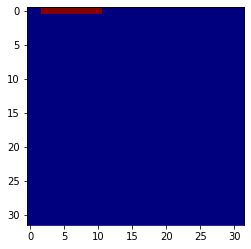

In [6]:
    geometry = np.ones((32, 32))
    geometry[24:28, 24:28] = np.nan
plt.imshow(B[2,0,:,:].numpy(), cmap = "jet")
# torch.save(Upsampled, 'FlowData_UV_0331_warm_mixed32.pt')

In [52]:
1 * np.nan

nan

In [44]:
Upsampled[4,1,0,:]

NameError: name 'Upsampled' is not defined

In [24]:
L = 1 # dimensionless LX / LX
H = 1 # dimensionless LY / LX
size = 32
dx = L / (size - 1)
dy = H / (size - 1)
CFL = 0.04
dt = CFL * min(dx , dy)
RE = 20
u = np.zeros((size, size))
v = np.zeros((size, size))
U0 = Upsampled[4,0,0,:].numpy()
V0 = Upsampled[4,1,0,:].numpy()
p = np.zeros((size, size))
usol, vsol, psol = solve_flow(5000, 32, 32, u, v, dt, dx, dy, p, u0 = U0, v0=V0 )


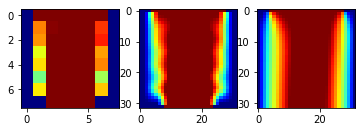

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(B[4,1,:,:].numpy(), vmin = 0, vmax = 0.4,cmap = "jet")
ax2.imshow(Upsampled[4,1,:,:].numpy(), vmin = 0, vmax = 0.4, cmap = "jet")
ax3.imshow(vsol, vmin = 0, vmax = 0.4, cmap = "jet")

In [29]:
vsol[0,:]

array([0.       , 0.       , 0.       , 0.       , 0.4040404, 0.4040404,
       0.4040404, 0.4040404, 0.4040404, 0.4040404, 0.4040404, 0.4040404,
       0.4040404, 0.4040404, 0.4040404, 0.4040404, 0.4040404, 0.4040404,
       0.4040404, 0.4040404, 0.4040404, 0.4040404, 0.4040404, 0.4040404,
       0.4040404, 0.4040404, 0.4040404, 0.4040404, 0.       , 0.       ,
       0.       , 0.       ])

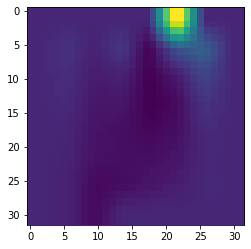

In [5]:
C = torch.load('FlowData_UV_0324_warm_mixed32.pt')
plt.imshow(C[1,0,:,:].numpy())

In [ ]:
F.interpolate(B[0, :, :, :], size=(32, 32, 32), mode='bilinear')

In [8]:
B[0,0,0,:]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909,
        0.0909, 0.0909, 0.0000, 0.0000, 0.0000])

#  PRECHECK Solution loss

In [4]:
Upsampled = torch.load('FlowData_UV_0331_warm_mixed32.pt')
u0_vector = Upsampled[10,0,0,:].detach().cpu().numpy()
v0_vector = Upsampled[10,1,0,:].detach().cpu().numpy()
geometry = torch.ones(1, 1, 32, 32)
centerLeft = 24
centerRight = 27
centerUpper = 24
centerLower = 27
geometry[:, :, centerLeft:centerRight + 1, centerUpper:centerLower+1] = 0
Upsampled_hollow = Upsampled  * geometry
size = 32
u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
L = 1
H = 1
dx = L / (size - 1)
dy = H / (size - 1)
CFL = 0.04
dt = CFL * min(dx , dy)
RE = 20

sol_u, sol_v, sol_p =solve_flow(5000, 32, 32, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector )
dtype = torch.FloatTensor
get_loss = conv_loss(dtype = dtype)
SOL = torch.zeros(1,3,32,32)
SOL[:,0,:,:] = torch.from_numpy(sol_u).unsqueeze(0).unsqueeze(0)
SOL[:,1,:,:] = torch.from_numpy(sol_v).unsqueeze(0).unsqueeze(0)
SOL[:,2,:,:] = torch.from_numpy(sol_p).unsqueeze(0).unsqueeze(0)

get_loss(Upsampled_hollow[10:11,:,:,:], SOL)

(tensor(1.9207e-06), 0.0, 0.0, 0.0, 0.0)

In [5]:
torch.save(Upsampled_hollow, 'FlowData_UV_0331_warm_mixed32_hollow.pt')

# Training

In [6]:
loss_hist = []
flow_dataset = CavityFlowDataset(root_dir='./', flowfile = 'FlowData_UV_0331_warm_mixed32_hollow.pt')
dataloader = data.DataLoader(flow_dataset, batch_size = 32,
                        shuffle=True, num_workers=2)
dtype = torch.cuda.FloatTensor
get_loss = conv_loss(dtype = dtype)
# # unet_outlet = UNet(dtype = dtype, img_size = 32).type(dtype)
# # optimizer = optim.Adam(unet_outlet.parameters(), lr = 4e-5)

for epoch in range(1,70000):
    for S in dataloader:
        img = S.requires_grad_(True).type(dtype)
        output = unet_outlet(img)
#         print(get_loss(img, img))
        loss, bd_loss, bdinner, p_neum, v_neum = get_loss(img.detach(), output)
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch ", epoch, "loss ", float(loss.detach()))
    print("boundary loss:", bd_loss, bdinner, "Neumann Loss:", p_neum, v_neum)
    loss_hist.append(float(loss.detach()))
    del loss
    if (epoch % 10000) == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': unet_outlet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, 'NSmixed_warm_0420_{}.pth'.format(epoch))

epoch  1 loss  0.19233310222625732
boundary loss: 0.0008181239245459437 0.0011042834958061576 Neumann Loss: 0.004857135005295277 0.006087343208491802
epoch  2 loss  0.13558810949325562
boundary loss: 0.0006574321887455881 0.0008261321345344186 Neumann Loss: 0.003812977345660329 0.003122838446870446
epoch  3 loss  0.11301697790622711
boundary loss: 0.00060656713321805 0.0006804851582273841 Neumann Loss: 0.0030251822900027037 0.002227157587185502
epoch  4 loss  0.09082318097352982
boundary loss: 0.0004915485624223948 0.0005897340597584844 Neumann Loss: 0.002327299676835537 0.00167055893689394
epoch  5 loss  0.08249728381633759
boundary loss: 0.0004865352821070701 0.0005728921969421208 Neumann Loss: 0.0026154441293329 0.0012172380229458213
epoch  6 loss  0.07065596431493759
boundary loss: 0.0004203520074952394 0.0005164601607248187 Neumann Loss: 0.0020822270307689905 0.001120940549299121
epoch  7 loss  0.08023589849472046
boundary loss: 0.00048624532064422965 0.00046386176836676896 Neuman

epoch  55 loss  0.04203953593969345
boundary loss: 0.00030253181466832757 0.00023183201847132295 Neumann Loss: 0.0010436457814648747 0.0005374598549678922
epoch  56 loss  0.03993711248040199
boundary loss: 0.0002897194353863597 0.00020314006542321295 Neumann Loss: 0.0013847711961716413 0.0005449930904433131
epoch  57 loss  0.0327814482152462
boundary loss: 0.0002475945802871138 0.0002180631854571402 Neumann Loss: 0.0013829427771270275 0.0004685387248173356
epoch  58 loss  0.033503662794828415
boundary loss: 0.0002674956922419369 0.00020718900486826897 Neumann Loss: 0.0010048934491351247 0.00045684148790314794
epoch  59 loss  0.034341417253017426
boundary loss: 0.0002533949736971408 0.0001915901666507125 Neumann Loss: 0.0015728374710306525 0.0004332438693381846
epoch  60 loss  0.03784261271357536
boundary loss: 0.00028036313597112894 0.0002067208697553724 Neumann Loss: 0.0010411625262349844 0.000500759924761951
epoch  61 loss  0.0390419103205204
boundary loss: 0.00030511230579577386 0.0

epoch  109 loss  0.03130220249295235
boundary loss: 0.00020599854178726673 0.00013104603567626327 Neumann Loss: 0.0014400148065760732 0.0005882253753952682
epoch  110 loss  0.028033746406435966
boundary loss: 0.0002044695138465613 0.00013297420809976757 Neumann Loss: 0.0010111237643286586 0.0004120317753404379
epoch  111 loss  0.029112769290804863
boundary loss: 0.0002330479328520596 0.00014204916078597307 Neumann Loss: 0.0013231087941676378 0.0003520197933539748
epoch  112 loss  0.027957072481513023
boundary loss: 0.0002310644485987723 0.0001370353566017002 Neumann Loss: 0.0012148837558925152 0.00037608208367601037
epoch  113 loss  0.03229917585849762
boundary loss: 0.00023634970420971513 0.00013801977911498398 Neumann Loss: 0.0016052614664658904 0.00041515842895023525
epoch  114 loss  0.02801428735256195
boundary loss: 0.00019728302140720189 0.0001329509832430631 Neumann Loss: 0.0009561649640090764 0.0003553039859980345
epoch  115 loss  0.03156749904155731
boundary loss: 0.0002165617

epoch  162 loss  0.029071826487779617
boundary loss: 0.00019736308604478836 0.00011103769793407992 Neumann Loss: 0.0008838715148158371 0.0007185011054389179
epoch  163 loss  0.029904711991548538
boundary loss: 0.00021335580095183104 0.00011404035467421636 Neumann Loss: 0.0017853202298283577 0.00039927850593812764
epoch  164 loss  0.026648376137018204
boundary loss: 0.00020618943381123245 0.0001122842077165842 Neumann Loss: 0.0008759396150708199 0.0003616232716012746
epoch  165 loss  0.027979623526334763
boundary loss: 0.0002206396748078987 0.00010789933730848134 Neumann Loss: 0.0011573022929951549 0.00048797138151712716
epoch  166 loss  0.022244809195399284
boundary loss: 0.00017540919361636043 0.00011364673264324665 Neumann Loss: 0.0011860551312565804 0.0003480896120890975
epoch  167 loss  0.029886329546570778
boundary loss: 0.00022304618323687464 0.00011095274385297671 Neumann Loss: 0.0016736102988943458 0.0003763861604966223
epoch  168 loss  0.029035422950983047
boundary loss: 0.000

epoch  215 loss  0.02869422920048237
boundary loss: 0.0002152966189896688 8.465626888209954e-05 Neumann Loss: 0.0015562867047265172 0.0004779428709298372
epoch  216 loss  0.02945636212825775
boundary loss: 0.00020687485812231898 9.615445014787838e-05 Neumann Loss: 0.0013968282146379352 0.00043485127389431
epoch  217 loss  0.027766266837716103
boundary loss: 0.0002147044287994504 9.851801587501541e-05 Neumann Loss: 0.001523143146187067 0.0003747707814909518
epoch  218 loss  0.026936810463666916
boundary loss: 0.00021990749519318342 9.724660776555538e-05 Neumann Loss: 0.0011513395002111793 0.00028646321152336895
epoch  219 loss  0.022598756477236748
boundary loss: 0.0001829426473705098 9.258511272491887e-05 Neumann Loss: 0.0012748269364237785 0.00033068942138925195
epoch  220 loss  0.026832761242985725
boundary loss: 0.0002032807096838951 0.000101934012491256 Neumann Loss: 0.0012504757614806294 0.0004075334290973842
epoch  221 loss  0.023800108581781387
boundary loss: 0.00019350256479810

epoch  268 loss  0.02319028414785862
boundary loss: 0.000178960821358487 9.172035061055794e-05 Neumann Loss: 0.0009298439836129546 0.00026923796394839883
epoch  269 loss  0.02431430295109749
boundary loss: 0.00019330500799696892 9.028561180457473e-05 Neumann Loss: 0.001354498672299087 0.0002700488839764148
epoch  270 loss  0.02017921581864357
boundary loss: 0.0001574506313772872 8.725732186576352e-05 Neumann Loss: 0.001399492146447301 0.0003029684885405004
epoch  271 loss  0.031973425298929214
boundary loss: 0.00020446573034860194 8.424340921919793e-05 Neumann Loss: 0.001507974462583661 0.0004363333573564887
epoch  272 loss  0.025027213618159294
boundary loss: 0.00019430468091741204 8.280683687189594e-05 Neumann Loss: 0.0009741495014168322 0.0003888916689902544
epoch  273 loss  0.022070739418268204
boundary loss: 0.00017639072029851377 8.364917448488995e-05 Neumann Loss: 0.000957474228926003 0.00029537573573179543
epoch  274 loss  0.021995199844241142
boundary loss: 0.00018985412316396

epoch  321 loss  0.0254904106259346
boundary loss: 0.00019753344531636685 7.339095463976264e-05 Neumann Loss: 0.0015203440561890602 0.0003458996652625501
epoch  322 loss  0.0254195723682642
boundary loss: 0.00019749470811802894 8.089450420811772e-05 Neumann Loss: 0.0011402154341340065 0.0003947583900298923
epoch  323 loss  0.02208256721496582
boundary loss: 0.00018084084149450064 8.157077536452562e-05 Neumann Loss: 0.0011393249733373523 0.0003077136352658272
epoch  324 loss  0.02154688537120819
boundary loss: 0.00018050498329102993 8.003060065675527e-05 Neumann Loss: 0.0012031389633193612 0.0002870439493563026
epoch  325 loss  0.020321369171142578
boundary loss: 0.0001707839110167697 8.017262734938413e-05 Neumann Loss: 0.0013023383216932416 0.0002905019500758499
epoch  326 loss  0.02593510039150715
boundary loss: 0.00019439979223534465 7.475185702787712e-05 Neumann Loss: 0.001431770739145577 0.00035926507553085685
epoch  327 loss  0.026138659566640854
boundary loss: 0.00019086408428847

epoch  374 loss  0.022227812558412552
boundary loss: 0.00017486406431999058 7.761418237350881e-05 Neumann Loss: 0.001244720071554184 0.00042559331632219255
epoch  375 loss  0.01928870752453804
boundary loss: 0.00015752649051137269 7.967769488459453e-05 Neumann Loss: 0.0006037371349520981 0.00031227697036229074
epoch  376 loss  0.02399391494691372
boundary loss: 0.000197451445274055 7.686883327551186e-05 Neumann Loss: 0.0018179483013227582 0.00042148667853325605
epoch  377 loss  0.02288183756172657
boundary loss: 0.0001965789560927078 7.490001735277474e-05 Neumann Loss: 0.00129229505546391 0.0003096700238529593
epoch  378 loss  0.0217317882925272
boundary loss: 0.00018320271919947118 8.19487395347096e-05 Neumann Loss: 0.001137064304202795 0.0002796025073621422
epoch  379 loss  0.02668941393494606
boundary loss: 0.00018812139751389623 7.52387277316302e-05 Neumann Loss: 0.002038422506302595 0.00038167330785654485
epoch  380 loss  0.019446467980742455
boundary loss: 0.0001603532728040591 7

epoch  427 loss  0.022170208394527435
boundary loss: 0.0001772990362951532 7.250630005728453e-05 Neumann Loss: 0.0011756817111745477 0.00029719265876337886
epoch  428 loss  0.028630463406443596
boundary loss: 0.00017395293980371207 7.602868572575971e-05 Neumann Loss: 0.0012015928514301777 0.0005254900315776467
epoch  429 loss  0.021496716886758804
boundary loss: 0.0001516829215688631 7.387030927930027e-05 Neumann Loss: 0.0014173773815855384 0.0002704633225221187
epoch  430 loss  0.02175629884004593
boundary loss: 0.00019719870761036873 6.859043060103431e-05 Neumann Loss: 0.0012786031002178788 0.0002738857292570174
epoch  431 loss  0.020756971091032028
boundary loss: 0.00018300628289580345 7.083079981384799e-05 Neumann Loss: 0.001297338749282062 0.0002658098819665611
epoch  432 loss  0.02152172289788723
boundary loss: 0.00016408438386861235 8.034029451664537e-05 Neumann Loss: 0.0010760878212749958 0.00032314466079697013
epoch  433 loss  0.020443933084607124
boundary loss: 0.000176995701

epoch  480 loss  0.02234877645969391
boundary loss: 0.00017432283493690193 6.771740299882367e-05 Neumann Loss: 0.0013580161612480879 0.0005497719976119697
epoch  481 loss  0.019327880814671516
boundary loss: 0.00017477234359830618 7.419337634928524e-05 Neumann Loss: 0.0014914433704689145 0.00030596242868341506
epoch  482 loss  0.020937582477927208
boundary loss: 0.00017918490630108863 6.8636130890809e-05 Neumann Loss: 0.0009305907879024744 0.00030388706363737583
epoch  483 loss  0.024471843615174294
boundary loss: 0.00019823259208351374 6.7980530729983e-05 Neumann Loss: 0.0018385617295280099 0.00035030374419875443
epoch  484 loss  0.024152159690856934
boundary loss: 0.0001832511043176055 6.325394497253001e-05 Neumann Loss: 0.0012212945148348808 0.00036825292045250535
epoch  485 loss  0.0217717494815588
boundary loss: 0.00018478327547200024 6.256818596739322e-05 Neumann Loss: 0.0010636391816660762 0.0002879406383726746
epoch  486 loss  0.02154846116900444
boundary loss: 0.00018637102039

epoch  533 loss  0.02345276065170765
boundary loss: 0.00016569322906434536 6.85129125486128e-05 Neumann Loss: 0.001474000047892332 0.0003683460527099669
epoch  534 loss  0.027200380340218544
boundary loss: 0.00017192738596349955 6.386065069818869e-05 Neumann Loss: 0.0012506003258749843 0.0006619607447646558
epoch  535 loss  0.01765633374452591
boundary loss: 0.0001561690733069554 6.612449215026572e-05 Neumann Loss: 0.0010541455121710896 0.0002520786947570741
epoch  536 loss  0.022083094343543053
boundary loss: 0.00018043836462311447 6.883447349537164e-05 Neumann Loss: 0.00130581168923527 0.0002951917995233089
epoch  537 loss  0.01976349763572216
boundary loss: 0.00017544094589538872 6.516366556752473e-05 Neumann Loss: 0.0011942581040784717 0.0003863440069835633
epoch  538 loss  0.02204158529639244
boundary loss: 0.00015909943613223732 6.365199806168675e-05 Neumann Loss: 0.001093022059649229 0.0003448499774094671
epoch  539 loss  0.02122666873037815
boundary loss: 0.00018410105258226395

epoch  586 loss  0.023683132603764534
boundary loss: 0.00017301959451287985 6.602646317332983e-05 Neumann Loss: 0.0012073887046426535 0.0003543564525898546
epoch  587 loss  0.018917430192232132
boundary loss: 0.00014930074394214898 6.502764153992757e-05 Neumann Loss: 0.0014195478288456798 0.0003336720692459494
epoch  588 loss  0.020176749676465988
boundary loss: 0.00016878379392437637 6.333955388981849e-05 Neumann Loss: 0.0010006707161664963 0.0002885962894652039
epoch  589 loss  0.0225924551486969
boundary loss: 0.00018872901273425668 5.565593528444879e-05 Neumann Loss: 0.001034350018016994 0.000255455233855173
epoch  590 loss  0.02161026932299137
boundary loss: 0.00017443354590795934 5.890216925763525e-05 Neumann Loss: 0.0013720394345000386 0.0002695460570976138
epoch  591 loss  0.021565262228250504
boundary loss: 0.00016948836855590343 6.132614362286404e-05 Neumann Loss: 0.0012330824974924326 0.0003645262913778424
epoch  592 loss  0.020297737792134285
boundary loss: 0.00015217189502

epoch  639 loss  0.023737825453281403
boundary loss: 0.00016671756748110056 6.123851926531643e-05 Neumann Loss: 0.0014196961419656873 0.0004160677781328559
epoch  640 loss  0.02359294518828392
boundary loss: 0.00017451249004807323 6.316877261269838e-05 Neumann Loss: 0.0013470062986016273 0.0004443159559741616
epoch  641 loss  0.022950075566768646
boundary loss: 0.00016474182484671474 6.796668458264321e-05 Neumann Loss: 0.000963457627221942 0.00030705647077411413
epoch  642 loss  0.0219255443662405
boundary loss: 0.00017604722233954817 5.449779928312637e-05 Neumann Loss: 0.0014635343104600906 0.0003154657897539437
epoch  643 loss  0.022891810163855553
boundary loss: 0.00017483261763118207 6.284730625338852e-05 Neumann Loss: 0.001189608359709382 0.0003866272163577378
epoch  644 loss  0.018605267629027367
boundary loss: 0.00015428560436703265 5.878014053450897e-05 Neumann Loss: 0.0015078437281772494 0.0003207339614164084
epoch  645 loss  0.019165944308042526
boundary loss: 0.0001534402254

epoch  692 loss  0.023261921480298042
boundary loss: 0.00015878249541856349 6.529164966195822e-05 Neumann Loss: 0.001090280245989561 0.0003012408851645887
epoch  693 loss  0.018258225172758102
boundary loss: 0.00013551066513173282 6.339487299555913e-05 Neumann Loss: 0.001351549755781889 0.0003269099979661405
epoch  694 loss  0.019024759531021118
boundary loss: 0.00016035883163567632 5.886550934519619e-05 Neumann Loss: 0.0013853779528290033 0.00032075849594548345
epoch  695 loss  0.020460693165659904
boundary loss: 0.0001623739517526701 5.6505799875594676e-05 Neumann Loss: 0.0014499833341687918 0.00030439678812399507
epoch  696 loss  0.01878810115158558
boundary loss: 0.00014306572847999632 5.7101093261735514e-05 Neumann Loss: 0.0015291775343939662 0.0003801388666033745
epoch  697 loss  0.022037532180547714
boundary loss: 0.00016920958296395838 5.459954991238192e-05 Neumann Loss: 0.0011194697581231594 0.0005232744151726365
epoch  698 loss  0.018796419724822044
boundary loss: 0.000149811

epoch  745 loss  0.015431639738380909
boundary loss: 0.00013746913464274257 5.787522968603298e-05 Neumann Loss: 0.0008588058408349752 0.00034243916161358356
epoch  746 loss  0.02216951921582222
boundary loss: 0.00014516004011966288 6.064126864657737e-05 Neumann Loss: 0.0014104351866990328 0.0004821253241971135
epoch  747 loss  0.02195148728787899
boundary loss: 0.00016363171744160354 5.6336026318604127e-05 Neumann Loss: 0.0021268047858029604 0.0004543784889392555
epoch  748 loss  0.02876150794327259
boundary loss: 0.00016101058281492442 5.911446351092309e-05 Neumann Loss: 0.0015672744484618306 0.0005661441246047616
epoch  749 loss  0.02316785603761673
boundary loss: 0.0001768403744790703 5.615351619780995e-05 Neumann Loss: 0.0016505906824022532 0.00031486080843023956
epoch  750 loss  0.019521439447999
boundary loss: 0.0001583403500262648 5.7372286391910166e-05 Neumann Loss: 0.0018892561784014106 0.0002815386396832764
epoch  751 loss  0.023902488872408867
boundary loss: 0.00016076955944

epoch  798 loss  0.02041424624621868
boundary loss: 0.00015765911666676402 5.3519150242209435e-05 Neumann Loss: 0.001215953379869461 0.0004159879172220826
epoch  799 loss  0.023132480680942535
boundary loss: 0.00015599389735143632 5.7032702898141e-05 Neumann Loss: 0.0008998258854262531 0.0004239694681018591
epoch  800 loss  0.023686252534389496
boundary loss: 0.00016802809841465205 5.475585567182861e-05 Neumann Loss: 0.00176167581230402 0.0005102724535390735
epoch  801 loss  0.01883542351424694
boundary loss: 0.0001473520533181727 6.155903247417882e-05 Neumann Loss: 0.0010716214310377836 0.0003416621475480497
epoch  802 loss  0.022285792976617813
boundary loss: 0.00014025351265445352 5.7298995670862496e-05 Neumann Loss: 0.0012445020256564021 0.0003117411397397518
epoch  803 loss  0.0246181208640337
boundary loss: 0.00014995443052612245 5.639222217723727e-05 Neumann Loss: 0.0014654943952336907 0.00041839637560769916
epoch  804 loss  0.025739528238773346
boundary loss: 0.0001572081528138

epoch  851 loss  0.021219536662101746
boundary loss: 0.00017337843019049615 4.9540121835889295e-05 Neumann Loss: 0.001076896209269762 0.0003573630820028484
epoch  852 loss  0.018032114952802658
boundary loss: 0.00014895929780323058 5.721027991967276e-05 Neumann Loss: 0.0009903645841404796 0.00028902216581627727
epoch  853 loss  0.020114706829190254
boundary loss: 0.0001572381443111226 5.574698661803268e-05 Neumann Loss: 0.0013264986919239163 0.00044356114813126624
epoch  854 loss  0.01813516765832901
boundary loss: 0.00015279145736712962 5.52099991182331e-05 Neumann Loss: 0.001512398011982441 0.0003465093031991273
epoch  855 loss  0.020032238215208054
boundary loss: 0.00016814979608170688 4.684017403633334e-05 Neumann Loss: 0.001926625263877213 0.000333141244482249
epoch  856 loss  0.019765449687838554
boundary loss: 0.00014964197180233896 5.028600571677089e-05 Neumann Loss: 0.0008901255205273628 0.00030436262022703886
epoch  857 loss  0.021023374050855637
boundary loss: 0.000176760164

epoch  904 loss  0.01748664118349552
boundary loss: 0.0001437005994375795 5.263785715214908e-05 Neumann Loss: 0.0016479818150401115 0.0003039347939193249
epoch  905 loss  0.01834294945001602
boundary loss: 0.0001528394059278071 5.054890789324418e-05 Neumann Loss: 0.0017438743961974978 0.00023880423395894468
epoch  906 loss  0.018537195399403572
boundary loss: 0.0001440272608306259 5.69374933547806e-05 Neumann Loss: 0.0010057745967060328 0.00035710851079784334
epoch  907 loss  0.022401226684451103
boundary loss: 0.00014982582069933414 5.067554593551904e-05 Neumann Loss: 0.0014299630420282483 0.00039985531475394964
epoch  908 loss  0.02045319974422455
boundary loss: 0.00015038222773000598 5.132390288054012e-05 Neumann Loss: 0.001386104035191238 0.0004686246975325048
epoch  909 loss  0.017129603773355484
boundary loss: 0.00015491258818656206 5.365791730582714e-05 Neumann Loss: 0.001328385784290731 0.00020994391525164247
epoch  910 loss  0.017168104648590088
boundary loss: 0.00014312045823

epoch  957 loss  0.018346227705478668
boundary loss: 0.00014029718295205384 5.341282667359337e-05 Neumann Loss: 0.002032011980190873 0.00027704486274160445
epoch  958 loss  0.020174769684672356
boundary loss: 0.00016772901290096343 5.0773720431607217e-05 Neumann Loss: 0.001813577488064766 0.00033463648287579417
epoch  959 loss  0.019576193764805794
boundary loss: 0.0001474962627980858 5.423302354756743e-05 Neumann Loss: 0.0013412546832114458 0.000291370612103492
epoch  960 loss  0.021297790110111237
boundary loss: 0.000135313966893591 5.461178079713136e-05 Neumann Loss: 0.0018660278292372823 0.0003617166366893798
epoch  961 loss  0.021336859092116356
boundary loss: 0.00013253858196549118 5.1097744290018454e-05 Neumann Loss: 0.0010730137582868338 0.00044144800631329417
epoch  962 loss  0.02343672700226307
boundary loss: 0.00016155658522620797 4.800605893251486e-05 Neumann Loss: 0.001441860687918961 0.00040068672387860715
epoch  963 loss  0.0209980271756649
boundary loss: 0.0001569064770

epoch  1010 loss  0.01637067273259163
boundary loss: 0.00014833029126748443 5.230600800132379e-05 Neumann Loss: 0.0015362219419330359 0.0004068736161570996
epoch  1011 loss  0.018615571781992912
boundary loss: 0.0001468857517465949 4.4815995352109894e-05 Neumann Loss: 0.0009873051894828677 0.00026430192519910634
epoch  1012 loss  0.020692765712738037
boundary loss: 0.00016075072926469147 4.933661693939939e-05 Neumann Loss: 0.0014396263286471367 0.00041372902342118323
epoch  1013 loss  0.017722494900226593
boundary loss: 0.00015176534361671656 5.26308904227335e-05 Neumann Loss: 0.0010190014727413654 0.0002674248826224357
epoch  1014 loss  0.020395981147885323
boundary loss: 0.00013888701505493373 4.9455084081273526e-05 Neumann Loss: 0.0018003977602347732 0.0003266929998062551
epoch  1015 loss  0.018280573189258575
boundary loss: 0.000131390115711838 5.421189052867703e-05 Neumann Loss: 0.0013213797938078642 0.0002635835553519428
epoch  1016 loss  0.02228543907403946
boundary loss: 0.0001

epoch  1063 loss  0.02529050037264824
boundary loss: 0.0001343691546935588 4.9944886995945126e-05 Neumann Loss: 0.0009850807255133986 0.0005444222479127347
epoch  1064 loss  0.022810185328125954
boundary loss: 0.00014983006985858083 4.431604975252412e-05 Neumann Loss: 0.0011828794376924634 0.0005937704117968678
epoch  1065 loss  0.017082378268241882
boundary loss: 0.00015549514500889927 4.841913323616609e-05 Neumann Loss: 0.0011293768184259534 0.00023261526075657457
epoch  1066 loss  0.01846112497150898
boundary loss: 0.00014975873637013137 4.592688492266461e-05 Neumann Loss: 0.0010786891216412187 0.00033140371670015156
epoch  1067 loss  0.019424566999077797
boundary loss: 0.0001615333603695035 5.371544830268249e-05 Neumann Loss: 0.001172959222458303 0.00042034502257592976
epoch  1068 loss  0.028672436252236366
boundary loss: 0.0001666066236793995 5.018579395255074e-05 Neumann Loss: 0.001507353619672358 0.0004260544665157795
epoch  1069 loss  0.019172627478837967
boundary loss: 0.00014

epoch  1116 loss  0.015818243846297264
boundary loss: 0.0001491330622229725 4.4656906538875774e-05 Neumann Loss: 0.0009246124536730349 0.0002922743442468345
epoch  1117 loss  0.016294512897729874
boundary loss: 0.00013425317592918873 4.9019923608284444e-05 Neumann Loss: 0.0010040855268016458 0.0002237586013507098
epoch  1118 loss  0.018550720065832138
boundary loss: 0.00012204578524688259 4.780626477440819e-05 Neumann Loss: 0.0009819704573601484 0.00028279313119128346
epoch  1119 loss  0.02013162523508072
boundary loss: 0.00013883890642318875 4.9423160817241296e-05 Neumann Loss: 0.0012636135797947645 0.0003699357621371746
epoch  1120 loss  0.019186146557331085
boundary loss: 0.00012817193055525422 5.358610360417515e-05 Neumann Loss: 0.0015015511307865381 0.0003373175277374685
epoch  1121 loss  0.018250036984682083
boundary loss: 0.00013150533777661622 5.157024861546233e-05 Neumann Loss: 0.0013340229634195566 0.00034639507066458464
epoch  1122 loss  0.019463032484054565
boundary loss: 0

epoch  1169 loss  0.01815251260995865
boundary loss: 0.00013370162923820317 4.980591620551422e-05 Neumann Loss: 0.0016851057298481464 0.00031658069929108024
epoch  1170 loss  0.020762164145708084
boundary loss: 0.0001409911783412099 4.6264711272669956e-05 Neumann Loss: 0.0019124234095215797 0.0004280671419110149
epoch  1171 loss  0.02153533510863781
boundary loss: 0.00015762477414682508 4.56713569292333e-05 Neumann Loss: 0.0010806290665641427 0.0003494148259051144
epoch  1172 loss  0.017908364534378052
boundary loss: 0.00011814496974693611 4.960787919117138e-05 Neumann Loss: 0.0010161187965422869 0.0002757390320766717
epoch  1173 loss  0.0222370233386755
boundary loss: 0.00013826866052113473 4.6574561565648764e-05 Neumann Loss: 0.0009166586678475142 0.0004894129815511405
epoch  1174 loss  0.0244712196290493
boundary loss: 0.0001562621328048408 4.3628340790746734e-05 Neumann Loss: 0.001240248209796846 0.00044826045632362366
epoch  1175 loss  0.020118622109293938
boundary loss: 0.0001424

epoch  1222 loss  0.019992517307400703
boundary loss: 0.00014182983431965113 4.852788333664648e-05 Neumann Loss: 0.0014320745831355453 0.0003578857867978513
epoch  1223 loss  0.02415630593895912
boundary loss: 0.00015276701014954597 3.898286013281904e-05 Neumann Loss: 0.0015866426983848214 0.0003743675770238042
epoch  1224 loss  0.01315309014171362
boundary loss: 0.00012361790868453681 4.607007576851174e-05 Neumann Loss: 0.000965708983130753 0.0001919625501614064
epoch  1225 loss  0.014035877771675587
boundary loss: 0.00012370580225251615 4.411394911585376e-05 Neumann Loss: 0.0009465175098739564 0.00024350950843654573
epoch  1226 loss  0.020213373005390167
boundary loss: 0.00014273534179665148 4.130154775339179e-05 Neumann Loss: 0.00150708993896842 0.0003403918235562742
epoch  1227 loss  0.019935263320803642
boundary loss: 0.0001356276625301689 4.510745930019766e-05 Neumann Loss: 0.0009462660527788103 0.00044084840919822454
epoch  1228 loss  0.019060522317886353
boundary loss: 0.000152

epoch  1275 loss  0.016113843768835068
boundary loss: 0.0001435758895240724 4.6411918447120115e-05 Neumann Loss: 0.0013030307600274682 0.00026278902078047395
epoch  1276 loss  0.014835935086011887
boundary loss: 0.00013770976511295885 4.50526422355324e-05 Neumann Loss: 0.0013743593590334058 0.0001770973758539185
epoch  1277 loss  0.016620131209492683
boundary loss: 0.00014455326891038567 4.0261827962240204e-05 Neumann Loss: 0.001254623057320714 0.00033763510873541236
epoch  1278 loss  0.019105514511466026
boundary loss: 0.0001523047249065712 4.5189863158157095e-05 Neumann Loss: 0.00094386882847175 0.0003810266498476267
epoch  1279 loss  0.015434249304234982
boundary loss: 0.00012314299237914383 4.486992838792503e-05 Neumann Loss: 0.0013547020498663187 0.0002833805338013917
epoch  1280 loss  0.021091043949127197
boundary loss: 0.00013941139332018793 4.751725646201521e-05 Neumann Loss: 0.0018298515351489186 0.0003411829238757491
epoch  1281 loss  0.01628980040550232
boundary loss: 0.0001

epoch  1328 loss  0.016571305692195892
boundary loss: 0.00012751194299198687 4.3629566789604723e-05 Neumann Loss: 0.0025788259226828814 0.0002496576344128698
epoch  1329 loss  0.015202324837446213
boundary loss: 0.0001341267634415999 4.2676088924054056e-05 Neumann Loss: 0.0009162685018964112 0.0002478164969943464
epoch  1330 loss  0.016897449269890785
boundary loss: 0.00012100423191441223 4.478257687878795e-05 Neumann Loss: 0.0017876661149784923 0.0004726315091829747
epoch  1331 loss  0.021117936819791794
boundary loss: 0.00013867337838746607 4.654363146983087e-05 Neumann Loss: 0.001508709043264389 0.00028855461277998984
epoch  1332 loss  0.01634923182427883
boundary loss: 0.00013019023754168302 4.417054879013449e-05 Neumann Loss: 0.001049472950398922 0.0002726030070334673
epoch  1333 loss  0.020793426781892776
boundary loss: 0.00014488027954939753 4.449710831977427e-05 Neumann Loss: 0.0014396898914128542 0.0003430273209232837
epoch  1334 loss  0.016792653128504753
boundary loss: 0.000

epoch  1381 loss  0.019819660112261772
boundary loss: 0.00013353458780329674 4.161366814514622e-05 Neumann Loss: 0.001243495149537921 0.00031217248761095107
epoch  1382 loss  0.02034204639494419
boundary loss: 0.0001371778198517859 4.112068927497603e-05 Neumann Loss: 0.0017569983610883355 0.00039811007445678115
epoch  1383 loss  0.02109239064157009
boundary loss: 0.0001599918323336169 4.0548056858824566e-05 Neumann Loss: 0.0011667072540149093 0.0003943032934330404
epoch  1384 loss  0.020408133044838905
boundary loss: 0.00013529394345823675 4.372022158349864e-05 Neumann Loss: 0.0012573207495734096 0.00037441731547005475
epoch  1385 loss  0.015241327695548534
boundary loss: 0.00013302586739882827 4.496565816225484e-05 Neumann Loss: 0.0010855759028345346 0.00026064965641126037
epoch  1386 loss  0.015625083819031715
boundary loss: 0.0001248481567017734 4.4153679482406005e-05 Neumann Loss: 0.0014811473665758967 0.00024241722712758929
epoch  1387 loss  0.014615328051149845
boundary loss: 0.0

epoch  1434 loss  0.018594425171613693
boundary loss: 0.00013722083531320095 4.383163832244463e-05 Neumann Loss: 0.0014516860246658325 0.0002490083279553801
epoch  1435 loss  0.01655125431716442
boundary loss: 0.00012227716797497123 4.0832914237398654e-05 Neumann Loss: 0.0013614838244393468 0.00041893572779372334
epoch  1436 loss  0.01929887942969799
boundary loss: 0.00012672709999606013 4.131787136429921e-05 Neumann Loss: 0.0011372778099030256 0.0003231338341720402
epoch  1437 loss  0.01611936464905739
boundary loss: 0.0001312292879447341 4.129682929487899e-05 Neumann Loss: 0.001118239713832736 0.00032685667974874377
epoch  1438 loss  0.017879357561469078
boundary loss: 0.00011654762784019113 4.4820073526352644e-05 Neumann Loss: 0.0011251418618485332 0.0003900171723216772
epoch  1439 loss  0.016321158036589622
boundary loss: 0.0001264166203327477 4.072908632224426e-05 Neumann Loss: 0.001565302605740726 0.00033002084819599986
epoch  1440 loss  0.015226844698190689
boundary loss: 0.0001

epoch  1487 loss  0.017811836674809456
boundary loss: 0.00013538294297177345 3.7110406992724165e-05 Neumann Loss: 0.0010753172682598233 0.00036393257323652506
epoch  1488 loss  0.01637033000588417
boundary loss: 0.00012214558955747634 3.6661607737187296e-05 Neumann Loss: 0.0010985074331983924 0.0002984259626828134
epoch  1489 loss  0.01609794981777668
boundary loss: 0.00013282004510983825 4.072062438353896e-05 Neumann Loss: 0.0013262678403407335 0.00026292979600839317
epoch  1490 loss  0.021958285942673683
boundary loss: 0.00012799743853975087 4.293929669074714e-05 Neumann Loss: 0.0014467668952420354 0.000432089960668236
epoch  1491 loss  0.014341667294502258
boundary loss: 0.00011975999950664118 4.4728807552019134e-05 Neumann Loss: 0.0009299194207414985 0.00021795512293465436
epoch  1492 loss  0.016344338655471802
boundary loss: 0.00013598782243207097 4.243230796419084e-05 Neumann Loss: 0.0010719707934185863 0.00029495678609237075
epoch  1493 loss  0.017067765817046165
boundary loss: 

epoch  1540 loss  0.014927727170288563
boundary loss: 0.00012581382179632783 3.9937967812875286e-05 Neumann Loss: 0.001356532913632691 0.00025337436818517745
epoch  1541 loss  0.022506998851895332
boundary loss: 0.0001430220145266503 4.269605051376857e-05 Neumann Loss: 0.0011435755295678973 0.00035080997622571886
epoch  1542 loss  0.016956815496087074
boundary loss: 0.00013142295938450843 3.977816231781617e-05 Neumann Loss: 0.0012036615516990423 0.00028713353094644845
epoch  1543 loss  0.01665903441607952
boundary loss: 0.00011905768042197451 4.310760414227843e-05 Neumann Loss: 0.0010572484461590648 0.0002927048481069505
epoch  1544 loss  0.02262086793780327
boundary loss: 0.0001395001745549962 4.4921405788045377e-05 Neumann Loss: 0.0009134325082413852 0.0003847305488307029
epoch  1545 loss  0.017227156087756157
boundary loss: 0.00013568403664976358 3.5438002669252455e-05 Neumann Loss: 0.0016000873874872923 0.00028918820316903293
epoch  1546 loss  0.016250234097242355
boundary loss: 0.

epoch  1593 loss  0.018338335677981377
boundary loss: 0.00012328187585808337 4.2155188566539437e-05 Neumann Loss: 0.0010277362307533622 0.00043279456440359354
epoch  1594 loss  0.017142413184046745
boundary loss: 0.00013022724306210876 4.068254929734394e-05 Neumann Loss: 0.0014283987693488598 0.0002891922486014664
epoch  1595 loss  0.01633298583328724
boundary loss: 0.0001466713729314506 4.14144633396063e-05 Neumann Loss: 0.0018236470641568303 0.00023589259944856167
epoch  1596 loss  0.01543631311506033
boundary loss: 0.0001335797132924199 3.9738763007335365e-05 Neumann Loss: 0.0010893846629187465 0.00029327120864763856
epoch  1597 loss  0.015174755826592445
boundary loss: 0.00013445495278574526 3.9034643123159185e-05 Neumann Loss: 0.001312584732659161 0.00025127403205260634
epoch  1598 loss  0.018329929560422897
boundary loss: 0.00013525963004212826 4.2821058741537854e-05 Neumann Loss: 0.001269461470656097 0.00037458044243976474
epoch  1599 loss  0.0179409421980381
boundary loss: 0.00

epoch  1646 loss  0.01575310155749321
boundary loss: 0.00012739749217871577 4.456064561964013e-05 Neumann Loss: 0.0009104734053835273 0.00026819531922228634
epoch  1647 loss  0.015532586723566055
boundary loss: 0.00013185085845179856 4.059905404574238e-05 Neumann Loss: 0.0013384436024352908 0.00032269652001559734
epoch  1648 loss  0.0158945694565773
boundary loss: 0.00012144434731453657 3.658197238110006e-05 Neumann Loss: 0.0010732882656157017 0.00035766971996054053
epoch  1649 loss  0.01797649823129177
boundary loss: 0.0001242439029738307 4.1650277125881985e-05 Neumann Loss: 0.0015225156676024199 0.00023134800721891224
epoch  1650 loss  0.018678702414035797
boundary loss: 0.00012393340875860304 4.3117172026541084e-05 Neumann Loss: 0.0013652812922373414 0.0004246726748533547
epoch  1651 loss  0.018437635153532028
boundary loss: 0.00013636051153298467 4.0900322346715257e-05 Neumann Loss: 0.0015450255014002323 0.0004056847537867725
epoch  1652 loss  0.015752499923110008
boundary loss: 0.

epoch  1699 loss  0.015100868418812752
boundary loss: 0.00012912219972349703 4.0243077819468454e-05 Neumann Loss: 0.0011905269930139184 0.00025585704133845866
epoch  1700 loss  0.018874751403927803
boundary loss: 0.00011969413026235998 3.9563397876918316e-05 Neumann Loss: 0.001438463805243373 0.00042096423567272723
epoch  1701 loss  0.014134900644421577
boundary loss: 0.0001142951805377379 3.7957142922095954e-05 Neumann Loss: 0.0010671511990949512 0.00024186492373701185
epoch  1702 loss  0.016926690936088562
boundary loss: 0.00012263437383808196 4.2049625335494056e-05 Neumann Loss: 0.001244976301677525 0.000510401907376945
epoch  1703 loss  0.019151566550135612
boundary loss: 0.00013750320067629218 3.726192517206073e-05 Neumann Loss: 0.0018521568272262812 0.00029348445241339505
epoch  1704 loss  0.016406197100877762
boundary loss: 0.00011764716327888891 3.9512575312983245e-05 Neumann Loss: 0.0013050175039097667 0.0003617694601416588
epoch  1705 loss  0.015559596009552479
boundary loss:

epoch  1752 loss  0.013746007345616817
boundary loss: 0.00011776036262745038 3.804579682764597e-05 Neumann Loss: 0.0014020700473338366 0.00024984966148622334
epoch  1753 loss  0.01646563597023487
boundary loss: 0.00012838885595556349 3.7999936466803774e-05 Neumann Loss: 0.0015897387638688087 0.00031973831937648356
epoch  1754 loss  0.015431076288223267
boundary loss: 0.0001176935329567641 4.3277574150124565e-05 Neumann Loss: 0.0012456157710403204 0.00025720399571582675
epoch  1755 loss  0.018342263996601105
boundary loss: 0.0001156442376668565 3.7755609810119495e-05 Neumann Loss: 0.0012280060909688473 0.00029798163450323045
epoch  1756 loss  0.019316518679261208
boundary loss: 0.00014988670591264963 3.8546066207345575e-05 Neumann Loss: 0.0013580136001110077 0.0005957854446023703
epoch  1757 loss  0.017773067578673363
boundary loss: 0.00010280349670210853 3.574808215489611e-05 Neumann Loss: 0.0012532364344224334 0.00036764977267012
epoch  1758 loss  0.014646708965301514
boundary loss: 0

epoch  1805 loss  0.01436837762594223
boundary loss: 0.00013639498502016068 3.4595846955198795e-05 Neumann Loss: 0.0007477920153178275 0.00023027521092444658
epoch  1806 loss  0.018283743411302567
boundary loss: 9.82117562671192e-05 3.5367989767109975e-05 Neumann Loss: 0.0014187885681167245 0.0004213148495182395
epoch  1807 loss  0.01657206006348133
boundary loss: 0.0001301798620261252 3.925950295524672e-05 Neumann Loss: 0.0012927689822390676 0.0002561185974627733
epoch  1808 loss  0.019055200740695
boundary loss: 0.00012902934395242482 3.736623330041766e-05 Neumann Loss: 0.0007762303575873375 0.0003430056676734239
epoch  1809 loss  0.014682981185615063
boundary loss: 0.00012032387894578278 3.5301141906529665e-05 Neumann Loss: 0.0011120667913928628 0.0002809763536788523
epoch  1810 loss  0.018344732001423836
boundary loss: 0.0001380202593281865 3.720484528457746e-05 Neumann Loss: 0.0011005571577697992 0.0003469619550742209
epoch  1811 loss  0.023081408813595772
boundary loss: 0.0001376

epoch  1858 loss  0.015972590073943138
boundary loss: 0.0001265320461243391 3.679979272419587e-05 Neumann Loss: 0.0011792724253609776 0.00025796773843467236
epoch  1859 loss  0.019903764128684998
boundary loss: 0.0001151166798081249 3.713521073223092e-05 Neumann Loss: 0.00086995615856722 0.0003758308885153383
epoch  1860 loss  0.017513131722807884
boundary loss: 0.00011912474292330444 3.523282066453248e-05 Neumann Loss: 0.0009790498297661543 0.0003565893857739866
epoch  1861 loss  0.01670505292713642
boundary loss: 0.00011553785589057952 3.722065230249427e-05 Neumann Loss: 0.0014489773893728852 0.0003079082234762609
epoch  1862 loss  0.01341153308749199
boundary loss: 0.00012516115384642035 3.7731402699137107e-05 Neumann Loss: 0.0011667741928249598 0.00024905463214963675
epoch  1863 loss  0.015442979522049427
boundary loss: 0.00013118299830239266 3.571132037905045e-05 Neumann Loss: 0.001439461251720786 0.0002567449409980327
epoch  1864 loss  0.01519013475626707
boundary loss: 0.0001129

epoch  1911 loss  0.014225788414478302
boundary loss: 0.0001292439119424671 3.370383637957275e-05 Neumann Loss: 0.0014826013939455152 0.0002697735617402941
epoch  1912 loss  0.015455055981874466
boundary loss: 0.00011776182509493083 3.860924698528834e-05 Neumann Loss: 0.0014379644999280572 0.0003414728562347591
epoch  1913 loss  0.016160015016794205
boundary loss: 0.0001278694544453174 3.790490154642612e-05 Neumann Loss: 0.0006657254998572171 0.00035426902468316257
epoch  1914 loss  0.016974424943327904
boundary loss: 0.00011505541624501348 3.669421130325645e-05 Neumann Loss: 0.001359669491648674 0.00035641196882352233
epoch  1915 loss  0.016158312559127808
boundary loss: 0.000119227115646936 3.5821452911477536e-05 Neumann Loss: 0.0013769055949524045 0.0002573797246441245
epoch  1916 loss  0.014959214255213737
boundary loss: 0.00011734645522665232 3.684278271975927e-05 Neumann Loss: 0.0012372651835903525 0.0002548756601754576
epoch  1917 loss  0.019066112115979195
boundary loss: 0.0001

epoch  1964 loss  0.014503763057291508
boundary loss: 0.00012367016461212188 3.7917612644378096e-05 Neumann Loss: 0.0013975563924759626 0.0001990059536183253
epoch  1965 loss  0.016735844314098358
boundary loss: 0.00011763102520490065 3.4444037737557665e-05 Neumann Loss: 0.0010765850311145186 0.00025886594085022807
epoch  1966 loss  0.017190465703606606
boundary loss: 0.00011866047861985862 3.603237200877629e-05 Neumann Loss: 0.001903472701087594 0.0002971133799292147
epoch  1967 loss  0.01730390265583992
boundary loss: 0.0001376623404212296 3.601383286877535e-05 Neumann Loss: 0.0012893850216642022 0.0002599522704258561
epoch  1968 loss  0.013920016586780548
boundary loss: 0.00012787712330464274 3.9561247831443325e-05 Neumann Loss: 0.0012416058452799916 0.00022551177244167775
epoch  1969 loss  0.0168436411768198
boundary loss: 0.000119383679702878 3.569463297026232e-05 Neumann Loss: 0.0010319179855287075 0.00031610947917215526
epoch  1970 loss  0.014185636304318905
boundary loss: 0.000

epoch  2017 loss  0.01745220273733139
boundary loss: 0.0001174913631984964 3.193673910573125e-05 Neumann Loss: 0.0016343313036486506 0.00037645778502337635
epoch  2018 loss  0.01714511029422283
boundary loss: 0.00012977502774447203 3.831880894722417e-05 Neumann Loss: 0.0012929069343954325 0.0002692474517971277
epoch  2019 loss  0.018867893144488335
boundary loss: 0.00010658537212293595 3.685181218315847e-05 Neumann Loss: 0.0011309836991131306 0.0003885630867443979
epoch  2020 loss  0.016302648931741714
boundary loss: 0.00011263314809184521 3.588918116292916e-05 Neumann Loss: 0.001027132268063724 0.0003644013195298612
epoch  2021 loss  0.0162963904440403
boundary loss: 0.00011998397530987859 3.799041951424442e-05 Neumann Loss: 0.0011515954975038767 0.0002652383700478822
epoch  2022 loss  0.015210914425551891
boundary loss: 0.00011486568109830841 3.9129310607677326e-05 Neumann Loss: 0.001138047082349658 0.0003212068695574999
epoch  2023 loss  0.014407962560653687
boundary loss: 0.0001259

epoch  2070 loss  0.016412852331995964
boundary loss: 0.00012367137242108583 3.421430301386863e-05 Neumann Loss: 0.001218644785694778 0.00027824597782455385
epoch  2071 loss  0.013068909756839275
boundary loss: 0.00011243594053667039 3.6653214920079336e-05 Neumann Loss: 0.0011548821348696947 0.00021218613255769014
epoch  2072 loss  0.016001854091882706
boundary loss: 0.00012515817070379853 2.9073204132146202e-05 Neumann Loss: 0.0015819153049960732 0.00038592854980379343
epoch  2073 loss  0.019091464579105377
boundary loss: 0.00011747611279133707 3.298313822597265e-05 Neumann Loss: 0.0009945406345650554 0.000323107757139951
epoch  2074 loss  0.014740846119821072
boundary loss: 9.925257472787052e-05 3.471090167295188e-05 Neumann Loss: 0.000982191413640976 0.00041483156383037567
epoch  2075 loss  0.015019658952951431
boundary loss: 0.00011619264842011034 2.945089727290906e-05 Neumann Loss: 0.00165337894577533 0.00030427752062678337
epoch  2076 loss  0.01693674363195896
boundary loss: 0.00

epoch  2123 loss  0.01780007965862751
boundary loss: 0.00013258868420962244 3.441263470449485e-05 Neumann Loss: 0.0008951171184889972 0.0004099390935152769
epoch  2124 loss  0.013856038451194763
boundary loss: 0.00010749434295576066 3.352942076162435e-05 Neumann Loss: 0.0008557777618989348 0.00042516508256085217
epoch  2125 loss  0.01478303037583828
boundary loss: 0.00011461165559012443 3.543559796526097e-05 Neumann Loss: 0.0016001727199181914 0.0002605014306027442
epoch  2126 loss  0.014034822583198547
boundary loss: 0.00010554066102486104 3.5964807466370985e-05 Neumann Loss: 0.0008287900709547102 0.00028584839310497046
epoch  2127 loss  0.017246192321181297
boundary loss: 0.00010868450772250071 3.3306205295957625e-05 Neumann Loss: 0.0012562833726406097 0.00029607806936837733
epoch  2128 loss  0.019278859719634056
boundary loss: 0.0001443922519683838 3.346907760715112e-05 Neumann Loss: 0.0017101127887144685 0.0005002822726964951
epoch  2129 loss  0.017827432602643967
boundary loss: 0.

epoch  2176 loss  0.019831541925668716
boundary loss: 0.00013483759539667517 3.429545904509723e-05 Neumann Loss: 0.0012303158873692155 0.00041579388198442757
epoch  2177 loss  0.01582598127424717
boundary loss: 0.0001003770885290578 3.584583100746386e-05 Neumann Loss: 0.002214792650192976 0.00022221407562028617
epoch  2178 loss  0.013547949492931366
boundary loss: 0.00011229448864469305 3.316842776257545e-05 Neumann Loss: 0.0009312194888480008 0.00027405566652305424
epoch  2179 loss  0.014432192780077457
boundary loss: 9.754928760230541e-05 3.19196842610836e-05 Neumann Loss: 0.0009636054746806622 0.00027672856231220067
epoch  2180 loss  0.01783011108636856
boundary loss: 0.00010996249329764396 3.577971438062377e-05 Neumann Loss: 0.0017520348774269223 0.0003720988461282104
epoch  2181 loss  0.01757074147462845
boundary loss: 0.00013875261356588453 3.0414614229812287e-05 Neumann Loss: 0.001296358765102923 0.0002998142153955996
epoch  2182 loss  0.0174813661724329
boundary loss: 0.0001101

epoch  2229 loss  0.022638974711298943
boundary loss: 0.00012432108633220196 3.683636896312237e-05 Neumann Loss: 0.0017711137188598514 0.00039038393879309297
epoch  2230 loss  0.022169919684529305
boundary loss: 0.00013295566895976663 3.266816565883346e-05 Neumann Loss: 0.0015930586960166693 0.0003943738411180675
epoch  2231 loss  0.019268060103058815
boundary loss: 0.00011737598106265068 3.324279168737121e-05 Neumann Loss: 0.0010110733564943075 0.0003535443393047899
epoch  2232 loss  0.015637055039405823
boundary loss: 0.00010953687888104469 3.256545460317284e-05 Neumann Loss: 0.0011672540567815304 0.0002857809595298022
epoch  2233 loss  0.01685251109302044
boundary loss: 0.00012906809570267797 3.0595554562751204e-05 Neumann Loss: 0.0013599246740341187 0.00046188230044208467
epoch  2234 loss  0.01491861417889595
boundary loss: 0.00011366269609425217 3.656481203506701e-05 Neumann Loss: 0.0012042417656630278 0.0002770781284198165
epoch  2235 loss  0.01579165831208229
boundary loss: 0.00

epoch  2282 loss  0.015621260739862919
boundary loss: 0.00012262405653018504 3.114108039881103e-05 Neumann Loss: 0.0016602282412350178 0.00034869747469201684
epoch  2283 loss  0.018177710473537445
boundary loss: 0.0001140548411058262 3.580694101401605e-05 Neumann Loss: 0.0007063717348501086 0.00040246767457574606
epoch  2284 loss  0.018768293783068657
boundary loss: 0.00010446773376315832 3.195774115738459e-05 Neumann Loss: 0.0017567839240655303 0.0005095225060358644
epoch  2285 loss  0.017601285129785538
boundary loss: 0.00010760452278191224 3.521693361108191e-05 Neumann Loss: 0.001296282047405839 0.0003667316632345319
epoch  2286 loss  0.017017658799886703
boundary loss: 9.935664274962619e-05 3.558884054655209e-05 Neumann Loss: 0.00112560682464391 0.00039097818080335855
epoch  2287 loss  0.022050919011235237
boundary loss: 0.00011812822776846588 3.3634718420216814e-05 Neumann Loss: 0.0009805170120671391 0.0005394262261688709
epoch  2288 loss  0.011861939914524555
boundary loss: 0.000

epoch  2335 loss  0.01583636924624443
boundary loss: 0.0001221706479554996 3.5382825444685295e-05 Neumann Loss: 0.0014586769975721836 0.00023197510745376348
epoch  2336 loss  0.014779670163989067
boundary loss: 0.00010147180000785738 3.1174131436273456e-05 Neumann Loss: 0.0008935129153542221 0.0003108280652668327
epoch  2337 loss  0.012705521658062935
boundary loss: 0.00010826776269823313 3.590788401197642e-05 Neumann Loss: 0.0010521262884140015 0.00032135791843757033
epoch  2338 loss  0.014398782514035702
boundary loss: 0.00011163563613081351 3.325317447888665e-05 Neumann Loss: 0.0010596861829981208 0.0002933141659013927
epoch  2339 loss  0.018872737884521484
boundary loss: 0.00012518756557255983 3.326559817651287e-05 Neumann Loss: 0.001121817040257156 0.00031904145726002753
epoch  2340 loss  0.015208028256893158
boundary loss: 0.00011611109948717058 3.217211997252889e-05 Neumann Loss: 0.0012197321048006415 0.0003093128325417638
epoch  2341 loss  0.014606824144721031
boundary loss: 0.

epoch  2388 loss  0.01661074534058571
boundary loss: 0.00013536200276575983 2.7936122933169827e-05 Neumann Loss: 0.0013070577988401055 0.0002714280562940985
epoch  2389 loss  0.01687091588973999
boundary loss: 0.00011628898209892213 3.067226134589873e-05 Neumann Loss: 0.0011735039297491312 0.00032984124845825136
epoch  2390 loss  0.016787594184279442
boundary loss: 0.00011886619904544204 3.419804488657974e-05 Neumann Loss: 0.0013453185092657804 0.00031513493740931153
epoch  2391 loss  0.013977747410535812
boundary loss: 0.00010220178955933079 3.096560249105096e-05 Neumann Loss: 0.0008821108494885266 0.00031783292070031166
epoch  2392 loss  0.013770563527941704
boundary loss: 0.00010892370482906699 3.313999332021922e-05 Neumann Loss: 0.0015243204543367028 0.0002846461138688028
epoch  2393 loss  0.015381299890577793
boundary loss: 0.00011008102592313662 3.0899398552719504e-05 Neumann Loss: 0.0011303588980808854 0.00028877262957394123
epoch  2394 loss  0.01595676690340042
boundary loss: 0

epoch  2441 loss  0.01600276120007038
boundary loss: 0.00011033999180654064 3.0427339879679494e-05 Neumann Loss: 0.0011011239839717746 0.0002920811821240932
epoch  2442 loss  0.014265142381191254
boundary loss: 0.00010411030234536156 3.164259032928385e-05 Neumann Loss: 0.0012762387050315738 0.00025959964841604233
epoch  2443 loss  0.0180328581482172
boundary loss: 0.00011000287486240268 3.441228182055056e-05 Neumann Loss: 0.0012792091583833098 0.00034088751999661326
epoch  2444 loss  0.02458285540342331
boundary loss: 0.0001276650291401893 3.0134546250337735e-05 Neumann Loss: 0.0014945811126381159 0.0005522057181224227
epoch  2445 loss  0.015623974613845348
boundary loss: 0.0001045158423949033 3.2134059438249096e-05 Neumann Loss: 0.0016562326345592737 0.0003800916310865432
epoch  2446 loss  0.017231130972504616
boundary loss: 0.00012800662079825997 3.341749470564537e-05 Neumann Loss: 0.0012550322571769357 0.0003004693426191807
epoch  2447 loss  0.01323012076318264
boundary loss: 0.0001

epoch  2494 loss  0.012517346069216728
boundary loss: 0.00011452418402768672 3.1320523703470826e-05 Neumann Loss: 0.0013821360189467669 0.0002507427125237882
epoch  2495 loss  0.01794128119945526
boundary loss: 0.00013434403808787465 3.0532708478858694e-05 Neumann Loss: 0.001613215310499072 0.0002977601543534547
epoch  2496 loss  0.013436943292617798
boundary loss: 0.00011709865066222847 3.3766722481232136e-05 Neumann Loss: 0.0010292526567354798 0.0003272980102337897
epoch  2497 loss  0.01905873231589794
boundary loss: 0.00010779490548884496 3.0612776754423976e-05 Neumann Loss: 0.0010329799260944128 0.00031299854163080454
epoch  2498 loss  0.012835985980927944
boundary loss: 0.00010284455493092537 3.170686977682635e-05 Neumann Loss: 0.0013258774997666478 0.000202538154553622
epoch  2499 loss  0.013048229739069939
boundary loss: 9.547166700940579e-05 2.9823549994034693e-05 Neumann Loss: 0.0014600332360714674 0.00030448014149442315
epoch  2500 loss  0.02429373562335968
boundary loss: 0.0

epoch  2547 loss  0.02020123228430748
boundary loss: 0.0001264106249436736 2.857120671251323e-05 Neumann Loss: 0.0017818897031247616 0.0004357661819085479
epoch  2548 loss  0.018390685319900513
boundary loss: 0.00011012638424290344 3.237282362533733e-05 Neumann Loss: 0.0013334525283426046 0.0002904459834098816
epoch  2549 loss  0.01568491943180561
boundary loss: 0.00012740198872052133 3.3257369068451226e-05 Neumann Loss: 0.0012721434468403459 0.00023746158694848418
epoch  2550 loss  0.017991429194808006
boundary loss: 0.00012943155888933688 3.114230639766902e-05 Neumann Loss: 0.0014097552048042417 0.00032654570532031357
epoch  2551 loss  0.01619308814406395
boundary loss: 0.00011018669465556741 3.452585224295035e-05 Neumann Loss: 0.001368203666061163 0.0002847796131391078
epoch  2552 loss  0.019469857215881348
boundary loss: 0.0001195833901874721 2.8968232072656974e-05 Neumann Loss: 0.0014828500570729375 0.00037926872028037906
epoch  2553 loss  0.01660587452352047
boundary loss: 0.0001

epoch  2600 loss  0.015346257947385311
boundary loss: 0.00010974934411933646 3.122821362921968e-05 Neumann Loss: 0.001155517646111548 0.000233672239119187
epoch  2601 loss  0.01341432798653841
boundary loss: 0.00010326381743652746 3.096702494076453e-05 Neumann Loss: 0.0008851935272105038 0.000259906257269904
epoch  2602 loss  0.016768669709563255
boundary loss: 0.00013800784654449672 3.1609510187990963e-05 Neumann Loss: 0.0011744952062144876 0.00035166245652362704
epoch  2603 loss  0.014919890090823174
boundary loss: 0.00011962393182329834 2.8939182811882347e-05 Neumann Loss: 0.0017258308362215757 0.0002787879784591496
epoch  2604 loss  0.01343277096748352
boundary loss: 0.00011898157390533015 3.239486977690831e-05 Neumann Loss: 0.0016696503153070807 0.00023513509950134903
epoch  2605 loss  0.015885360538959503
boundary loss: 0.00010989108704961836 3.0341938327183016e-05 Neumann Loss: 0.0011728833196684718 0.00033758010249584913
epoch  2606 loss  0.012223934754729271
boundary loss: 9.9

epoch  2653 loss  0.016826743260025978
boundary loss: 0.00011261112376814708 3.5159115213900805e-05 Neumann Loss: 0.0016502003418281674 0.00041656818939372897
epoch  2654 loss  0.016509944573044777
boundary loss: 0.00010893769649555907 3.0394072382478043e-05 Neumann Loss: 0.0013831089017912745 0.00025372268282808363
epoch  2655 loss  0.019664863124489784
boundary loss: 0.00011360588541720062 2.9554325010394678e-05 Neumann Loss: 0.0012955485144630075 0.00031003239564597607
epoch  2656 loss  0.015165436081588268
boundary loss: 0.000103521924756933 3.105224095634185e-05 Neumann Loss: 0.0008859019144438207 0.0003203080268576741
epoch  2657 loss  0.014144358225166798
boundary loss: 9.983724157791585e-05 3.350314000272192e-05 Neumann Loss: 0.0011348776752129197 0.0002896900405175984
epoch  2658 loss  0.013877371326088905
boundary loss: 0.00011468800948932767 3.25144428643398e-05 Neumann Loss: 0.0016798977740108967 0.00032437866320833564
epoch  2659 loss  0.014544925652444363
boundary loss: 0

epoch  2706 loss  0.015622406266629696
boundary loss: 0.00011396798072382808 2.9043563699815422e-05 Neumann Loss: 0.0011489535681903362 0.00027866827440448105
epoch  2707 loss  0.016498947516083717
boundary loss: 0.00011570521019166335 2.677330849110149e-05 Neumann Loss: 0.0009506744681857526 0.000284558511339128
epoch  2708 loss  0.016203181818127632
boundary loss: 0.00011145286407554522 2.9840262868674472e-05 Neumann Loss: 0.0016313712112605572 0.00028160231886431575
epoch  2709 loss  0.014329069294035435
boundary loss: 0.00010488399129826576 2.8837506761192344e-05 Neumann Loss: 0.0011930839391425252 0.00032516836654394865
epoch  2710 loss  0.016565140336751938
boundary loss: 0.00010226431186310947 3.225745240342803e-05 Neumann Loss: 0.0017689671367406845 0.0004070503928232938
epoch  2711 loss  0.01825672574341297
boundary loss: 0.00011221747990930453 3.176966856699437e-05 Neumann Loss: 0.001665567047894001 0.00039235729491338134
epoch  2712 loss  0.016205068677663803
boundary loss: 

epoch  2759 loss  0.015374269336462021
boundary loss: 0.00011165266914758831 3.113669663434848e-05 Neumann Loss: 0.0014040267560631037 0.0002521191199775785
epoch  2760 loss  0.01523451879620552
boundary loss: 0.00011606233601924032 3.0370993044925854e-05 Neumann Loss: 0.00149439403321594 0.0002769332495518029
epoch  2761 loss  0.013569868169724941
boundary loss: 0.0001223656436195597 2.694366230571177e-05 Neumann Loss: 0.0014490904286503792 0.00023181497817859054
epoch  2762 loss  0.021733753383159637
boundary loss: 0.00011539936531335115 2.8381437005009502e-05 Neumann Loss: 0.0013636444928124547 0.0008140754653140903
epoch  2763 loss  0.018164517357945442
boundary loss: 0.00011952116619795561 2.949286499642767e-05 Neumann Loss: 0.0010017694439738989 0.00040329297189600766
epoch  2764 loss  0.014337972737848759
boundary loss: 0.0001203060382977128 3.372603896423243e-05 Neumann Loss: 0.0010269383201375604 0.0002604361798148602
epoch  2765 loss  0.0143326660618186
boundary loss: 9.15690

epoch  2812 loss  0.014572180807590485
boundary loss: 0.00011578600242501125 2.96187681669835e-05 Neumann Loss: 0.0015698595670983195 0.0003050474915653467
epoch  2813 loss  0.013734482228755951
boundary loss: 0.00010524838580749929 2.9121300030965358e-05 Neumann Loss: 0.0015539451269432902 0.00028231425676494837
epoch  2814 loss  0.012061890214681625
boundary loss: 9.742619295138866e-05 3.0696886824443936e-05 Neumann Loss: 0.0009679574868641794 0.0002882625558413565
epoch  2815 loss  0.019136818125844002
boundary loss: 0.0001166046058642678 2.9388636903604493e-05 Neumann Loss: 0.0018890401115640998 0.0005210407543927431
epoch  2816 loss  0.01576806791126728
boundary loss: 0.0001281864824704826 2.953128750959877e-05 Neumann Loss: 0.0012148043606430292 0.0002751839638222009
epoch  2817 loss  0.01584099605679512
boundary loss: 0.00011998580885119736 2.9478596843546256e-05 Neumann Loss: 0.0018333477200940251 0.0004892455181106925
epoch  2818 loss  0.015274342149496078
boundary loss: 9.455

epoch  2865 loss  0.015260657295584679
boundary loss: 0.00011055909271817654 3.1224106351146474e-05 Neumann Loss: 0.001095751067623496 0.0003796621167566627
epoch  2866 loss  0.017956499010324478
boundary loss: 0.00012237009650561959 2.888080052798614e-05 Neumann Loss: 0.0014062339905649424 0.0003038802242372185
epoch  2867 loss  0.01489921286702156
boundary loss: 0.00011510313197504729 2.9486742278095335e-05 Neumann Loss: 0.0014157701516523957 0.0003250015724916011
epoch  2868 loss  0.016643427312374115
boundary loss: 0.00011364758393028751 2.8771619327017106e-05 Neumann Loss: 0.001296151545830071 0.00034604198299348354
epoch  2869 loss  0.016158828511834145
boundary loss: 9.975090506486595e-05 3.137944804620929e-05 Neumann Loss: 0.001011235872283578 0.0003423378220759332
epoch  2870 loss  0.015154143795371056
boundary loss: 0.00010199612006545067 2.6361596610513516e-05 Neumann Loss: 0.0013407303486019373 0.00028054037829861045
epoch  2871 loss  0.014091786928474903
boundary loss: 0.0

epoch  2918 loss  0.01587560586631298
boundary loss: 0.00011798465857282281 3.116187872365117e-05 Neumann Loss: 0.000776623492129147 0.0002432102628517896
epoch  2919 loss  0.01729608327150345
boundary loss: 0.00011958752293139696 2.7822226911666803e-05 Neumann Loss: 0.0016078162007033825 0.00029738922603428364
epoch  2920 loss  0.017625894397497177
boundary loss: 0.00011273545533185825 3.0501651053782552e-05 Neumann Loss: 0.0016177109209820628 0.00048610716476105154
epoch  2921 loss  0.02152983471751213
boundary loss: 0.00012137438170611858 2.8561473300214857e-05 Neumann Loss: 0.0016674642683938146 0.0004147974250372499
epoch  2922 loss  0.01859806478023529
boundary loss: 9.233258606400341e-05 2.7561796741792932e-05 Neumann Loss: 0.0010253607761114836 0.0003851803485304117
epoch  2923 loss  0.013672325760126114
boundary loss: 0.00010615548671921715 2.8249367460375652e-05 Neumann Loss: 0.001085209078155458 0.00027020712150260806
epoch  2924 loss  0.016535181552171707
boundary loss: 0.0

epoch  2971 loss  0.01611877791583538
boundary loss: 9.912320092553273e-05 2.706272243813146e-05 Neumann Loss: 0.001359405112452805 0.00031393393874168396
epoch  2972 loss  0.013048580847680569
boundary loss: 0.00011570745118660852 2.749971827142872e-05 Neumann Loss: 0.0008670086972415447 0.0002783696982078254
epoch  2973 loss  0.015324752777814865
boundary loss: 0.0001009499974315986 2.9423317755572498e-05 Neumann Loss: 0.0014073060592636466 0.0004543701943475753
epoch  2974 loss  0.013728679157793522
boundary loss: 8.580922440160066e-05 3.185893365298398e-05 Neumann Loss: 0.0009812930366024375 0.0003313420165795833
epoch  2975 loss  0.016312964260578156
boundary loss: 0.0001032547588692978 2.7559544832911342e-05 Neumann Loss: 0.001306577934883535 0.00041531326132826507
epoch  2976 loss  0.015682179480791092
boundary loss: 9.200499334838241e-05 3.1756615499034524e-05 Neumann Loss: 0.0014780740020796657 0.00037376355612650514
epoch  2977 loss  0.01080843061208725
boundary loss: 0.00010

epoch  3024 loss  0.016958124935626984
boundary loss: 0.00011640627053566277 2.982424666697625e-05 Neumann Loss: 0.0008015577914193273 0.0003958975139539689
epoch  3025 loss  0.01667257398366928
boundary loss: 0.00010274287342326716 2.884248533518985e-05 Neumann Loss: 0.0014402662636712193 0.00031773056252859533
epoch  3026 loss  0.018959088250994682
boundary loss: 0.00013339753786567599 3.2729891245253384e-05 Neumann Loss: 0.0013261829735711217 0.0003547320084180683
epoch  3027 loss  0.013588440604507923
boundary loss: 0.00010284496238455176 2.8817890779464506e-05 Neumann Loss: 0.0011975974775850773 0.0003344309516251087
epoch  3028 loss  0.01502580288797617
boundary loss: 9.661554940976202e-05 2.936879900516942e-05 Neumann Loss: 0.0012324450071901083 0.0002720175834838301
epoch  3029 loss  0.017927618697285652
boundary loss: 0.00011856764467665926 2.8153404855402187e-05 Neumann Loss: 0.001427847775630653 0.00040055945282801986
epoch  3030 loss  0.017695166170597076
boundary loss: 0.0

epoch  3077 loss  0.015904996544122696
boundary loss: 0.00011437021748861298 2.7206671802559868e-05 Neumann Loss: 0.0010595836210995913 0.00034816667903214693
epoch  3078 loss  0.01665165275335312
boundary loss: 0.00010236835805699229 2.5997538614319637e-05 Neumann Loss: 0.0010761308949440718 0.00032987355371005833
epoch  3079 loss  0.01599755883216858
boundary loss: 0.00011616847768891603 3.067085344810039e-05 Neumann Loss: 0.0012952651595696807 0.00026645776233635843
epoch  3080 loss  0.014089769683778286
boundary loss: 0.00010500234202481806 2.8507283786893822e-05 Neumann Loss: 0.0012618699111044407 0.00034778568078763783
epoch  3081 loss  0.01659270189702511
boundary loss: 0.0001130014643422328 2.7658015824272297e-05 Neumann Loss: 0.0012494386173784733 0.00025487568927928805
epoch  3082 loss  0.013924711383879185
boundary loss: 0.0001007325918180868 2.748849510680884e-05 Neumann Loss: 0.0015960456803441048 0.0003253991308156401
epoch  3083 loss  0.015550551936030388
boundary loss: 

epoch  3130 loss  0.013479177840054035
boundary loss: 0.00010208608000539243 2.7902304282179102e-05 Neumann Loss: 0.0011773199075832963 0.00024582023615948856
epoch  3131 loss  0.015641316771507263
boundary loss: 0.00010413384006824344 2.8434336854843423e-05 Neumann Loss: 0.0011502894340083003 0.00033340006484650075
epoch  3132 loss  0.018297921866178513
boundary loss: 0.00012064319162163883 2.7885824238182977e-05 Neumann Loss: 0.0015650781570002437 0.0003808538313023746
epoch  3133 loss  0.015550096519291401
boundary loss: 9.625530219636858e-05 2.6903297111857682e-05 Neumann Loss: 0.0012447627959772944 0.00028835382545366883
epoch  3134 loss  0.013377079740166664
boundary loss: 9.939698793459684e-05 2.5893426936818287e-05 Neumann Loss: 0.000980466022156179 0.0002725086233112961
epoch  3135 loss  0.012461360543966293
boundary loss: 9.662893717177212e-05 2.694456634344533e-05 Neumann Loss: 0.001334406086243689 0.0002369800058659166
epoch  3136 loss  0.013389906845986843
boundary loss: 0

epoch  3183 loss  0.014102082699537277
boundary loss: 0.00011818131315521896 2.7932568627875298e-05 Neumann Loss: 0.0010332113597542048 0.00027194208814762533
epoch  3184 loss  0.012715764343738556
boundary loss: 9.801151463761926e-05 2.7332511308486573e-05 Neumann Loss: 0.0009472054662182927 0.000291626900434494
epoch  3185 loss  0.01706724613904953
boundary loss: 0.00011259694292675704 2.9108392482157797e-05 Neumann Loss: 0.0015317884972319007 0.00027129004593007267
epoch  3186 loss  0.01452952902764082
boundary loss: 9.926630445988849e-05 2.8726266464218497e-05 Neumann Loss: 0.0008887804578989744 0.000274098536465317
epoch  3187 loss  0.01413756050169468
boundary loss: 0.00011139294656459242 2.7087775379186496e-05 Neumann Loss: 0.0013892283895984292 0.00033991754753515124
epoch  3188 loss  0.013574527576565742
boundary loss: 0.00010268534242641181 2.6839032216230407e-05 Neumann Loss: 0.0012274583568796515 0.00036317319609224796
epoch  3189 loss  0.012057994492352009
boundary loss: 0

epoch  3236 loss  0.01554925087839365
boundary loss: 0.00011310609988868237 2.7648067771224305e-05 Neumann Loss: 0.0010687396861612797 0.00045228691305965185
epoch  3237 loss  0.014352988451719284
boundary loss: 9.814016084419563e-05 2.8366182959871367e-05 Neumann Loss: 0.0009983406635001302 0.0003766303707379848
epoch  3238 loss  0.014186847023665905
boundary loss: 0.00010418679448775947 2.8522124921437353e-05 Neumann Loss: 0.0010400406317785382 0.0004061672661919147
epoch  3239 loss  0.012096465565264225
boundary loss: 9.087378566619009e-05 2.834752194758039e-05 Neumann Loss: 0.0010859047761186957 0.0002343489322811365
epoch  3240 loss  0.013888826593756676
boundary loss: 0.00010133191244676709 2.5400411686860025e-05 Neumann Loss: 0.0012372458586469293 0.00028230471070855856
epoch  3241 loss  0.022053930908441544
boundary loss: 0.00011071728658862412 3.0596940632676706e-05 Neumann Loss: 0.0008265407523140311 0.00042834749910980463
epoch  3242 loss  0.01644899509847164
boundary loss: 

epoch  3289 loss  0.01483138371258974
boundary loss: 0.00011896911746589467 2.6848367269849405e-05 Neumann Loss: 0.000954058428760618 0.0003441470908001065
epoch  3290 loss  0.01343680452555418
boundary loss: 9.674356260802597e-05 2.6612568035488948e-05 Neumann Loss: 0.0012514792615547776 0.00033221853664144874
epoch  3291 loss  0.015455077402293682
boundary loss: 0.00010277907131239772 2.7729827706934884e-05 Neumann Loss: 0.0014060571556910872 0.0003463161119725555
epoch  3292 loss  0.01654793880879879
boundary loss: 9.578352182870731e-05 2.623961518111173e-05 Neumann Loss: 0.0013095773756504059 0.00035404524533078074
epoch  3293 loss  0.014475061558187008
boundary loss: 0.00010709853086154908 2.9409793569357134e-05 Neumann Loss: 0.0010435838485136628 0.00029993074713274837
epoch  3294 loss  0.013863964937627316
boundary loss: 0.00010086476686410606 2.5422106773476116e-05 Neumann Loss: 0.0012184714432805777 0.00025354931131005287
epoch  3295 loss  0.015232752077281475
boundary loss: 0

epoch  3342 loss  0.014930211007595062
boundary loss: 0.0001081062073353678 2.5800769435591064e-05 Neumann Loss: 0.0015374013455584645 0.00031586200930178165
epoch  3343 loss  0.016599681228399277
boundary loss: 9.927963401423767e-05 2.7469541237223893e-05 Neumann Loss: 0.0013135912595316768 0.0003149096737615764
epoch  3344 loss  0.015597471036016941
boundary loss: 0.00012204529048176482 2.70443269982934e-05 Neumann Loss: 0.0010583080584183335 0.00036801895475946367
epoch  3345 loss  0.01631220616400242
boundary loss: 0.00010522640513954684 2.5625920898164622e-05 Neumann Loss: 0.0014120717532932758 0.00040674026240594685
epoch  3346 loss  0.01584937423467636
boundary loss: 9.458241402171552e-05 2.4740027583902702e-05 Neumann Loss: 0.0010809408267959952 0.0002974479575641453
epoch  3347 loss  0.014799460768699646
boundary loss: 0.0001065995020326227 2.8708613172057085e-05 Neumann Loss: 0.0013097986811771989 0.00027845497243106365
epoch  3348 loss  0.015202651731669903
boundary loss: 0.

epoch  3395 loss  0.012573865242302418
boundary loss: 0.00010572811879683286 2.5222070689778775e-05 Neumann Loss: 0.0012068722862750292 0.00021384062711149454
epoch  3396 loss  0.016839534044265747
boundary loss: 8.787037950241938e-05 2.599096842459403e-05 Neumann Loss: 0.0013970645377412438 0.0003354615473654121
epoch  3397 loss  0.01587183214724064
boundary loss: 0.00012175198935437948 2.736538772296626e-05 Neumann Loss: 0.0012448184425011277 0.00035030822618864477
epoch  3398 loss  0.01177471224218607
boundary loss: 9.97521128738299e-05 2.4069448045338504e-05 Neumann Loss: 0.0007652462227270007 0.0002719119656831026
epoch  3399 loss  0.014890996739268303
boundary loss: 9.993549610953778e-05 2.7796728318207897e-05 Neumann Loss: 0.001472879434004426 0.0003062916512135416
epoch  3400 loss  0.01869865506887436
boundary loss: 0.00012640356726478785 2.483648495399393e-05 Neumann Loss: 0.0016699349507689476 0.0004726702463813126
epoch  3401 loss  0.01628575287759304
boundary loss: 0.000101

epoch  3448 loss  0.01735108718276024
boundary loss: 0.00011699694732669741 2.728706931520719e-05 Neumann Loss: 0.0008554837550036609 0.00039988357457332313
epoch  3449 loss  0.01131837721914053
boundary loss: 9.306507126893848e-05 2.6088604499818757e-05 Neumann Loss: 0.000828747870400548 0.0002258590975543484
epoch  3450 loss  0.012846742756664753
boundary loss: 0.00010518255294300616 2.9373059078352526e-05 Neumann Loss: 0.0010725699830800295 0.0002251785044791177
epoch  3451 loss  0.012572092935442924
boundary loss: 0.0001041718787746504 2.758495247690007e-05 Neumann Loss: 0.0017371998401358724 0.00020089163444936275
epoch  3452 loss  0.014556474052369595
boundary loss: 0.00010480769560672343 2.8689109967672266e-05 Neumann Loss: 0.0012418472906574607 0.0002856607607100159
epoch  3453 loss  0.012794923037290573
boundary loss: 0.00010000530892284587 2.600571133370977e-05 Neumann Loss: 0.0010413127020001411 0.0003850166394840926
epoch  3454 loss  0.014028862118721008
boundary loss: 0.00

epoch  3501 loss  0.013226333074271679
boundary loss: 0.00010230725456494838 2.264310751343146e-05 Neumann Loss: 0.0010788838844746351 0.00023741426412016153
epoch  3502 loss  0.013123515993356705
boundary loss: 0.00011508427269291133 2.526961179682985e-05 Neumann Loss: 0.0007466849056072533 0.0003600431955419481
epoch  3503 loss  0.013398668728768826
boundary loss: 0.00011370993161108345 2.8071186534361914e-05 Neumann Loss: 0.001213757786899805 0.00022868355154059827
epoch  3504 loss  0.017497042194008827
boundary loss: 0.00011226579226786271 2.7711515940609388e-05 Neumann Loss: 0.0012173367431387305 0.00027045534807257354
epoch  3505 loss  0.015161802992224693
boundary loss: 0.0001062252777046524 2.6914005502476357e-05 Neumann Loss: 0.001151635660789907 0.000324330001603812
epoch  3506 loss  0.018855176866054535
boundary loss: 0.00011227480717934668 2.5141776859527454e-05 Neumann Loss: 0.0010407809168100357 0.0003432328812777996
epoch  3507 loss  0.0159711092710495
boundary loss: 0.0

epoch  3554 loss  0.01582123152911663
boundary loss: 0.00011479183740448207 2.3564374714624137e-05 Neumann Loss: 0.0011473692720755935 0.0003048990329261869
epoch  3555 loss  0.011978566646575928
boundary loss: 9.913885878631845e-05 2.5272944185417145e-05 Neumann Loss: 0.0010444747749716043 0.0002714467700570822
epoch  3556 loss  0.012594318948686123
boundary loss: 9.811832569539547e-05 2.5511781132081524e-05 Neumann Loss: 0.0016753170639276505 0.00020772189600393176
epoch  3557 loss  0.014578098431229591
boundary loss: 9.809531911741942e-05 2.6018527933047153e-05 Neumann Loss: 0.0009981513721868396 0.0004514869942795485
epoch  3558 loss  0.015646934509277344
boundary loss: 0.00010875341831706464 2.493556894478388e-05 Neumann Loss: 0.001193480915389955 0.00039018125971779227
epoch  3559 loss  0.013374842703342438
boundary loss: 0.0001065762116922997 2.6302863261662424e-05 Neumann Loss: 0.000941948383115232 0.0002415938361082226
epoch  3560 loss  0.013935621827840805
boundary loss: 0.00

epoch  3607 loss  0.016140330582857132
boundary loss: 9.944968769559637e-05 2.648089503054507e-05 Neumann Loss: 0.0011995987733826041 0.0005492003983817995
epoch  3608 loss  0.01542855054140091
boundary loss: 0.00011808975250460207 2.3244938347488642e-05 Neumann Loss: 0.001702226814813912 0.0003344632568769157
epoch  3609 loss  0.017567332834005356
boundary loss: 8.72376695042476e-05 2.484768810973037e-05 Neumann Loss: 0.0012563819764181972 0.0003127244708593935
epoch  3610 loss  0.02042211964726448
boundary loss: 0.00010145876876777038 2.656231663422659e-05 Neumann Loss: 0.0012797181261703372 0.0004624262801371515
epoch  3611 loss  0.012502891011536121
boundary loss: 0.00011250732495682314 2.5495966838207096e-05 Neumann Loss: 0.0011625735787674785 0.0001888425467768684
epoch  3612 loss  0.016573574393987656
boundary loss: 0.00011483917478471994 2.574993050075136e-05 Neumann Loss: 0.0013518707128241658 0.00034334298106841743
epoch  3613 loss  0.015609066002070904
boundary loss: 0.00011

epoch  3660 loss  0.017496470361948013
boundary loss: 0.00010941457003355026 2.685652725631371e-05 Neumann Loss: 0.0008262328337877989 0.0004405671206768602
epoch  3661 loss  0.010379849001765251
boundary loss: 9.635920287109911e-05 2.57487699855119e-05 Neumann Loss: 0.0008207877981476486 0.0002638222649693489
epoch  3662 loss  0.015385886654257774
boundary loss: 0.0001054124440997839 2.6514153432799503e-05 Neumann Loss: 0.0010505852987989783 0.0003233398892916739
epoch  3663 loss  0.013611634261906147
boundary loss: 9.289568697568029e-05 2.470007530064322e-05 Neumann Loss: 0.0012121840845793486 0.0002334116434212774
epoch  3664 loss  0.01733062043786049
boundary loss: 0.00011545310553628951 2.2784955945098773e-05 Neumann Loss: 0.0011065923608839512 0.0004080095386598259
epoch  3665 loss  0.014739827252924442
boundary loss: 0.00010658662358764559 2.591184056655038e-05 Neumann Loss: 0.001564144971780479 0.00034569576382637024
epoch  3666 loss  0.01580668054521084
boundary loss: 0.000104

epoch  3713 loss  0.01123199425637722
boundary loss: 8.529767364962026e-05 2.771586696326267e-05 Neumann Loss: 0.0011738470057025552 0.00028312328504398465
epoch  3714 loss  0.01327340304851532
boundary loss: 9.905627666739747e-05 2.4357297661481425e-05 Neumann Loss: 0.001343178329989314 0.00025223579723387957
epoch  3715 loss  0.01400210801512003
boundary loss: 0.00010302747978130355 2.6401346985949203e-05 Neumann Loss: 0.0012380639091134071 0.0003275979252066463
epoch  3716 loss  0.01284638699144125
boundary loss: 0.00010610227036522701 2.429773667245172e-05 Neumann Loss: 0.0012714712647721171 0.00022954063024371862
epoch  3717 loss  0.014923409558832645
boundary loss: 0.00011138253466924652 2.1876938262721524e-05 Neumann Loss: 0.0011425582924857736 0.00036130478838458657
epoch  3718 loss  0.01696191169321537
boundary loss: 0.00011664531484711915 2.431346001685597e-05 Neumann Loss: 0.0008509715553373098 0.0004266980104148388
epoch  3719 loss  0.013070282526314259
boundary loss: 0.000

epoch  3766 loss  0.011942857876420021
boundary loss: 9.107682853937149e-05 2.5437017029616982e-05 Neumann Loss: 0.0012368030147626996 0.0002527058240957558
epoch  3767 loss  0.015720635652542114
boundary loss: 0.00011306751548545435 2.4946421035565436e-05 Neumann Loss: 0.0018998476443812251 0.00025580779765732586
epoch  3768 loss  0.01445822138339281
boundary loss: 0.00011852131865452975 2.5016832296387292e-05 Neumann Loss: 0.0009316114592365921 0.00026004365645349026
epoch  3769 loss  0.015536597929894924
boundary loss: 0.00011457421351224184 2.3046495698508807e-05 Neumann Loss: 0.001479339087381959 0.00034120617783628404
epoch  3770 loss  0.013962765224277973
boundary loss: 0.00010830018436536193 2.4663495423737913e-05 Neumann Loss: 0.0007289061904884875 0.00038908544229343534
epoch  3771 loss  0.01821703463792801
boundary loss: 9.08737929421477e-05 2.371182563365437e-05 Neumann Loss: 0.0008595057879574597 0.00045473978389054537
epoch  3772 loss  0.0215287022292614
boundary loss: 9.

epoch  3819 loss  0.014603981748223305
boundary loss: 9.635843161959201e-05 2.433643749100156e-05 Neumann Loss: 0.001215241034515202 0.00038858631160110235
epoch  3820 loss  0.011240202933549881
boundary loss: 9.270425653085113e-05 2.6117002562386915e-05 Neumann Loss: 0.0007339603034779429 0.0003109915996901691
epoch  3821 loss  0.013255561701953411
boundary loss: 0.00010368304356234148 2.4522552848793566e-05 Neumann Loss: 0.0007519947830587626 0.00025438255397602916
epoch  3822 loss  0.015416178852319717
boundary loss: 0.00011092417116742581 2.3061915271682665e-05 Neumann Loss: 0.001000665593892336 0.000345501524861902
epoch  3823 loss  0.014437352307140827
boundary loss: 0.0001238996919710189 2.4673921870999038e-05 Neumann Loss: 0.0009719026857055724 0.00031634006882086396
epoch  3824 loss  0.017459163442254066
boundary loss: 0.00010688925976864994 2.2703832655679435e-05 Neumann Loss: 0.001476554898545146 0.0003585950471460819
epoch  3825 loss  0.02274228073656559
boundary loss: 0.00

epoch  3872 loss  0.012178788892924786
boundary loss: 9.32270340854302e-05 2.2404001356335357e-05 Neumann Loss: 0.0010915851453319192 0.00024217988539021462
epoch  3873 loss  0.016398964449763298
boundary loss: 8.274493302451447e-05 2.4459264750475995e-05 Neumann Loss: 0.0010221302509307861 0.00030622308258898556
epoch  3874 loss  0.014957042410969734
boundary loss: 0.00010398172889836133 2.681600017240271e-05 Neumann Loss: 0.001189693226478994 0.0004036016180180013
epoch  3875 loss  0.015384364873170853
boundary loss: 0.00010888412361964583 2.4908746127039194e-05 Neumann Loss: 0.0009851943468675017 0.00039854273200035095
epoch  3876 loss  0.015729356557130814
boundary loss: 0.00010427136294310912 2.1632600692100823e-05 Neumann Loss: 0.0008244433556683362 0.0003937559376936406
epoch  3877 loss  0.01666891574859619
boundary loss: 0.00010418740566819906 2.309963383595459e-05 Neumann Loss: 0.0015434802044183016 0.0003287710133008659
epoch  3878 loss  0.015817658975720406
boundary loss: 0.

epoch  3925 loss  0.017621874809265137
boundary loss: 0.0001008231338346377 2.314810080861207e-05 Neumann Loss: 0.001179673825390637 0.0005055231158621609
epoch  3926 loss  0.01469433307647705
boundary loss: 0.0001017219910863787 2.473663516866509e-05 Neumann Loss: 0.0007196590304374695 0.00024723002570681274
epoch  3927 loss  0.012987999245524406
boundary loss: 9.721519018057734e-05 2.386682535870932e-05 Neumann Loss: 0.001427462906576693 0.0002505501906853169
epoch  3928 loss  0.0191735178232193
boundary loss: 0.0001035963578033261 2.1975018171360716e-05 Neumann Loss: 0.0009605793165974319 0.00040951615665107965
epoch  3929 loss  0.01442156732082367
boundary loss: 0.00011015758354915306 2.521927672205493e-05 Neumann Loss: 0.0011140157002955675 0.00029357190942391753
epoch  3930 loss  0.01446321327239275
boundary loss: 0.00010658832616172731 2.468587626935914e-05 Neumann Loss: 0.0010024948278442025 0.000336425902787596
epoch  3931 loss  0.02147788181900978
boundary loss: 0.00010593500

epoch  3978 loss  0.016353635117411613
boundary loss: 9.138940367847681e-05 2.417052564851474e-05 Neumann Loss: 0.0015106558566913009 0.00034821004373952746
epoch  3979 loss  0.013966972008347511
boundary loss: 0.00010400611063232645 2.430932545394171e-05 Neumann Loss: 0.0011336180614307523 0.000382896134397015
epoch  3980 loss  0.017065880820155144
boundary loss: 0.00011263628402957693 2.3005964976618998e-05 Neumann Loss: 0.0012448596535250545 0.0003663997049443424
epoch  3981 loss  0.013270767405629158
boundary loss: 9.061107266461477e-05 2.230965401395224e-05 Neumann Loss: 0.0008778276387602091 0.00040274771163240075
epoch  3982 loss  0.01536934170871973
boundary loss: 9.774940554052591e-05 2.3208742277347483e-05 Neumann Loss: 0.000957450014539063 0.0003036731795873493
epoch  3983 loss  0.01329072006046772
boundary loss: 8.682647603563964e-05 2.345496068301145e-05 Neumann Loss: 0.0011949317995458841 0.0003578833711799234
epoch  3984 loss  0.013521935790777206
boundary loss: 0.000103

epoch  4031 loss  0.015138615854084492
boundary loss: 0.00010441987251397222 2.5002638722071424e-05 Neumann Loss: 0.0012924233451485634 0.00038028782000765204
epoch  4032 loss  0.012246629223227501
boundary loss: 9.737636719364673e-05 2.247085103590507e-05 Neumann Loss: 0.0009162194328382611 0.00025645934510976076
epoch  4033 loss  0.013079036958515644
boundary loss: 0.00012212424189783633 2.5049819669220597e-05 Neumann Loss: 0.0011436998611316085 0.00019706734747160226
epoch  4034 loss  0.014337428845465183
boundary loss: 0.00011628276843111962 2.464166573190596e-05 Neumann Loss: 0.0010622958652675152 0.0003354665241204202
epoch  4035 loss  0.015052873641252518
boundary loss: 0.00011619330325629562 2.3505825083702803e-05 Neumann Loss: 0.0009821440326049924 0.00037835806142538786
epoch  4036 loss  0.013715964742004871
boundary loss: 9.386434976477176e-05 2.4669487174833193e-05 Neumann Loss: 0.0011814030585810542 0.0002327277761651203
epoch  4037 loss  0.01782749593257904
boundary loss:

epoch  4084 loss  0.013048054650425911
boundary loss: 0.0001006169113679789 2.2774727767682634e-05 Neumann Loss: 0.0011420550290495157 0.0002685528597794473
epoch  4085 loss  0.016377786174416542
boundary loss: 0.00010486683459021151 2.530376696086023e-05 Neumann Loss: 0.0010590229649096727 0.0003345031291246414
epoch  4086 loss  0.012564027681946754
boundary loss: 9.568930545356125e-05 2.2895106667419896e-05 Neumann Loss: 0.0013394852867349982 0.00024865803425200284
epoch  4087 loss  0.013476043939590454
boundary loss: 0.00010429925168864429 2.3384904125123285e-05 Neumann Loss: 0.0009144195355474949 0.0002813943719957024
epoch  4088 loss  0.0176379457116127
boundary loss: 0.00010955670586554334 2.30361820285907e-05 Neumann Loss: 0.001065546995960176 0.0003328804159536958
epoch  4089 loss  0.011259431019425392
boundary loss: 9.028460772242397e-05 2.581659282441251e-05 Neumann Loss: 0.0008850735612213612 0.00022999529028311372
epoch  4090 loss  0.012669894844293594
boundary loss: 0.0001

epoch  4137 loss  0.014202921651303768
boundary loss: 9.809512994252145e-05 2.612460230011493e-05 Neumann Loss: 0.0011717190500348806 0.00030753936152905226
epoch  4138 loss  0.01282740943133831
boundary loss: 9.512602264294401e-05 2.3277836589841172e-05 Neumann Loss: 0.001159688807092607 0.0002890120376832783
epoch  4139 loss  0.016237828880548477
boundary loss: 9.369994950247929e-05 2.3299542590393685e-05 Neumann Loss: 0.0013623517006635666 0.00025731397909112275
epoch  4140 loss  0.012194665148854256
boundary loss: 0.00010756411938928068 2.185627272410784e-05 Neumann Loss: 0.0009360783733427525 0.00023493121261708438
epoch  4141 loss  0.012656793929636478
boundary loss: 9.372147906105965e-05 2.265660441480577e-05 Neumann Loss: 0.0009019928402267396 0.0003734880010597408
epoch  4142 loss  0.014115226455032825
boundary loss: 0.0001084141549654305 2.299753759871237e-05 Neumann Loss: 0.001270690350793302 0.0002528757322579622
epoch  4143 loss  0.01547220628708601
boundary loss: 8.164360

epoch  4190 loss  0.01210955809801817
boundary loss: 0.00010271635255776346 2.201261668233201e-05 Neumann Loss: 0.0010901939822360873 0.00020667185890488327
epoch  4191 loss  0.015420522540807724
boundary loss: 0.00010195474897045642 2.6782397981151007e-05 Neumann Loss: 0.0010797712020576 0.0003490371163934469
epoch  4192 loss  0.014510475099086761
boundary loss: 0.00010093361197505146 2.2351174266077578e-05 Neumann Loss: 0.0010226628510281444 0.0003609653504099697
epoch  4193 loss  0.01176209282130003
boundary loss: 8.106489985948429e-05 2.4507071429979987e-05 Neumann Loss: 0.0012445952743291855 0.00027149415109306574
epoch  4194 loss  0.011534514836966991
boundary loss: 9.807285096030682e-05 2.290656993864104e-05 Neumann Loss: 0.0007081981166265905 0.00026742214686237276
epoch  4195 loss  0.014840890653431416
boundary loss: 9.913525718729943e-05 2.154724279535003e-05 Neumann Loss: 0.0007998252403922379 0.00035515971831046045
epoch  4196 loss  0.011825204826891422
boundary loss: 0.000

epoch  4243 loss  0.012949207797646523
boundary loss: 9.077971481019631e-05 2.0577372197294608e-05 Neumann Loss: 0.0011288151144981384 0.0003273020847700536
epoch  4244 loss  0.013747847639024258
boundary loss: 8.865337440511212e-05 2.400171615590807e-05 Neumann Loss: 0.0011751508573070168 0.0003092229017056525
epoch  4245 loss  0.015386134386062622
boundary loss: 0.00011018301302101463 2.0983865397283807e-05 Neumann Loss: 0.0010176922660320997 0.0003265909617766738
epoch  4246 loss  0.014225254766643047
boundary loss: 9.27732908166945e-05 2.0251765818102285e-05 Neumann Loss: 0.0012499188305810094 0.00028863761690445244
epoch  4247 loss  0.017701443284749985
boundary loss: 0.00010496767208678648 2.3820797650841996e-05 Neumann Loss: 0.0014840714866295457 0.00026237807469442487
epoch  4248 loss  0.012464321218430996
boundary loss: 9.931391105055809e-05 2.0166131434962153e-05 Neumann Loss: 0.0011424528202041984 0.00035819329787045717
epoch  4249 loss  0.02021675929427147
boundary loss: 8.

epoch  4296 loss  0.015116328373551369
boundary loss: 7.952914165798575e-05 2.3176118702394888e-05 Neumann Loss: 0.001151075353845954 0.0002570179058238864
epoch  4297 loss  0.015928544104099274
boundary loss: 9.321876859758049e-05 2.2018361050868407e-05 Neumann Loss: 0.0010042241774499416 0.0004882589855697006
epoch  4298 loss  0.01400959026068449
boundary loss: 9.620508353691548e-05 2.090550151478965e-05 Neumann Loss: 0.001285990816541016 0.00041640427662059665
epoch  4299 loss  0.012161307968199253
boundary loss: 9.338308882433921e-05 2.2938604161026888e-05 Neumann Loss: 0.0012526620412245393 0.0002279799955431372
epoch  4300 loss  0.014425933361053467
boundary loss: 9.735374624142423e-05 2.0794555894099176e-05 Neumann Loss: 0.0009208337287418544 0.0005350053543224931
epoch  4301 loss  0.01193996611982584
boundary loss: 9.379918628837913e-05 2.3400167265208438e-05 Neumann Loss: 0.0010364027693867683 0.0002757601032499224
epoch  4302 loss  0.013997542671859264
boundary loss: 0.000101

epoch  4349 loss  0.013378010131418705
boundary loss: 0.0001076072221621871 2.05402284336742e-05 Neumann Loss: 0.0011319017503410578 0.00025323720183223486
epoch  4350 loss  0.01706988736987114
boundary loss: 9.837826655711979e-05 2.102639336953871e-05 Neumann Loss: 0.0010725273750722408 0.0004296436090953648
epoch  4351 loss  0.01852307841181755
boundary loss: 9.70820983638987e-05 2.059170583379455e-05 Neumann Loss: 0.0009795298101380467 0.00046917767031118274
epoch  4352 loss  0.010663618333637714
boundary loss: 8.5195351857692e-05 2.1099967852933332e-05 Neumann Loss: 0.0009831150528043509 0.0002522821887396276
epoch  4353 loss  0.014247637242078781
boundary loss: 0.00011540009290911257 2.1073508833069354e-05 Neumann Loss: 0.0008428724831901491 0.0004409314424265176
epoch  4354 loss  0.013857041485607624
boundary loss: 0.00010601394023979083 2.4610961190774105e-05 Neumann Loss: 0.0009222974767908454 0.00024308872525580227
epoch  4355 loss  0.017326392233371735
boundary loss: 0.000107

epoch  4402 loss  0.013343527913093567
boundary loss: 0.00010021418711403385 1.8984450434800237e-05 Neumann Loss: 0.0010634183418005705 0.00026822328800335526
epoch  4403 loss  0.0135852862149477
boundary loss: 0.0001015098241623491 2.1748397557530552e-05 Neumann Loss: 0.001322431955486536 0.00028778452542610466
epoch  4404 loss  0.013933900743722916
boundary loss: 9.095796849578619e-05 2.0468585717026144e-05 Neumann Loss: 0.0009055617265403271 0.00025350015494041145
epoch  4405 loss  0.013014717027544975
boundary loss: 0.0001080535221262835 2.2534739400725812e-05 Neumann Loss: 0.0015075074043124914 0.0002657452132552862
epoch  4406 loss  0.012707434594631195
boundary loss: 8.886813884600997e-05 2.2515223463415168e-05 Neumann Loss: 0.0012088196817785501 0.00023269043595064431
epoch  4407 loss  0.01380462758243084
boundary loss: 0.00011601486039580777 2.1014695448684506e-05 Neumann Loss: 0.0008867199649102986 0.00029896164778620005
epoch  4408 loss  0.01685231365263462
boundary loss: 0.

epoch  4455 loss  0.013759736903011799
boundary loss: 9.570787369739264e-05 2.1527055650949478e-05 Neumann Loss: 0.0011461896356195211 0.0002814143372233957
epoch  4456 loss  0.009999457746744156
boundary loss: 8.188271021936089e-05 1.9751380023080856e-05 Neumann Loss: 0.0009062897879630327 0.00023662154853809625
epoch  4457 loss  0.014730268158018589
boundary loss: 0.00010373669647378847 2.117159056069795e-05 Neumann Loss: 0.0011948163155466318 0.0002786294207908213
epoch  4458 loss  0.0143582159653306
boundary loss: 8.209678344428539e-05 2.1069545255159028e-05 Neumann Loss: 0.0011273573618382215 0.000308654154650867
epoch  4459 loss  0.021943623200058937
boundary loss: 8.085122681222856e-05 2.1280360670061782e-05 Neumann Loss: 0.0008222211617976427 0.00040824877214618027
epoch  4460 loss  0.013761304318904877
boundary loss: 9.136289008893073e-05 2.1907868358539417e-05 Neumann Loss: 0.0009323293925262988 0.0002386062260484323
epoch  4461 loss  0.015375477261841297
boundary loss: 8.604

epoch  4508 loss  0.0151579724624753
boundary loss: 9.250071889255196e-05 2.0739229512400925e-05 Neumann Loss: 0.001255975104868412 0.0004303842142689973
epoch  4509 loss  0.014849940314888954
boundary loss: 9.399293048772961e-05 2.1206342353252694e-05 Neumann Loss: 0.0010827132500708103 0.00036228480166755617
epoch  4510 loss  0.011383669450879097
boundary loss: 9.362469427287579e-05 2.2283560610958375e-05 Neumann Loss: 0.0009594992152415216 0.00021913135424256325
epoch  4511 loss  0.01322609931230545
boundary loss: 0.0001000258926069364 2.0392213627928868e-05 Neumann Loss: 0.0012867619516327977 0.0003879988507833332
epoch  4512 loss  0.013084004633128643
boundary loss: 9.697584027890116e-05 2.1377261873567477e-05 Neumann Loss: 0.0011727686505764723 0.00021940955775789917
epoch  4513 loss  0.014658477157354355
boundary loss: 0.00010269532504025847 2.3489272280130535e-05 Neumann Loss: 0.0020212936215102673 0.00026525475550442934
epoch  4514 loss  0.017047110944986343
boundary loss: 9.1

epoch  4561 loss  0.009980535134673119
boundary loss: 9.544077329337597e-05 2.219208727183286e-05 Neumann Loss: 0.0007641084375791252 0.0002427925355732441
epoch  4562 loss  0.01293356902897358
boundary loss: 9.786501323105767e-05 2.1448935513035394e-05 Neumann Loss: 0.0011173394741490483 0.00021789535821881145
epoch  4563 loss  0.011196228675544262
boundary loss: 9.454875544179231e-05 2.118879638146609e-05 Neumann Loss: 0.0009459254797548056 0.00021858271793462336
epoch  4564 loss  0.01643216982483864
boundary loss: 9.901408338919282e-05 2.0906283680233173e-05 Neumann Loss: 0.001069206977263093 0.00035783505882136524
epoch  4565 loss  0.012290680781006813
boundary loss: 8.999722194857895e-05 2.226894321211148e-05 Neumann Loss: 0.0009749968303367496 0.0003772867494262755
epoch  4566 loss  0.013668932020664215
boundary loss: 0.00010258742258884013 2.4632317945361137e-05 Neumann Loss: 0.0009823148138821125 0.0003213781164959073
epoch  4567 loss  0.015006301924586296
boundary loss: 0.0001

epoch  4614 loss  0.013540498912334442
boundary loss: 9.145120566245168e-05 2.1519805159186944e-05 Neumann Loss: 0.002654653275385499 0.00033708103001117706
epoch  4615 loss  0.014237185940146446
boundary loss: 9.614970622351393e-05 1.969807817658875e-05 Neumann Loss: 0.0010543059324845672 0.00037985353264957666
epoch  4616 loss  0.012860609218478203
boundary loss: 7.792767428327352e-05 2.2369542421074584e-05 Neumann Loss: 0.0007922929362393916 0.00024028943153098226
epoch  4617 loss  0.016491781920194626
boundary loss: 8.776759204920381e-05 2.2924288714420982e-05 Neumann Loss: 0.0007322743767872453 0.0003237978380639106
epoch  4618 loss  0.012457935139536858
boundary loss: 0.00010377673606853932 2.0622426745831035e-05 Neumann Loss: 0.000917337485589087 0.00023734249407425523
epoch  4619 loss  0.011310680769383907
boundary loss: 9.916826820699498e-05 2.1707473933929577e-05 Neumann Loss: 0.0010858220048248768 0.00026940167299471796
epoch  4620 loss  0.013419223949313164
boundary loss: 9

epoch  4667 loss  0.016920438036322594
boundary loss: 9.850735659711063e-05 2.173454049625434e-05 Neumann Loss: 0.0012448624474927783 0.00033452463685534894
epoch  4668 loss  0.01348855160176754
boundary loss: 9.595153096597642e-05 1.8831460693036206e-05 Neumann Loss: 0.0008494044886901975 0.0003111871483270079
epoch  4669 loss  0.014672569930553436
boundary loss: 9.622632205719128e-05 2.1680960344383493e-05 Neumann Loss: 0.0013710313942283392 0.0004514720640145242
epoch  4670 loss  0.012299096211791039
boundary loss: 9.991300612455234e-05 2.027437039942015e-05 Neumann Loss: 0.0011255471035838127 0.0002791151637211442
epoch  4671 loss  0.01399401668459177
boundary loss: 9.427477925783023e-05 2.2159474610816687e-05 Neumann Loss: 0.0008760187774896622 0.00025221408577635884
epoch  4672 loss  0.010631696321070194
boundary loss: 9.433773084310815e-05 2.2050329789635725e-05 Neumann Loss: 0.0005826646811328828 0.00020881052478216588
epoch  4673 loss  0.012249363586306572
boundary loss: 8.933

epoch  4720 loss  0.01633778214454651
boundary loss: 9.508807852398604e-05 2.116397809004411e-05 Neumann Loss: 0.001173238386400044 0.00023810012498870492
epoch  4721 loss  0.014390246011316776
boundary loss: 9.236545884050429e-05 2.0391926227603108e-05 Neumann Loss: 0.000833402038551867 0.0003310514148324728
epoch  4722 loss  0.012194165028631687
boundary loss: 8.174923277692869e-05 2.053695970971603e-05 Neumann Loss: 0.001090482110157609 0.00020931664039380848
epoch  4723 loss  0.015413927845656872
boundary loss: 0.00011045610881410539 2.031595431617461e-05 Neumann Loss: 0.0014861512463539839 0.00022679938410874456
epoch  4724 loss  0.011949582025408745
boundary loss: 8.427994907833636e-05 2.1480320356204174e-05 Neumann Loss: 0.0008886414580047131 0.0002648632216732949
epoch  4725 loss  0.01265348307788372
boundary loss: 8.985192835098132e-05 2.2154137695906684e-05 Neumann Loss: 0.0010102989617735147 0.00022913157590664923
epoch  4726 loss  0.012858116067945957
boundary loss: 9.12323

epoch  4773 loss  0.01521542388945818
boundary loss: 9.892300295177847e-05 2.1209121769061312e-05 Neumann Loss: 0.0008563823066651821 0.00047669291961938143
epoch  4774 loss  0.011314413510262966
boundary loss: 9.115290595218539e-05 2.3851644073147327e-05 Neumann Loss: 0.0010903171496465802 0.00019878591410815716
epoch  4775 loss  0.012549690902233124
boundary loss: 0.00010440956248203292 1.985072231036611e-05 Neumann Loss: 0.000993199530057609 0.00022959159105084836
epoch  4776 loss  0.016747036948800087
boundary loss: 7.801964966347441e-05 2.123893500538543e-05 Neumann Loss: 0.0013280620332807302 0.00035174982622265816
epoch  4777 loss  0.014761388301849365
boundary loss: 0.00010794965783134103 2.025773937930353e-05 Neumann Loss: 0.00172651675529778 0.0003133199061267078
epoch  4778 loss  0.01926618628203869
boundary loss: 9.553836571285501e-05 2.1734573238063604e-05 Neumann Loss: 0.0010373311815783381 0.000421819684561342
epoch  4779 loss  0.018669992685317993
boundary loss: 9.29762

epoch  4826 loss  0.012579413130879402
boundary loss: 9.2577378381975e-05 1.840368531702552e-05 Neumann Loss: 0.0009357521776109934 0.00026836470351554453
epoch  4827 loss  0.01328129693865776
boundary loss: 9.804091678233817e-05 1.9401695681153797e-05 Neumann Loss: 0.0008522448479197919 0.0002701252233237028
epoch  4828 loss  0.014007892459630966
boundary loss: 9.573731949785724e-05 1.8369559256825596e-05 Neumann Loss: 0.0012103301705792546 0.0003399756969884038
epoch  4829 loss  0.0125272860750556
boundary loss: 8.620370499556884e-05 2.012345430557616e-05 Neumann Loss: 0.0011000336380675435 0.0003216210752725601
epoch  4830 loss  0.01252914872020483
boundary loss: 9.604579827282578e-05 2.0775267330463976e-05 Neumann Loss: 0.0011272684205323458 0.0002707243838813156
epoch  4831 loss  0.012080039829015732
boundary loss: 0.00010012378334067762 2.1976637071929872e-05 Neumann Loss: 0.0009660316864028573 0.00021803638082928956
epoch  4832 loss  0.013033373281359673
boundary loss: 9.6023009

epoch  4879 loss  0.013615706004202366
boundary loss: 9.883104212349281e-05 1.7661970559856854e-05 Neumann Loss: 0.0011269733076915145 0.0003554835566319525
epoch  4880 loss  0.013502289541065693
boundary loss: 9.973837586585432e-05 1.977581632672809e-05 Neumann Loss: 0.0008724731160327792 0.00030486576724797487
epoch  4881 loss  0.01695326715707779
boundary loss: 0.00011199799337191507 1.8320661183679476e-05 Neumann Loss: 0.0013045086525380611 0.0003588468534871936
epoch  4882 loss  0.013866224326193333
boundary loss: 8.57988343341276e-05 2.0733878045575693e-05 Neumann Loss: 0.00134651071857661 0.00024076789850369096
epoch  4883 loss  0.018120158463716507
boundary loss: 0.00010923008812824264 2.130398752342444e-05 Neumann Loss: 0.0011089054169133306 0.00036740314681082964
epoch  4884 loss  0.015734978020191193
boundary loss: 8.20995046524331e-05 2.1386036678450182e-05 Neumann Loss: 0.0011706745717674494 0.00030306330882012844
epoch  4885 loss  0.011394338682293892
boundary loss: 8.418

epoch  4932 loss  0.014179286547005177
boundary loss: 9.317596413893625e-05 2.1603915229206905e-05 Neumann Loss: 0.0012573855929076672 0.0002820171066559851
epoch  4933 loss  0.013917024247348309
boundary loss: 9.770633914740756e-05 1.973953294509556e-05 Neumann Loss: 0.0008443337865173817 0.0003259329532738775
epoch  4934 loss  0.015524327754974365
boundary loss: 0.00011465880379546434 1.800008976715617e-05 Neumann Loss: 0.0009716331260278821 0.0004153823247179389
epoch  4935 loss  0.013249361887574196
boundary loss: 9.554970893077552e-05 1.910486571432557e-05 Neumann Loss: 0.0008358024060726166 0.0003480180457700044
epoch  4936 loss  0.016281157732009888
boundary loss: 0.00010742980521172285 1.8731036107055843e-05 Neumann Loss: 0.0013039918849244714 0.00038030644645914435
epoch  4937 loss  0.012652261182665825
boundary loss: 8.6061074398458e-05 1.864499063231051e-05 Neumann Loss: 0.000993202207610011 0.0002619102888274938
epoch  4938 loss  0.013871354050934315
boundary loss: 9.407057

epoch  4985 loss  0.013150740414857864
boundary loss: 0.0001072492595994845 1.892414002213627e-05 Neumann Loss: 0.0013740618014708161 0.0002459358365740627
epoch  4986 loss  0.011369415558874607
boundary loss: 8.682191401021555e-05 1.8752685718936846e-05 Neumann Loss: 0.0008687896188348532 0.0002555205428507179
epoch  4987 loss  0.012853553518652916
boundary loss: 0.0001012335269479081 2.0297751689213328e-05 Neumann Loss: 0.001096700201742351 0.00037325688754208386
epoch  4988 loss  0.01279384270310402
boundary loss: 8.164672908606008e-05 1.8932361854240298e-05 Neumann Loss: 0.0010968658607453108 0.00028402608586475253
epoch  4989 loss  0.018123643472790718
boundary loss: 8.578979759477079e-05 1.9611677998909727e-05 Neumann Loss: 0.0015046307817101479 0.00033910159254446626
epoch  4990 loss  0.014942111447453499
boundary loss: 8.546053868485615e-05 1.9064136722590774e-05 Neumann Loss: 0.001551967696286738 0.0003472775570116937
epoch  4991 loss  0.017930131405591965
boundary loss: 0.000

epoch  5038 loss  0.017507506534457207
boundary loss: 0.0001021242278511636 1.997529761865735e-05 Neumann Loss: 0.001443120650947094 0.0005783217493444681
epoch  5039 loss  0.01154222059994936
boundary loss: 9.398296970175579e-05 2.006900467677042e-05 Neumann Loss: 0.0010468282271176577 0.0002471420739311725
epoch  5040 loss  0.012523441575467587
boundary loss: 8.826599514577538e-05 1.9633229385362938e-05 Neumann Loss: 0.0011304786894470453 0.0002984140592161566
epoch  5041 loss  0.01419447548687458
boundary loss: 9.559575846651569e-05 1.8325124983675778e-05 Neumann Loss: 0.001051176805049181 0.00037433370016515255
epoch  5042 loss  0.01552286185324192
boundary loss: 9.385688463225961e-05 2.1067158741061576e-05 Neumann Loss: 0.0008961044950410724 0.0003560932236723602
epoch  5043 loss  0.017478646710515022
boundary loss: 8.331549179274589e-05 1.9504021111060865e-05 Neumann Loss: 0.0012153404532000422 0.0004084022657480091
epoch  5044 loss  0.01582530327141285
boundary loss: 9.805183071

epoch  5091 loss  0.01563984900712967
boundary loss: 0.00010343371832277626 1.98626185010653e-05 Neumann Loss: 0.001893162145279348 0.00027929042698815465
epoch  5092 loss  0.017297502607107162
boundary loss: 9.263602260034531e-05 1.9398334188736044e-05 Neumann Loss: 0.0011119047412648797 0.00030168460216373205
epoch  5093 loss  0.013023199513554573
boundary loss: 7.684040610911325e-05 2.00042049982585e-05 Neumann Loss: 0.0011697731679305434 0.0003387508913874626
epoch  5094 loss  0.011859540827572346
boundary loss: 9.194570884574205e-05 1.981846071430482e-05 Neumann Loss: 0.001375822932459414 0.0002815372426994145
epoch  5095 loss  0.013920970261096954
boundary loss: 8.99968872545287e-05 1.9604891349445097e-05 Neumann Loss: 0.001007361221127212 0.0003271722234785557
epoch  5096 loss  0.011781708337366581
boundary loss: 0.00010538216156419367 1.7321959603577852e-05 Neumann Loss: 0.0009639835334382951 0.00022308379993773997
epoch  5097 loss  0.01657061278820038
boundary loss: 8.86567140

epoch  5144 loss  0.013624501414597034
boundary loss: 0.00011692890257108957 2.1605132133117877e-05 Neumann Loss: 0.0013081840006634593 0.00033963791793212295
epoch  5145 loss  0.020393792539834976
boundary loss: 9.837648394750431e-05 2.046730151050724e-05 Neumann Loss: 0.0012730879243463278 0.0004046765388920903
epoch  5146 loss  0.021609285846352577
boundary loss: 9.362148557556793e-05 1.7949501852854155e-05 Neumann Loss: 0.001487193163484335 0.0004722168087027967
epoch  5147 loss  0.01372759323567152
boundary loss: 9.788327588466927e-05 1.862820136011578e-05 Neumann Loss: 0.0008772333385422826 0.00022912927670404315
epoch  5148 loss  0.013555565848946571
boundary loss: 9.429192868992686e-05 1.7558812032802962e-05 Neumann Loss: 0.001052764942869544 0.0002875720674637705
epoch  5149 loss  0.01131016667932272
boundary loss: 8.930416515795514e-05 2.1168827515793964e-05 Neumann Loss: 0.0010766421910375357 0.00022133011952973902
epoch  5150 loss  0.015401392243802547
boundary loss: 0.0001

epoch  5197 loss  0.011822588741779327
boundary loss: 0.00010143160761799663 1.844997677835636e-05 Neumann Loss: 0.0014249333180487156 0.00028955441666767
epoch  5198 loss  0.01571822166442871
boundary loss: 8.827632700558752e-05 1.8009710402111523e-05 Neumann Loss: 0.0012436115648597479 0.00045827944995835423
epoch  5199 loss  0.017904402688145638
boundary loss: 0.00010103896784130484 2.081346610793844e-05 Neumann Loss: 0.0009638579213060439 0.00047338317381218076
epoch  5200 loss  0.012262513861060143
boundary loss: 8.692047413205728e-05 1.789315319911111e-05 Neumann Loss: 0.0010729588102549314 0.00030266394605860114
epoch  5201 loss  0.01613231934607029
boundary loss: 9.550668619340286e-05 1.757396057655569e-05 Neumann Loss: 0.0010104721877723932 0.0003744439163710922
epoch  5202 loss  0.010355597361922264
boundary loss: 8.31908400868997e-05 1.7510250472696498e-05 Neumann Loss: 0.0007244335138238966 0.00021490019571501762
epoch  5203 loss  0.01264581922441721
boundary loss: 0.000111

epoch  5250 loss  0.013751077465713024
boundary loss: 8.867730502970517e-05 1.9611439711297862e-05 Neumann Loss: 0.0013564879773184657 0.00037220155354589224
epoch  5251 loss  0.013585400767624378
boundary loss: 0.00010685971938073635 2.0702274923678488e-05 Neumann Loss: 0.0018289957661181688 0.00031326879980042577
epoch  5252 loss  0.014497515745460987
boundary loss: 0.0001004277219180949 2.119658893207088e-05 Neumann Loss: 0.0008619083091616631 0.0003087453078478575
epoch  5253 loss  0.01242905668914318
boundary loss: 0.00010013548308052123 1.7296732039540075e-05 Neumann Loss: 0.000942820159252733 0.00022313646331895143
epoch  5254 loss  0.012906494550406933
boundary loss: 9.940654854290187e-05 2.1240211935946718e-05 Neumann Loss: 0.0010523729724809527 0.0003092671395279467
epoch  5255 loss  0.017519604414701462
boundary loss: 9.772140765562654e-05 1.885271012724843e-05 Neumann Loss: 0.0010368594666942954 0.00041278632124885917
epoch  5256 loss  0.013129194267094135
boundary loss: 8.

epoch  5303 loss  0.011698715388774872
boundary loss: 9.49912573560141e-05 1.9863688066834584e-05 Neumann Loss: 0.0014358417829498649 0.00018164092034567147
epoch  5304 loss  0.012077528983354568
boundary loss: 9.700954251457006e-05 2.0371640857774764e-05 Neumann Loss: 0.0008172171656042337 0.00023508966842200607
epoch  5305 loss  0.015336145646870136
boundary loss: 0.00010022803326137364 1.6722357031540014e-05 Neumann Loss: 0.0009212244185619056 0.00039807066787034273
epoch  5306 loss  0.012811210937798023
boundary loss: 8.902901026885957e-05 1.8873932276619598e-05 Neumann Loss: 0.0010644709691405296 0.0003695320920087397
epoch  5307 loss  0.017000632360577583
boundary loss: 0.00010201529948972166 1.9415236238273792e-05 Neumann Loss: 0.0010242628632113338 0.00032676031696610153
epoch  5308 loss  0.013606294989585876
boundary loss: 9.30531823541969e-05 1.818289456423372e-05 Neumann Loss: 0.0013913405127823353 0.0003017153940163553
epoch  5309 loss  0.013323943130671978
boundary loss: 0

epoch  5356 loss  0.012653766199946404
boundary loss: 8.893466292647645e-05 1.8674007151275873e-05 Neumann Loss: 0.0013155784690752625 0.0003435715916566551
epoch  5357 loss  0.013761128298938274
boundary loss: 0.00010234402725473046 1.755936500558164e-05 Neumann Loss: 0.0016181698301807046 0.00027258985210210085
epoch  5358 loss  0.01804548129439354
boundary loss: 9.141999180428684e-05 1.9450648323982023e-05 Neumann Loss: 0.00102660630363971 0.0005072031053714454
epoch  5359 loss  0.015042013488709927
boundary loss: 9.181776840705425e-05 1.83886440936476e-05 Neumann Loss: 0.0012623075162991881 0.00025992648443207145
epoch  5360 loss  0.014762838371098042
boundary loss: 9.414655505679548e-05 1.7966593077289872e-05 Neumann Loss: 0.0016582024982199073 0.00041002710349857807
epoch  5361 loss  0.011323880404233932
boundary loss: 0.00011109549086540937 1.6341251466656104e-05 Neumann Loss: 0.0006572888814844191 0.0002560871362220496
epoch  5362 loss  0.01183940377086401
boundary loss: 8.9911

epoch  5409 loss  0.014161608181893826
boundary loss: 0.00010817230941029266 1.6492806025780737e-05 Neumann Loss: 0.0015786589356139302 0.00025036875740624964
epoch  5410 loss  0.010926658287644386
boundary loss: 9.51664405874908e-05 1.8809761968441308e-05 Neumann Loss: 0.0008744869264774024 0.00025831180391833186
epoch  5411 loss  0.015814898535609245
boundary loss: 9.55358991632238e-05 1.8812273992807604e-05 Neumann Loss: 0.0015160134062170982 0.00027773898909799755
epoch  5412 loss  0.012838908471167088
boundary loss: 9.675427281763405e-05 1.812411028367933e-05 Neumann Loss: 0.0010287552140653133 0.000287433504126966
epoch  5413 loss  0.013441015034914017
boundary loss: 0.00010331140947528183 1.8215370801044628e-05 Neumann Loss: 0.001061621238477528 0.00030653527937829494
epoch  5414 loss  0.014196621254086494
boundary loss: 9.250536822946742e-05 1.919739952427335e-05 Neumann Loss: 0.0009957365691661835 0.0002701796474866569
epoch  5415 loss  0.014234460890293121
boundary loss: 9.38

epoch  5462 loss  0.014504974707961082
boundary loss: 0.0001007225873763673 1.776297176547814e-05 Neumann Loss: 0.0009536638972349465 0.0003680202935356647
epoch  5463 loss  0.012970316223800182
boundary loss: 9.043738100444898e-05 2.0129915355937555e-05 Neumann Loss: 0.0011659062001854181 0.00041242645238526165
epoch  5464 loss  0.0181178767234087
boundary loss: 0.00010137323261005804 1.6856485672178678e-05 Neumann Loss: 0.001260500866919756 0.0005031477194279432
epoch  5465 loss  0.013200940564274788
boundary loss: 9.455843974137679e-05 1.900066308735404e-05 Neumann Loss: 0.0011754072038456798 0.00021905364701524377
epoch  5466 loss  0.013418776914477348
boundary loss: 8.690128743182868e-05 2.025194771704264e-05 Neumann Loss: 0.0010010020341724157 0.00024748037685640156
epoch  5467 loss  0.016158251091837883
boundary loss: 8.420977246714756e-05 1.9908071408281103e-05 Neumann Loss: 0.001675183535553515 0.00029962346889078617
epoch  5468 loss  0.016623251140117645
boundary loss: 0.0001

epoch  5515 loss  0.013216301798820496
boundary loss: 0.00010945922986138612 1.9786497432505712e-05 Neumann Loss: 0.0008070210460573435 0.0002246580261271447
epoch  5516 loss  0.010622153989970684
boundary loss: 9.629226406104863e-05 1.7872280295705423e-05 Neumann Loss: 0.0008520017727278173 0.00026415209867991507
epoch  5517 loss  0.011617640033364296
boundary loss: 9.540778410155326e-05 1.87445566552924e-05 Neumann Loss: 0.0012239033821970224 0.0002554876555223018
epoch  5518 loss  0.014270766638219357
boundary loss: 9.665462130215019e-05 1.65560904861195e-05 Neumann Loss: 0.0014083021087571979 0.00035235079121775925
epoch  5519 loss  0.01340359728783369
boundary loss: 9.640016651246697e-05 1.7549791664350778e-05 Neumann Loss: 0.0008786737453192472 0.00036400120006874204
epoch  5520 loss  0.012255893088877201
boundary loss: 9.842365398071706e-05 1.9302122382214293e-05 Neumann Loss: 0.0009249027934856713 0.0002588978677522391
epoch  5521 loss  0.012373339384794235
boundary loss: 8.703

epoch  5568 loss  0.014047518372535706
boundary loss: 9.584224608261138e-05 1.7576297977939248e-05 Neumann Loss: 0.0009406872559338808 0.0003135801525786519
epoch  5569 loss  0.015249992720782757
boundary loss: 0.00010650222975527868 1.7992442735703662e-05 Neumann Loss: 0.0008179775904864073 0.00033750402508303523
epoch  5570 loss  0.01110915932804346
boundary loss: 9.521740139462054e-05 1.7430931620765477e-05 Neumann Loss: 0.0010891000274568796 0.00022821901075076312
epoch  5571 loss  0.012050285004079342
boundary loss: 0.0001059786809491925 1.70760049513774e-05 Neumann Loss: 0.001023179036565125 0.00020132814825046808
epoch  5572 loss  0.014092777855694294
boundary loss: 0.00010471357381902635 1.8933724277303554e-05 Neumann Loss: 0.000953421404119581 0.0002917425590567291
epoch  5573 loss  0.012731668539345264
boundary loss: 9.863559535006061e-05 1.833605710999109e-05 Neumann Loss: 0.0007076310575939715 0.0003002314188051969
epoch  5574 loss  0.011910730041563511
boundary loss: 8.364

epoch  5621 loss  0.013852199539542198
boundary loss: 9.96659291558899e-05 1.939416688401252e-05 Neumann Loss: 0.0013997041387483478 0.0006522162584587932
epoch  5622 loss  0.011304067447781563
boundary loss: 9.607503307051957e-05 1.8096370695275255e-05 Neumann Loss: 0.0011735098669305444 0.00020886001584585756
epoch  5623 loss  0.015392202883958817
boundary loss: 8.90476512722671e-05 1.7912607290782034e-05 Neumann Loss: 0.001065150136128068 0.0003490961098577827
epoch  5624 loss  0.01612146757543087
boundary loss: 0.0001088841599994339 1.6628007870167494e-05 Neumann Loss: 0.001120077446103096 0.0005421865498647094
epoch  5625 loss  0.014801693148911
boundary loss: 0.00010454497532919049 1.8713995814323425e-05 Neumann Loss: 0.0011616026749834418 0.0003830101923085749
epoch  5626 loss  0.014330203644931316
boundary loss: 8.634327969048172e-05 1.619005161046516e-05 Neumann Loss: 0.0010081833461299539 0.00038012024015188217
epoch  5627 loss  0.012027803808450699
boundary loss: 8.317449101

epoch  5674 loss  0.015385240316390991
boundary loss: 0.0001101541129173711 1.7593352822586894e-05 Neumann Loss: 0.001381118781864643 0.00026583828730508685
epoch  5675 loss  0.011615627445280552
boundary loss: 9.001432044897228e-05 1.655917731113732e-05 Neumann Loss: 0.0011058870004490018 0.00024442680296488106
epoch  5676 loss  0.012558627873659134
boundary loss: 9.436165419174358e-05 1.579211493663024e-05 Neumann Loss: 0.000886221940163523 0.00034375785617157817
epoch  5677 loss  0.01168027427047491
boundary loss: 8.504281868226826e-05 1.7114482034230605e-05 Neumann Loss: 0.001081310911104083 0.00025234304484911263
epoch  5678 loss  0.011732306331396103
boundary loss: 8.156216063071042e-05 1.675132443779148e-05 Neumann Loss: 0.0012234479654580355 0.0002986518666148186
epoch  5679 loss  0.010776640847325325
boundary loss: 7.920889038359746e-05 1.7464093616581522e-05 Neumann Loss: 0.0011658694129437208 0.00024190320982597768
epoch  5680 loss  0.012066555209457874
boundary loss: 8.6609

epoch  5727 loss  0.01290798094123602
boundary loss: 8.384592365473509e-05 1.6404766938649118e-05 Neumann Loss: 0.0010402381885796785 0.0003719683736562729
epoch  5728 loss  0.01907951571047306
boundary loss: 9.100552415475249e-05 1.6529787899344228e-05 Neumann Loss: 0.0010749882785603404 0.0003666335251182318
epoch  5729 loss  0.017266055569052696
boundary loss: 9.92633868008852e-05 1.6904257790884003e-05 Neumann Loss: 0.0010251031490042806 0.000518212968017906
epoch  5730 loss  0.011376220732927322
boundary loss: 9.023833263199776e-05 1.5655994502594694e-05 Neumann Loss: 0.0011275479337200522 0.00031336184474639595
epoch  5731 loss  0.013549688272178173
boundary loss: 9.353163477499038e-05 1.6681653505656868e-05 Neumann Loss: 0.0008711679256521165 0.00022597663337364793
epoch  5732 loss  0.011268869042396545
boundary loss: 9.030112414620817e-05 1.5524845366599038e-05 Neumann Loss: 0.0012355420039966702 0.0003484250046312809
epoch  5733 loss  0.011725317686796188
boundary loss: 9.2377

epoch  5780 loss  0.012310723774135113
boundary loss: 8.539184636902064e-05 1.5742316463729367e-05 Neumann Loss: 0.0010641578119248152 0.00033063843147829175
epoch  5781 loss  0.01348614227026701
boundary loss: 0.00010121824743691832 1.8839329641195945e-05 Neumann Loss: 0.0012818702962249517 0.0002664342464413494
epoch  5782 loss  0.011858418583869934
boundary loss: 9.45042775128968e-05 1.691604484221898e-05 Neumann Loss: 0.0009677322814241052 0.0002959381090477109
epoch  5783 loss  0.013081048615276814
boundary loss: 8.140186400851235e-05 1.632846579013858e-05 Neumann Loss: 0.001217405777424574 0.00021928310161456466
epoch  5784 loss  0.01336619257926941
boundary loss: 8.825350960250944e-05 1.8333592379349284e-05 Neumann Loss: 0.0011708782985806465 0.0002794553292915225
epoch  5785 loss  0.019616764038801193
boundary loss: 0.0001108469587052241 1.6731921277823858e-05 Neumann Loss: 0.0013615707866847515 0.000537831976544112
epoch  5786 loss  0.014780053868889809
boundary loss: 8.288040

epoch  5833 loss  0.011839072220027447
boundary loss: 9.237460471922532e-05 1.6605657947366126e-05 Neumann Loss: 0.0009136979933828115 0.00028393499087542295
epoch  5834 loss  0.014552237465977669
boundary loss: 0.000125128251966089 1.601333133294247e-05 Neumann Loss: 0.001441697939299047 0.0002897063677664846
epoch  5835 loss  0.011282559484243393
boundary loss: 9.233916352968663e-05 1.6627314835204743e-05 Neumann Loss: 0.0010693594813346863 0.0002959712001029402
epoch  5836 loss  0.01835646852850914
boundary loss: 9.140664769802243e-05 1.7494860003353097e-05 Neumann Loss: 0.0010408035013824701 0.00030444044386968017
epoch  5837 loss  0.011919134296476841
boundary loss: 8.027080912142992e-05 1.738910941639915e-05 Neumann Loss: 0.0010281879222020507 0.00037509214598685503
epoch  5838 loss  0.010251453146338463
boundary loss: 8.271250408142805e-05 1.8463528249412775e-05 Neumann Loss: 0.001178743434138596 0.0003021603624802083
epoch  5839 loss  0.01327914372086525
boundary loss: 9.320071

epoch  5886 loss  0.012331508100032806
boundary loss: 9.373865032102913e-05 1.777247598511167e-05 Neumann Loss: 0.0007856240845285356 0.00020201114239171147
epoch  5887 loss  0.011568304151296616
boundary loss: 0.00010007018136093393 1.8038757843896747e-05 Neumann Loss: 0.0006814516382291913 0.0002540076384320855
epoch  5888 loss  0.01742604374885559
boundary loss: 0.00011415452172514051 1.773683470673859e-05 Neumann Loss: 0.0015744498232379556 0.0004986089188605547
epoch  5889 loss  0.020157307386398315
boundary loss: 0.00010102929809363559 1.5151083061937243e-05 Neumann Loss: 0.001120785716921091 0.0004260332207195461
epoch  5890 loss  0.013833128847181797
boundary loss: 0.00010547685815254226 1.627409437787719e-05 Neumann Loss: 0.0013679543044418097 0.0003390227793715894
epoch  5891 loss  0.011712963692843914
boundary loss: 8.68840652401559e-05 1.637434797885362e-05 Neumann Loss: 0.000792136590462178 0.00025043622008524835
epoch  5892 loss  0.011672906577587128
boundary loss: 9.2935

epoch  5939 loss  0.013527519069612026
boundary loss: 8.202933531720191e-05 1.4969769836170599e-05 Neumann Loss: 0.001095489365980029 0.0002513809595257044
epoch  5940 loss  0.013963384553790092
boundary loss: 8.167970372596756e-05 1.8774437194224447e-05 Neumann Loss: 0.0015015590470284224 0.00028150470461696386
epoch  5941 loss  0.012608993798494339
boundary loss: 8.03114817244932e-05 1.5370187611551955e-05 Neumann Loss: 0.0009208219707943499 0.0003350562183186412
epoch  5942 loss  0.013608998619019985
boundary loss: 9.910705557558686e-05 1.7320278857368976e-05 Neumann Loss: 0.0009813329670578241 0.0003310539177618921
epoch  5943 loss  0.01298211608082056
boundary loss: 0.00010419447062304243 1.6032592611736618e-05 Neumann Loss: 0.0009323576232418418 0.0002634578850120306
epoch  5944 loss  0.01349195372313261
boundary loss: 0.00010042783105745912 1.635033913771622e-05 Neumann Loss: 0.0014114676741883159 0.0003238558419980109
epoch  5945 loss  0.013947974890470505
boundary loss: 9.6495

epoch  5992 loss  0.013540128245949745
boundary loss: 8.737215102883056e-05 1.7648826542426832e-05 Neumann Loss: 0.001287205028347671 0.00032916676718741655
epoch  5993 loss  0.013664217665791512
boundary loss: 0.00011140359856653959 1.5755955246277153e-05 Neumann Loss: 0.0008431129390373826 0.0002593879762571305
epoch  5994 loss  0.017327822744846344
boundary loss: 9.068190411198884e-05 1.6951818906818517e-05 Neumann Loss: 0.0014704728964716196 0.00035358392051421106
epoch  5995 loss  0.012318218126893044
boundary loss: 7.673192885704339e-05 1.8123006157111377e-05 Neumann Loss: 0.0009243980166502297 0.00029140710830688477
epoch  5996 loss  0.013405561447143555
boundary loss: 7.166960858739913e-05 1.766805689840112e-05 Neumann Loss: 0.0008098582038655877 0.00030405240249820054
epoch  5997 loss  0.012077669613063335
boundary loss: 7.705177995376289e-05 1.7430253137717955e-05 Neumann Loss: 0.0012228903360664845 0.00032632064539939165
epoch  5998 loss  0.01563100516796112
boundary loss: 0

epoch  6045 loss  0.015639912337064743
boundary loss: 0.00010249211482005194 1.492910087108612e-05 Neumann Loss: 0.0010811020620167255 0.00028661455144174397
epoch  6046 loss  0.01196291483938694
boundary loss: 8.904330752557144e-05 1.602129304956179e-05 Neumann Loss: 0.0009919736767187715 0.00024953304091468453
epoch  6047 loss  0.014368103817105293
boundary loss: 9.306451102020219e-05 1.6015043001971208e-05 Neumann Loss: 0.0008602705784142017 0.00036725428071804345
epoch  6048 loss  0.010690949857234955
boundary loss: 9.119378955801949e-05 1.944412724697031e-05 Neumann Loss: 0.0012036613188683987 0.00020347326062619686
epoch  6049 loss  0.013612456619739532
boundary loss: 0.00010623317211866379 1.6067171600298025e-05 Neumann Loss: 0.0011289658723399043 0.0003173941222485155
epoch  6050 loss  0.01202911976724863
boundary loss: 8.936474478105083e-05 1.5404784790007398e-05 Neumann Loss: 0.0012321759713813663 0.0002690674446057528
epoch  6051 loss  0.013085759244859219
boundary loss: 9.1

epoch  6098 loss  0.011896049603819847
boundary loss: 8.162100129993632e-05 1.9129980501020327e-05 Neumann Loss: 0.0008571128128096461 0.00034436164423823357
epoch  6099 loss  0.01075696386396885
boundary loss: 9.333497291663662e-05 1.5590461771353148e-05 Neumann Loss: 0.0007513624150305986 0.0002487023884896189
epoch  6100 loss  0.014732154086232185
boundary loss: 9.369767940370366e-05 1.4869303413433954e-05 Neumann Loss: 0.0011520698899403214 0.00035102388937957585
epoch  6101 loss  0.012025922536849976
boundary loss: 9.797681559575722e-05 1.7244408809347078e-05 Neumann Loss: 0.0010540743824094534 0.00021482433658093214
epoch  6102 loss  0.010163185186684132
boundary loss: 8.726188389118761e-05 1.7126018065027893e-05 Neumann Loss: 0.0007822857005521655 0.00019337436242494732
epoch  6103 loss  0.014704587869346142
boundary loss: 8.749343396630138e-05 1.577371403982397e-05 Neumann Loss: 0.001279665739275515 0.00038109891465865076
epoch  6104 loss  0.01695071905851364
boundary loss: 0.0

epoch  6151 loss  0.01067631971091032
boundary loss: 8.127214096020907e-05 1.704644637356978e-05 Neumann Loss: 0.001216253498569131 0.0001942044182214886
epoch  6152 loss  0.010289318859577179
boundary loss: 9.22427570912987e-05 1.6393953046645038e-05 Neumann Loss: 0.0012339019449427724 0.00020806185784749687
epoch  6153 loss  0.014086365699768066
boundary loss: 9.866814070846885e-05 1.7072390619432554e-05 Neumann Loss: 0.0009138562018051744 0.00041498750215396285
epoch  6154 loss  0.018138200044631958
boundary loss: 8.942002023104578e-05 1.5797086234670132e-05 Neumann Loss: 0.001259317621588707 0.00041918258648365736
epoch  6155 loss  0.010440237820148468
boundary loss: 8.637062273919582e-05 1.5678786439821124e-05 Neumann Loss: 0.0011975233210250735 0.0002272450365126133
epoch  6156 loss  0.01279950700700283
boundary loss: 7.734292739769444e-05 1.696353683655616e-05 Neumann Loss: 0.0014708943199366331 0.00019473358406685293
epoch  6157 loss  0.015207387506961823
boundary loss: 9.03406

epoch  6204 loss  0.014969677664339542
boundary loss: 0.00010891264537349343 1.7026257410179824e-05 Neumann Loss: 0.0009263078100048006 0.00025608399300836027
epoch  6205 loss  0.011587481014430523
boundary loss: 7.590858149342239e-05 1.496676941314945e-05 Neumann Loss: 0.0011182257439941168 0.0002181686577387154
epoch  6206 loss  0.011811798438429832
boundary loss: 9.509305527899414e-05 1.5514988263021223e-05 Neumann Loss: 0.0009531942196190357 0.00024371387553401291
epoch  6207 loss  0.012168570421636105
boundary loss: 8.79751896718517e-05 1.7665141058387235e-05 Neumann Loss: 0.0018046211916953325 0.00031677482184022665
epoch  6208 loss  0.013534320518374443
boundary loss: 8.175625407602638e-05 1.6302095900755376e-05 Neumann Loss: 0.0010957762133330107 0.00034641040838323534
epoch  6209 loss  0.02031543478369713
boundary loss: 0.00010317501437384635 1.6588430298725143e-05 Neumann Loss: 0.0012930744560435414 0.000490064499899745
epoch  6210 loss  0.011793999001383781
boundary loss: 9.

epoch  6257 loss  0.011927194893360138
boundary loss: 8.143638115143403e-05 1.4705574358231388e-05 Neumann Loss: 0.0009322460391558707 0.0002685688086785376
epoch  6258 loss  0.009549141861498356
boundary loss: 7.284969615284353e-05 1.5977275324985385e-05 Neumann Loss: 0.0009072866523638368 0.0002775273460429162
epoch  6259 loss  0.01299588568508625
boundary loss: 8.724964573048055e-05 1.805588362913113e-05 Neumann Loss: 0.0009219946223311126 0.0003071765531785786
epoch  6260 loss  0.010886967182159424
boundary loss: 8.327262912644073e-05 1.5851899661356583e-05 Neumann Loss: 0.0008854079060256481 0.0002604126639198512
epoch  6261 loss  0.011543461121618748
boundary loss: 7.91500206105411e-05 1.936605985974893e-05 Neumann Loss: 0.0007936120964586735 0.00026014825562015176
epoch  6262 loss  0.011396963149309158
boundary loss: 9.35522693907842e-05 1.707355841062963e-05 Neumann Loss: 0.0007203491986729205 0.000276935868896544
epoch  6263 loss  0.014956803061068058
boundary loss: 8.03510847

epoch  6310 loss  0.012542884796857834
boundary loss: 9.655871690483764e-05 1.5994659406715073e-05 Neumann Loss: 0.0010778272990137339 0.0003380384296178818
epoch  6311 loss  0.011378470808267593
boundary loss: 9.24904306884855e-05 1.848058309406042e-05 Neumann Loss: 0.0010382623877376318 0.00026083170087076724
epoch  6312 loss  0.011617284268140793
boundary loss: 7.173126505222172e-05 1.696880644885823e-05 Neumann Loss: 0.0013775668339803815 0.00031659286469221115
epoch  6313 loss  0.013371303677558899
boundary loss: 8.726936357561499e-05 1.6383426554966718e-05 Neumann Loss: 0.0014397737104445696 0.00033956460538320243
epoch  6314 loss  0.01295750867575407
boundary loss: 9.265475091524422e-05 1.654217703617178e-05 Neumann Loss: 0.0011611360823735595 0.00033580343006178737
epoch  6315 loss  0.014040089212357998
boundary loss: 7.793839176883921e-05 1.652517676120624e-05 Neumann Loss: 0.001249910332262516 0.0003026442718692124
epoch  6316 loss  0.016190417110919952
boundary loss: 7.54545

epoch  6363 loss  0.012793518602848053
boundary loss: 7.937487680464983e-05 1.6648820746922866e-05 Neumann Loss: 0.0009850772330537438 0.0002759537601377815
epoch  6364 loss  0.013595686294138432
boundary loss: 7.712330989306793e-05 1.593564957147464e-05 Neumann Loss: 0.0013455902226269245 0.00028547426336444914
epoch  6365 loss  0.010859869420528412
boundary loss: 8.366769179701805e-05 1.526387859485112e-05 Neumann Loss: 0.0007702019065618515 0.00023042289831209928
epoch  6366 loss  0.011802385561168194
boundary loss: 9.629670967115089e-05 1.4202736565493979e-05 Neumann Loss: 0.0014912929618731141 0.0002568177878856659
epoch  6367 loss  0.013849277049303055
boundary loss: 0.0001039147173287347 1.4261911928770132e-05 Neumann Loss: 0.0011240288149565458 0.0002875257341656834
epoch  6368 loss  0.01264845672994852
boundary loss: 7.082491356413811e-05 1.7693088011583313e-05 Neumann Loss: 0.0010228811297565699 0.00033846445148810744
epoch  6369 loss  0.01658342219889164
boundary loss: 8.807

epoch  6416 loss  0.01492374949157238
boundary loss: 9.340748511021957e-05 1.644053372729104e-05 Neumann Loss: 0.0012674912577494979 0.00029805919621139765
epoch  6417 loss  0.014466625638306141
boundary loss: 9.372646309202537e-05 1.6226525985985063e-05 Neumann Loss: 0.001148161361925304 0.0003748287563212216
epoch  6418 loss  0.012467807158827782
boundary loss: 7.792787801008672e-05 1.5911406080704182e-05 Neumann Loss: 0.0011346995597705245 0.0002628893416840583
epoch  6419 loss  0.011316055431962013
boundary loss: 9.578677418176085e-05 1.5502570022363216e-05 Neumann Loss: 0.0008316481253132224 0.00020758270693477243
epoch  6420 loss  0.01328408531844616
boundary loss: 8.803380478639156e-05 1.546494968351908e-05 Neumann Loss: 0.0009067661012522876 0.000518308486789465
epoch  6421 loss  0.014456435106694698
boundary loss: 9.345056605525315e-05 1.6126285117934458e-05 Neumann Loss: 0.0007066907128319144 0.00040148061816580594
epoch  6422 loss  0.012655685655772686
boundary loss: 8.83354

epoch  6469 loss  0.01064397394657135
boundary loss: 8.369336137548089e-05 1.5102047655091155e-05 Neumann Loss: 0.0015310164308175445 0.00023515173234045506
epoch  6470 loss  0.01716499961912632
boundary loss: 8.887612057151273e-05 1.4945525435905438e-05 Neumann Loss: 0.0010929047130048275 0.00035920593654736876
epoch  6471 loss  0.011718730442225933
boundary loss: 9.642627264838666e-05 1.6802256141090766e-05 Neumann Loss: 0.0007369000813923776 0.00025962243671528995
epoch  6472 loss  0.015414453111588955
boundary loss: 9.608319669496268e-05 1.570147833263036e-05 Neumann Loss: 0.0009624588419683278 0.00034408559440635145
epoch  6473 loss  0.013266082853078842
boundary loss: 8.846131095197052e-05 1.4553961591445841e-05 Neumann Loss: 0.0013475118903443217 0.0003801994025707245
epoch  6474 loss  0.010677452199161053
boundary loss: 9.097829752136022e-05 1.602090196684003e-05 Neumann Loss: 0.0010295078391209245 0.00021027796901762486
epoch  6475 loss  0.011497504077851772
boundary loss: 9.3

epoch  6522 loss  0.01553515437990427
boundary loss: 8.969484770204872e-05 1.598137168912217e-05 Neumann Loss: 0.0009874345269054174 0.0002809958823490888
epoch  6523 loss  0.010459206998348236
boundary loss: 9.804222645470873e-05 1.6202378901652992e-05 Neumann Loss: 0.0008656923309899867 0.0002272812562296167
epoch  6524 loss  0.010397631675004959
boundary loss: 8.632643584860489e-05 1.704532405710779e-05 Neumann Loss: 0.0012277247151359916 0.00032011434086598456
epoch  6525 loss  0.015035461634397507
boundary loss: 9.582998609403148e-05 1.3439384929370135e-05 Neumann Loss: 0.001399995293468237 0.00022290107153821737
epoch  6526 loss  0.0148512814193964
boundary loss: 0.000108325359178707 1.8628239558893256e-05 Neumann Loss: 0.001099870540201664 0.0003681734960991889
epoch  6527 loss  0.013534008525311947
boundary loss: 8.277651795651764e-05 1.5320832972065546e-05 Neumann Loss: 0.001570087275467813 0.00018769179587252438
epoch  6528 loss  0.01175373699516058
boundary loss: 7.746870687

epoch  6575 loss  0.010952996090054512
boundary loss: 8.749502740101889e-05 1.6788108041509986e-05 Neumann Loss: 0.0010715257376432419 0.00018712267046794295
epoch  6576 loss  0.01627160981297493
boundary loss: 9.986805525841191e-05 1.3705371202377137e-05 Neumann Loss: 0.001008506747893989 0.0003741791006177664
epoch  6577 loss  0.014737192541360855
boundary loss: 8.724089275347069e-05 1.611432344361674e-05 Neumann Loss: 0.0009438270353712142 0.00032587835448794067
epoch  6578 loss  0.013962448574602604
boundary loss: 9.113109990721568e-05 1.8654098312254064e-05 Neumann Loss: 0.0012334003113210201 0.00024132145335897803
epoch  6579 loss  0.017108149826526642
boundary loss: 0.00010180785466218367 1.2700516890618019e-05 Neumann Loss: 0.0013495605671778321 0.000463834498077631
epoch  6580 loss  0.023450547829270363
boundary loss: 9.177533502224833e-05 1.6000047253328376e-05 Neumann Loss: 0.0008205815684050322 0.0005284352810122073
epoch  6581 loss  0.014179930090904236
boundary loss: 7.92

epoch  6628 loss  0.011067589744925499
boundary loss: 8.398753561777994e-05 1.519808211014606e-05 Neumann Loss: 0.0009584317449480295 0.00031261524418368936
epoch  6629 loss  0.011964433826506138
boundary loss: 9.265485277865082e-05 1.5015806638984941e-05 Neumann Loss: 0.0008326098904944956 0.00025301860296167433
epoch  6630 loss  0.011422049254179
boundary loss: 8.755773160373792e-05 1.7066362488549203e-05 Neumann Loss: 0.0011810238938778639 0.0002134151291102171
epoch  6631 loss  0.013661052100360394
boundary loss: 8.447279833490029e-05 1.5878957128734328e-05 Neumann Loss: 0.0014262062031775713 0.00040020019514486194
epoch  6632 loss  0.011769631877541542
boundary loss: 8.672485273564234e-05 1.743163556966465e-05 Neumann Loss: 0.0011903272243216634 0.00026512384647503495
epoch  6633 loss  0.012754466384649277
boundary loss: 9.354131907457486e-05 1.6110543583636172e-05 Neumann Loss: 0.001464105094783008 0.0002867023868020624
epoch  6634 loss  0.011001789942383766
boundary loss: 8.6574

epoch  6681 loss  0.01341238897293806
boundary loss: 9.334307833341882e-05 1.4177962839312386e-05 Neumann Loss: 0.0009501836611889303 0.00028702287818305194
epoch  6682 loss  0.01712159812450409
boundary loss: 9.059166768565774e-05 1.628515383345075e-05 Neumann Loss: 0.0011973798973485827 0.0003968067467212677
epoch  6683 loss  0.012383069843053818
boundary loss: 9.131923434324563e-05 1.2657568731810898e-05 Neumann Loss: 0.001487990841269493 0.0002747643447946757
epoch  6684 loss  0.0113673759624362
boundary loss: 8.70129224495031e-05 1.52164157043444e-05 Neumann Loss: 0.0009956214344128966 0.00023676031560171396
epoch  6685 loss  0.011800767853856087
boundary loss: 8.915210491977632e-05 1.6682697605574504e-05 Neumann Loss: 0.0010783118195831776 0.00022908856044523418
epoch  6686 loss  0.013488187454640865
boundary loss: 8.534532389603555e-05 1.5116560462047346e-05 Neumann Loss: 0.0011564732994884253 0.00033550948137417436
epoch  6687 loss  0.019313683733344078
boundary loss: 9.6527379

epoch  6734 loss  0.014393514022231102
boundary loss: 9.407785546500236e-05 1.373283339489717e-05 Neumann Loss: 0.0019429581006988883 0.00028551253490149975
epoch  6735 loss  0.017382118850946426
boundary loss: 9.965708159143105e-05 1.9172979591530748e-05 Neumann Loss: 0.0013314909301698208 0.0003587818646337837
epoch  6736 loss  0.014551415108144283
boundary loss: 0.0001041251452988945 1.2917371350340545e-05 Neumann Loss: 0.0014993080403655767 0.00043192366138100624
epoch  6737 loss  0.012435081414878368
boundary loss: 7.861863559810445e-05 1.4468951121671125e-05 Neumann Loss: 0.0008477845112793148 0.00030498465639539063
epoch  6738 loss  0.01404726505279541
boundary loss: 0.0001150979078374803 1.3242617569630966e-05 Neumann Loss: 0.001066527795046568 0.00026081441319547594
epoch  6739 loss  0.0126792686060071
boundary loss: 9.40700265346095e-05 1.5396242815768346e-05 Neumann Loss: 0.001052699750289321 0.0003004387253895402
epoch  6740 loss  0.017936429008841515
boundary loss: 9.13452

epoch  6787 loss  0.014542385004460812
boundary loss: 9.534256969345734e-05 1.3769436918664724e-05 Neumann Loss: 0.0011650860542431474 0.00032355496659874916
epoch  6788 loss  0.01111045852303505
boundary loss: 8.103203435894102e-05 1.4339762856252491e-05 Neumann Loss: 0.0007915134192444384 0.00024330859014298767
epoch  6789 loss  0.013384698890149593
boundary loss: 8.409735164605081e-05 1.5130213796510361e-05 Neumann Loss: 0.0013508828124031425 0.00038781025796197355
epoch  6790 loss  0.01647062972187996
boundary loss: 9.596179734217003e-05 1.4205775187292602e-05 Neumann Loss: 0.0010910364799201488 0.0003107447410002351
epoch  6791 loss  0.01326325535774231
boundary loss: 8.430417074123397e-05 2.019159364863299e-05 Neumann Loss: 0.0010701523860916495 0.00028402634779922664
epoch  6792 loss  0.011231164447963238
boundary loss: 8.381273073609918e-05 1.7325986846117303e-05 Neumann Loss: 0.0009144971845671535 0.00020270775712560862
epoch  6793 loss  0.010489767417311668
boundary loss: 7.6

epoch  6840 loss  0.012703992426395416
boundary loss: 9.258146019419655e-05 1.441891163267428e-05 Neumann Loss: 0.0012541254982352257 0.00022821770107839257
epoch  6841 loss  0.013110815547406673
boundary loss: 0.00011159473797306418 1.5734740372863598e-05 Neumann Loss: 0.0010877089807763696 0.00032442811061628163
epoch  6842 loss  0.010405883193016052
boundary loss: 9.68864478636533e-05 1.4907664080965333e-05 Neumann Loss: 0.000963835627771914 0.00025004573399201035
epoch  6843 loss  0.011032876558601856
boundary loss: 7.39052047720179e-05 1.7088797903852537e-05 Neumann Loss: 0.0011139459675177932 0.00026759455795399845
epoch  6844 loss  0.01208192203193903
boundary loss: 8.573438390158117e-05 1.830486871767789e-05 Neumann Loss: 0.001001809723675251 0.0001663987641222775
epoch  6845 loss  0.01613697037100792
boundary loss: 8.638267900096253e-05 1.3655617294716649e-05 Neumann Loss: 0.0018033260712400079 0.0006549935787916183
epoch  6846 loss  0.01697881706058979
boundary loss: 9.198396

epoch  6893 loss  0.011869765818119049
boundary loss: 8.685217471793294e-05 1.470473398512695e-05 Neumann Loss: 0.0010401182807981968 0.00024050466890912503
epoch  6894 loss  0.011608701199293137
boundary loss: 8.627917850390077e-05 1.4928527889424004e-05 Neumann Loss: 0.0011866908753290772 0.00024321716045960784
epoch  6895 loss  0.010300539433956146
boundary loss: 7.792281394358724e-05 1.5484716641367413e-05 Neumann Loss: 0.0013760945294052362 0.0002200072631239891
epoch  6896 loss  0.013376634567975998
boundary loss: 8.815703768050298e-05 1.7909766029333696e-05 Neumann Loss: 0.000912494258955121 0.00027271389262750745
epoch  6897 loss  0.011676637455821037
boundary loss: 8.481430995743722e-05 1.7480486349086277e-05 Neumann Loss: 0.0011388817802071571 0.00024072798260021955
epoch  6898 loss  0.012646549381315708
boundary loss: 8.835190965328366e-05 1.5147827980399597e-05 Neumann Loss: 0.001492498442530632 0.00022907961101736873
epoch  6899 loss  0.013040090911090374
boundary loss: 8.

epoch  6946 loss  0.00978018343448639
boundary loss: 7.706378528382629e-05 1.4800016288063489e-05 Neumann Loss: 0.0008671197574585676 0.00024220722843892872
epoch  6947 loss  0.011647737585008144
boundary loss: 7.583013211842626e-05 1.4503302736557089e-05 Neumann Loss: 0.001357648172415793 0.0002561318106018007
epoch  6948 loss  0.009688165038824081
boundary loss: 8.356216130778193e-05 1.3903475519327912e-05 Neumann Loss: 0.0007393243140541017 0.00020120665431022644
epoch  6949 loss  0.013337976299226284
boundary loss: 7.986831769812852e-05 1.5516459825448692e-05 Neumann Loss: 0.0008445355924777687 0.00038775213761255145
epoch  6950 loss  0.013779551722109318
boundary loss: 8.40332722873427e-05 1.2795541806553956e-05 Neumann Loss: 0.0018980823224410415 0.0002839803055394441
epoch  6951 loss  0.011648357845842838
boundary loss: 7.009401451796293e-05 1.7195015971083194e-05 Neumann Loss: 0.0010323146125301719 0.00022901171178091317
epoch  6952 loss  0.012034822255373001
boundary loss: 8.8

epoch  6999 loss  0.010359948500990868
boundary loss: 8.224166231229901e-05 1.723666355246678e-05 Neumann Loss: 0.001198498997837305 0.0001649828627705574
epoch  7000 loss  0.014878861606121063
boundary loss: 9.271746966987848e-05 1.5342275219154544e-05 Neumann Loss: 0.0009369819308631122 0.0002537724794819951
epoch  7001 loss  0.010086511261761189
boundary loss: 8.982275176094845e-05 1.3851296898792498e-05 Neumann Loss: 0.0009540097089484334 0.0002639598387759179
epoch  7002 loss  0.011711282655596733
boundary loss: 7.995795749593526e-05 1.4272450243879575e-05 Neumann Loss: 0.0007161963731050491 0.0003128955722786486
epoch  7003 loss  0.013508056290447712
boundary loss: 8.875105413608253e-05 1.5387804523925297e-05 Neumann Loss: 0.0015400134725496173 0.00022349448408931494
epoch  7004 loss  0.011788800358772278
boundary loss: 0.00010146456770598888 1.4979978004703298e-05 Neumann Loss: 0.0007948841666802764 0.0003328830935060978
epoch  7005 loss  0.01366305723786354
boundary loss: 8.778

epoch  7052 loss  0.010452487505972385
boundary loss: 9.822970605455339e-05 1.4589082638849504e-05 Neumann Loss: 0.000786760647315532 0.00025607767747715116
epoch  7053 loss  0.012465030886232853
boundary loss: 7.957727939356118e-05 1.652325408940669e-05 Neumann Loss: 0.0012750799069181085 0.0002852037432603538
epoch  7054 loss  0.01087854616343975
boundary loss: 8.80913867149502e-05 1.4889440535625909e-05 Neumann Loss: 0.001034044660627842 0.00023810466518625617
epoch  7055 loss  0.01516183651983738
boundary loss: 8.138774137478322e-05 1.617140878806822e-05 Neumann Loss: 0.0010915043530985713 0.00036073027877137065
epoch  7056 loss  0.013847235590219498
boundary loss: 7.844027277315035e-05 1.2966065696673468e-05 Neumann Loss: 0.001269961823709309 0.00028554745949804783
epoch  7057 loss  0.010937578976154327
boundary loss: 9.516373393125832e-05 1.2455524483812042e-05 Neumann Loss: 0.0009968489175662398 0.0002717884781304747
epoch  7058 loss  0.014985824003815651
boundary loss: 8.347076

epoch  7105 loss  0.01555832289159298
boundary loss: 8.297478780150414e-05 1.3544736248150002e-05 Neumann Loss: 0.0014502422418445349 0.0003128643147647381
epoch  7106 loss  0.011671274900436401
boundary loss: 7.940681098261848e-05 1.3626846339320764e-05 Neumann Loss: 0.0012561635812744498 0.00025836200802586973
epoch  7107 loss  0.012216719798743725
boundary loss: 8.761380013311282e-05 1.3477411812345963e-05 Neumann Loss: 0.001224869629368186 0.0003212527954019606
epoch  7108 loss  0.0163948405534029
boundary loss: 8.416004129685462e-05 1.3397037037066184e-05 Neumann Loss: 0.0018220026977360249 0.0004417338059283793
epoch  7109 loss  0.011323276907205582
boundary loss: 7.609325984958559e-05 1.63392487593228e-05 Neumann Loss: 0.0009697593632154167 0.0002622687607072294
epoch  7110 loss  0.0111246258020401
boundary loss: 7.05679995007813e-05 1.569422965985723e-05 Neumann Loss: 0.0009532824042253196 0.00026438446366228163
epoch  7111 loss  0.010434038937091827
boundary loss: 8.9672495960

epoch  7158 loss  0.011096930131316185
boundary loss: 7.86452364991419e-05 1.480029914091574e-05 Neumann Loss: 0.0010880216723307967 0.00021644920343533158
epoch  7159 loss  0.0113392798230052
boundary loss: 8.322871872223914e-05 1.3689541447092779e-05 Neumann Loss: 0.001021520234644413 0.00023092987248674035
epoch  7160 loss  0.012856323271989822
boundary loss: 8.953744691098109e-05 1.3021760423725937e-05 Neumann Loss: 0.001565832644701004 0.00028015789575874805
epoch  7161 loss  0.017563415691256523
boundary loss: 8.720018377061933e-05 1.6709887859178707e-05 Neumann Loss: 0.0010242878925055265 0.000285803631413728
epoch  7162 loss  0.013541970402002335
boundary loss: 9.522767504677176e-05 1.4901398571964819e-05 Neumann Loss: 0.0006322151748463511 0.0002807528944686055
epoch  7163 loss  0.011570043861865997
boundary loss: 9.26311913644895e-05 1.4427051610255148e-05 Neumann Loss: 0.0009895795956254005 0.00026904226979240775
epoch  7164 loss  0.014391034841537476
boundary loss: 8.367680

epoch  7211 loss  0.013229497708380222
boundary loss: 8.714844443602487e-05 1.3711781321035232e-05 Neumann Loss: 0.0008930517360568047 0.0002836248022504151
epoch  7212 loss  0.01819792576134205
boundary loss: 8.474718197248876e-05 1.6926524040172808e-05 Neumann Loss: 0.0009641166543588042 0.0003907977952621877
epoch  7213 loss  0.012238627299666405
boundary loss: 8.97720456123352e-05 1.5325485946959816e-05 Neumann Loss: 0.0009947987273335457 0.00031787276384420693
epoch  7214 loss  0.012403255328536034
boundary loss: 7.235829980345443e-05 1.6425121430074796e-05 Neumann Loss: 0.0008292506681755185 0.0003930565726477653
epoch  7215 loss  0.012400921434164047
boundary loss: 8.888301090337336e-05 1.6996642443700694e-05 Neumann Loss: 0.0008903136476874352 0.00024132011458277702
epoch  7216 loss  0.014131592586636543
boundary loss: 9.703550313133746e-05 1.4008568541612476e-05 Neumann Loss: 0.0009109466918744147 0.00021167617524042726
epoch  7217 loss  0.010588317178189754
boundary loss: 7.7

epoch  7264 loss  0.010101694613695145
boundary loss: 7.751032535452396e-05 1.554067239339929e-05 Neumann Loss: 0.0013730667997151613 0.00023050775052979589
epoch  7265 loss  0.011365330778062344
boundary loss: 9.608585969544947e-05 1.5103660189197399e-05 Neumann Loss: 0.0010836778674274683 0.00019354463438503444
epoch  7266 loss  0.010801159776747227
boundary loss: 8.586423064116389e-05 1.29625423141988e-05 Neumann Loss: 0.0010627423180267215 0.0002390613517491147
epoch  7267 loss  0.015178187750279903
boundary loss: 7.962444215081632e-05 1.4209222172212321e-05 Neumann Loss: 0.0011000705417245626 0.0002912691852543503
epoch  7268 loss  0.012941116467118263
boundary loss: 9.197658073389903e-05 1.4193666174833197e-05 Neumann Loss: 0.0011214447440579534 0.0002510746126063168
epoch  7269 loss  0.013638291507959366
boundary loss: 9.435407991986722e-05 1.495728974987287e-05 Neumann Loss: 0.0008201341261155903 0.00027113757096230984
epoch  7270 loss  0.0163445882499218
boundary loss: 7.77498

epoch  7317 loss  0.012130136601626873
boundary loss: 8.323528163600713e-05 1.5476118278456852e-05 Neumann Loss: 0.001177256228402257 0.0003602628712542355
epoch  7318 loss  0.011450087651610374
boundary loss: 7.969918078742921e-05 1.4519599062623456e-05 Neumann Loss: 0.001039063441567123 0.00023054465418681502
epoch  7319 loss  0.016973983496427536
boundary loss: 7.034390000626445e-05 1.3050693269178737e-05 Neumann Loss: 0.0010730134090408683 0.00039208130328916013
epoch  7320 loss  0.01124635525047779
boundary loss: 9.96496673906222e-05 1.378228535031667e-05 Neumann Loss: 0.0009751148172654212 0.00026001117657870054
epoch  7321 loss  0.011812085285782814
boundary loss: 8.610556687926874e-05 1.3736679647990968e-05 Neumann Loss: 0.0009577960590831935 0.00021934998221695423
epoch  7322 loss  0.012730581685900688
boundary loss: 7.351912063313648e-05 1.3697715985472314e-05 Neumann Loss: 0.001164093497209251 0.0002820627996698022
epoch  7323 loss  0.012578890658915043
boundary loss: 8.6017

epoch  7370 loss  0.01637157052755356
boundary loss: 9.019635763252154e-05 1.5102372344699688e-05 Neumann Loss: 0.0013375200796872377 0.00035105968709103763
epoch  7371 loss  0.014558550901710987
boundary loss: 8.073901699390262e-05 1.4625864423578605e-05 Neumann Loss: 0.0009690302540548146 0.00031482346821576357
epoch  7372 loss  0.015628021210432053
boundary loss: 6.94104383001104e-05 1.3360328921407927e-05 Neumann Loss: 0.0011004006955772638 0.00045148099889047444
epoch  7373 loss  0.010975223034620285
boundary loss: 8.652186079416424e-05 1.2636268365895376e-05 Neumann Loss: 0.0011501071276143193 0.0002568438940215856
epoch  7374 loss  0.011157315224409103
boundary loss: 9.301700629293919e-05 1.2565419638121966e-05 Neumann Loss: 0.001001173397526145 0.0002582086599431932
epoch  7375 loss  0.013888183049857616
boundary loss: 8.963460277300328e-05 1.4518305761157535e-05 Neumann Loss: 0.0008624472538940609 0.00036846246803179383
epoch  7376 loss  0.011952548287808895
boundary loss: 8.2

epoch  7423 loss  0.010867775417864323
boundary loss: 7.954782631713897e-05 1.24263142424752e-05 Neumann Loss: 0.0006958002923056483 0.00024484284222126007
epoch  7424 loss  0.009323525242507458
boundary loss: 7.794774137437344e-05 1.4381414985109586e-05 Neumann Loss: 0.0007247189641930163 0.0002127462503267452
epoch  7425 loss  0.012381303124129772
boundary loss: 7.82309434725903e-05 1.2665284884860739e-05 Neumann Loss: 0.000800949172116816 0.0004670829512178898
epoch  7426 loss  0.01209772564470768
boundary loss: 9.10111193661578e-05 1.0375278179708403e-05 Neumann Loss: 0.000954198301769793 0.00030477336258627474
epoch  7427 loss  0.01421057153493166
boundary loss: 9.180899360217154e-05 1.2304015399422497e-05 Neumann Loss: 0.0009390963241457939 0.00029193301452323794
epoch  7428 loss  0.015449509024620056
boundary loss: 7.768765499349684e-05 1.5125533536775038e-05 Neumann Loss: 0.0016633832128718495 0.0003975705767516047
epoch  7429 loss  0.01357162743806839
boundary loss: 8.29300843

epoch  7476 loss  0.012009618803858757
boundary loss: 8.592135418439284e-05 1.304935085499892e-05 Neumann Loss: 0.0009578757453709841 0.0002583127352409065
epoch  7477 loss  0.015279639512300491
boundary loss: 7.748132338747382e-05 1.3257247701403685e-05 Neumann Loss: 0.0011679206509143114 0.0004897189210169017
epoch  7478 loss  0.010997089557349682
boundary loss: 8.100620470941067e-05 1.4225834092940204e-05 Neumann Loss: 0.0009392483625560999 0.0002485073928255588
epoch  7479 loss  0.01625332608819008
boundary loss: 7.900426135165617e-05 1.7029637092491612e-05 Neumann Loss: 0.0009289886220358312 0.0003101176698692143
epoch  7480 loss  0.010296832770109177
boundary loss: 8.069167961366475e-05 1.5259249266819097e-05 Neumann Loss: 0.0008769839769229293 0.00023405496904160827
epoch  7481 loss  0.014708604663610458
boundary loss: 6.79431832395494e-05 1.4115333215158898e-05 Neumann Loss: 0.0012669002171605825 0.0002747389080468565
epoch  7482 loss  0.01361046452075243
boundary loss: 9.93369

epoch  7529 loss  0.0118941655382514
boundary loss: 8.896317012840882e-05 1.3895190022594761e-05 Neumann Loss: 0.0009475473198108375 0.0002563411253504455
epoch  7530 loss  0.015505680814385414
boundary loss: 9.392154606757686e-05 1.277656792808557e-05 Neumann Loss: 0.0011177422711625695 0.0002750149287749082
epoch  7531 loss  0.012844397686421871
boundary loss: 0.00010078185005113482 1.2413748663675506e-05 Neumann Loss: 0.000758920272346586 0.00030553489341400564
epoch  7532 loss  0.01359052024781704
boundary loss: 0.0001115887425839901 1.5484249161090702e-05 Neumann Loss: 0.0009188472758978605 0.0004932075971737504
epoch  7533 loss  0.014799590222537518
boundary loss: 9.70118708210066e-05 1.012444045045413e-05 Neumann Loss: 0.001211910624988377 0.0003376796666998416
epoch  7534 loss  0.011163819581270218
boundary loss: 7.421887130476534e-05 1.3715207387576811e-05 Neumann Loss: 0.0011495038634166121 0.0002533325459808111
epoch  7535 loss  0.012333705089986324
boundary loss: 7.51871048

epoch  7582 loss  0.011694537475705147
boundary loss: 7.833915879018605e-05 1.3470475096255541e-05 Neumann Loss: 0.0008717883029021323 0.00035372842103242874
epoch  7583 loss  0.012408903799951077
boundary loss: 7.453245780197904e-05 1.6419153325841762e-05 Neumann Loss: 0.0008930015028454363 0.0003127852687612176
epoch  7584 loss  0.011509763076901436
boundary loss: 9.015931573230773e-05 1.5720190276624635e-05 Neumann Loss: 0.0012325177667662501 0.00027942543965764344
epoch  7585 loss  0.013287766836583614
boundary loss: 8.221222378779203e-05 1.4965624359319918e-05 Neumann Loss: 0.0009710710146464407 0.000259704131167382
epoch  7586 loss  0.012189384549856186
boundary loss: 8.092257485259324e-05 1.3586281056632288e-05 Neumann Loss: 0.001300050294958055 0.0002563303569331765
epoch  7587 loss  0.017184436321258545
boundary loss: 9.59326935117133e-05 1.275103204534389e-05 Neumann Loss: 0.0012221471406519413 0.0002639169979374856
epoch  7588 loss  0.012502406723797321
boundary loss: 9.3733

epoch  7635 loss  0.010573700070381165
boundary loss: 9.136545122601092e-05 1.558850271976553e-05 Neumann Loss: 0.0009528245427645743 0.0002029103197855875
epoch  7636 loss  0.012668529525399208
boundary loss: 8.245692151831463e-05 1.2347114534350112e-05 Neumann Loss: 0.0015663641970604658 0.00022918808099348098
epoch  7637 loss  0.012243187986314297
boundary loss: 0.00010575912892818451 1.3897594726586249e-05 Neumann Loss: 0.0012740157544612885 0.0001983613910852
epoch  7638 loss  0.011441558599472046
boundary loss: 9.989883983507752e-05 1.45421927300049e-05 Neumann Loss: 0.0010397039586678147 0.0003132628626190126
epoch  7639 loss  0.013533098623156548
boundary loss: 6.559529720107093e-05 1.38852583404514e-05 Neumann Loss: 0.0014183440944179893 0.00032017199555411935
epoch  7640 loss  0.012163792736828327
boundary loss: 9.594137372914702e-05 1.4255605492508039e-05 Neumann Loss: 0.0009975513676181436 0.0003402791917324066
epoch  7641 loss  0.021434590220451355
boundary loss: 8.6847147

epoch  7688 loss  0.012527632527053356
boundary loss: 9.286016575060785e-05 1.3387418221100233e-05 Neumann Loss: 0.0013368063373491168 0.0003398979897610843
epoch  7689 loss  0.013215357437729836
boundary loss: 0.00010029238183051348 1.4153205484035425e-05 Neumann Loss: 0.0009560527978464961 0.00023048646107781678
epoch  7690 loss  0.01364598236978054
boundary loss: 7.776001439196989e-05 1.2704658729489893e-05 Neumann Loss: 0.0010537959169596434 0.00031204556580632925
epoch  7691 loss  0.01318452786654234
boundary loss: 8.542989962734282e-05 1.2998162674193736e-05 Neumann Loss: 0.0011358818737789989 0.0002477922826074064
epoch  7692 loss  0.012193858623504639
boundary loss: 9.250364382751286e-05 1.5056670235935599e-05 Neumann Loss: 0.0013946144608780742 0.0002439552772557363
epoch  7693 loss  0.013074585236608982
boundary loss: 9.030789078678936e-05 1.4024732081452385e-05 Neumann Loss: 0.000940892263315618 0.00023673097894061357
epoch  7694 loss  0.013416065834462643
boundary loss: 8.9

epoch  7741 loss  0.013391738757491112
boundary loss: 8.65925831021741e-05 1.355348194920225e-05 Neumann Loss: 0.0010307211196050048 0.00021597121667582542
epoch  7742 loss  0.011064709164202213
boundary loss: 8.024727867450565e-05 1.3738223969994579e-05 Neumann Loss: 0.0009272474562749267 0.00036833155900239944
epoch  7743 loss  0.012116770260035992
boundary loss: 8.205782796721905e-05 1.2364582289592363e-05 Neumann Loss: 0.0010894748847931623 0.0002636672870721668
epoch  7744 loss  0.012136828154325485
boundary loss: 8.015523053472862e-05 1.5683455785620026e-05 Neumann Loss: 0.0013316395925357938 0.0001837732852436602
epoch  7745 loss  0.011839626356959343
boundary loss: 9.312200563726947e-05 1.262912428501295e-05 Neumann Loss: 0.0010654893703758717 0.0002913929056376219
epoch  7746 loss  0.012236748822033405
boundary loss: 0.00010581509559415281 1.2172574315627571e-05 Neumann Loss: 0.0010112404124811292 0.0003738912637345493
epoch  7747 loss  0.013397693634033203
boundary loss: 8.76

epoch  7794 loss  0.015046064741909504
boundary loss: 9.384476288687438e-05 1.3054782357357908e-05 Neumann Loss: 0.0016114898025989532 0.00022699088731314987
epoch  7795 loss  0.013418404385447502
boundary loss: 9.99954208964482e-05 1.4576396097254474e-05 Neumann Loss: 0.0008942236308939755 0.0003118137246929109
epoch  7796 loss  0.011061511002480984
boundary loss: 8.859520312398672e-05 1.3276663594297133e-05 Neumann Loss: 0.0011583573650568724 0.00029333223938010633
epoch  7797 loss  0.010926487855613232
boundary loss: 8.909532334655523e-05 1.3788819160254207e-05 Neumann Loss: 0.0007703016744926572 0.00019653192430268973
epoch  7798 loss  0.012627242133021355
boundary loss: 9.290136222261935e-05 1.131305361923296e-05 Neumann Loss: 0.0012973492266610265 0.0003955851134378463
epoch  7799 loss  0.011767999269068241
boundary loss: 8.976070239441469e-05 1.4590290447813459e-05 Neumann Loss: 0.0010862728813663125 0.0002777974004857242
epoch  7800 loss  0.010301538743078709
boundary loss: 7.4

epoch  7847 loss  0.013528123497962952
boundary loss: 9.259016951546073e-05 1.1027263099094853e-05 Neumann Loss: 0.0010904130758717656 0.0003799143014475703
epoch  7848 loss  0.012227680534124374
boundary loss: 9.371620399178937e-05 1.1484265996841714e-05 Neumann Loss: 0.001223372993990779 0.00024067677441053092
epoch  7849 loss  0.012078613042831421
boundary loss: 7.034480222500861e-05 1.2669666830333881e-05 Neumann Loss: 0.0008744007209315896 0.00034728655009530485
epoch  7850 loss  0.009947110898792744
boundary loss: 8.92746465979144e-05 1.2567765224957839e-05 Neumann Loss: 0.001211951719596982 0.00016873796994332224
epoch  7851 loss  0.011735879816114902
boundary loss: 0.00010062755609396845 1.6028867321438156e-05 Neumann Loss: 0.00100089015904814 0.00022202124819159508
epoch  7852 loss  0.012928330339491367
boundary loss: 9.504127956461161e-05 1.1292335329926573e-05 Neumann Loss: 0.0013255533995106816 0.00029683505999855697
epoch  7853 loss  0.014042225666344166
boundary loss: 8.0

epoch  7900 loss  0.011861230246722698
boundary loss: 9.07989451661706e-05 1.0826443030964583e-05 Neumann Loss: 0.0008907539304345846 0.00026628797058947384
epoch  7901 loss  0.011620107106864452
boundary loss: 7.922375516500324e-05 1.1521013220772147e-05 Neumann Loss: 0.0009908879874274135 0.00024068032507784665
epoch  7902 loss  0.013780009001493454
boundary loss: 7.707484473939985e-05 1.4826138794887811e-05 Neumann Loss: 0.0010773054091259837 0.0002813178289216012
epoch  7903 loss  0.012251196429133415
boundary loss: 7.793866825522855e-05 1.177795638795942e-05 Neumann Loss: 0.0014961609849706292 0.00025308653130196035
epoch  7904 loss  0.009234590455889702
boundary loss: 7.465139788109809e-05 1.4279431525210384e-05 Neumann Loss: 0.001153314020484686 0.00016145093832165003
epoch  7905 loss  0.010527453385293484
boundary loss: 8.059128595050424e-05 1.3024078725720756e-05 Neumann Loss: 0.0009638146730139852 0.000245638337219134
epoch  7906 loss  0.01114956196397543
boundary loss: 7.101

epoch  7953 loss  0.014105711132287979
boundary loss: 8.523809810867533e-05 1.1047957741538994e-05 Neumann Loss: 0.0009979464812204242 0.00026977676316164434
epoch  7954 loss  0.012654080986976624
boundary loss: 8.611415978521109e-05 1.3274129742057994e-05 Neumann Loss: 0.0015527938958257437 0.00026626154431141913
epoch  7955 loss  0.015601633116602898
boundary loss: 9.653790039010346e-05 1.2803219760826323e-05 Neumann Loss: 0.0010555920889601111 0.0003537765587680042
epoch  7956 loss  0.011669045314192772
boundary loss: 9.048810170497745e-05 1.5306675777537748e-05 Neumann Loss: 0.0008165694307535887 0.0002512255741748959
epoch  7957 loss  0.014744317159056664
boundary loss: 8.372305455850437e-05 1.2034450264764018e-05 Neumann Loss: 0.0010796496644616127 0.0003250059671700001
epoch  7958 loss  0.017354056239128113
boundary loss: 8.070292096817866e-05 1.1812489901785739e-05 Neumann Loss: 0.0014553742948919535 0.00044387264642864466
epoch  7959 loss  0.011614709161221981
boundary loss: 8

epoch  8006 loss  0.010938771069049835
boundary loss: 8.628479554317892e-05 1.452063770557288e-05 Neumann Loss: 0.0012952199904248118 0.00023184571182355285
epoch  8007 loss  0.018759557977318764
boundary loss: 8.674178388901055e-05 1.2672075172304176e-05 Neumann Loss: 0.0013124748365953565 0.0003701625973917544
epoch  8008 loss  0.012389510869979858
boundary loss: 8.157828415278345e-05 1.2453097951947711e-05 Neumann Loss: 0.0012153761927038431 0.00025568201090209186
epoch  8009 loss  0.010210496373474598
boundary loss: 8.441631507594138e-05 1.2330414392636158e-05 Neumann Loss: 0.0009798957034945488 0.0002721825730986893
epoch  8010 loss  0.010808619670569897
boundary loss: 9.143164788838476e-05 1.43108854899765e-05 Neumann Loss: 0.0010654367506504059 0.00019371816597413272
epoch  8011 loss  0.014642992988228798
boundary loss: 5.587166378973052e-05 1.224626976181753e-05 Neumann Loss: 0.0010234612273052335 0.0002551105571910739
epoch  8012 loss  0.014630305580794811
boundary loss: 8.902

epoch  8059 loss  0.014400948770344257
boundary loss: 9.579222387401387e-05 1.4477851436822675e-05 Neumann Loss: 0.0011744763469323516 0.00025212104083038867
epoch  8060 loss  0.013515179976820946
boundary loss: 9.108317317441106e-05 1.3873897842131555e-05 Neumann Loss: 0.0007570908637717366 0.00025405752239748836
epoch  8061 loss  0.014673340134322643
boundary loss: 7.665509474463761e-05 1.279998105019331e-05 Neumann Loss: 0.0006424503517337143 0.0005102265859022737
epoch  8062 loss  0.00974256545305252
boundary loss: 7.888412801548839e-05 1.2745525054924656e-05 Neumann Loss: 0.0007655865047127008 0.00023971994232852012
epoch  8063 loss  0.010780002921819687
boundary loss: 7.447075768141076e-05 1.4162595107336529e-05 Neumann Loss: 0.0013538111234083772 0.0003115329018328339
epoch  8064 loss  0.011742275208234787
boundary loss: 7.393868872895837e-05 1.1541772437340114e-05 Neumann Loss: 0.0008472878253087401 0.00030405877623707056
epoch  8065 loss  0.01226220652461052
boundary loss: 9.0

epoch  8112 loss  0.013287433423101902
boundary loss: 9.170892735710368e-05 1.1970879313594196e-05 Neumann Loss: 0.0010261335410177708 0.00045696154120378196
epoch  8113 loss  0.012635018676519394
boundary loss: 8.092698408290744e-05 1.3559383660322055e-05 Neumann Loss: 0.0010978408390656114 0.0003211204893887043
epoch  8114 loss  0.017812000587582588
boundary loss: 8.928923489293084e-05 1.3893231880501844e-05 Neumann Loss: 0.000903413980267942 0.00041536815115250647
epoch  8115 loss  0.01865934394299984
boundary loss: 8.354576129931957e-05 1.392121339449659e-05 Neumann Loss: 0.0007306684274226427 0.0004894040175713599
epoch  8116 loss  0.015519209206104279
boundary loss: 9.340764518128708e-05 1.2363696441752836e-05 Neumann Loss: 0.000698262476362288 0.0003679313522297889
epoch  8117 loss  0.014036405831575394
boundary loss: 7.343086326727644e-05 1.3174189916753676e-05 Neumann Loss: 0.0007246244349516928 0.0002754881279543042
epoch  8118 loss  0.013137420639395714
boundary loss: 7.4450

epoch  8165 loss  0.012437219731509686
boundary loss: 8.876697393134236e-05 1.3615041098091751e-05 Neumann Loss: 0.0009543391061015427 0.0002690144465304911
epoch  8166 loss  0.010297039523720741
boundary loss: 7.791958341840655e-05 1.4459009435086045e-05 Neumann Loss: 0.0012163196224719286 0.00022826186614111066
epoch  8167 loss  0.013171524740755558
boundary loss: 9.281421080231667e-05 1.2112832337152213e-05 Neumann Loss: 0.0011004855623468757 0.00030518689891323447
epoch  8168 loss  0.014920283108949661
boundary loss: 8.245912613347173e-05 1.41377004183596e-05 Neumann Loss: 0.0008159343269653618 0.0004437469760887325
epoch  8169 loss  0.01623263955116272
boundary loss: 8.20521090645343e-05 1.4012400242791045e-05 Neumann Loss: 0.0015991005348041654 0.0003244552935939282
epoch  8170 loss  0.014407611452043056
boundary loss: 9.30228634388186e-05 1.5183572031673975e-05 Neumann Loss: 0.0009434641688130796 0.00038277151179499924
epoch  8171 loss  0.013027511537075043
boundary loss: 8.7625

epoch  8218 loss  0.010994266718626022
boundary loss: 7.810101669747382e-05 1.2624808732653037e-05 Neumann Loss: 0.0009620733908377588 0.00032302422914654016
epoch  8219 loss  0.014884437434375286
boundary loss: 8.220427844207734e-05 1.5699872164987028e-05 Neumann Loss: 0.0008027352741919458 0.00031934716389514506
epoch  8220 loss  0.013552045449614525
boundary loss: 8.994297968456522e-05 1.1118419024569448e-05 Neumann Loss: 0.0009521980537101626 0.00038499938091263175
epoch  8221 loss  0.012563778087496758
boundary loss: 8.16743413452059e-05 1.3018536265008152e-05 Neumann Loss: 0.0011474539060145617 0.0003895853878930211
epoch  8222 loss  0.014758775010704994
boundary loss: 9.469304495723918e-05 1.6155125194927678e-05 Neumann Loss: 0.0011322988430038095 0.00033392189652659
epoch  8223 loss  0.011239578947424889
boundary loss: 7.463157817255706e-05 1.0810275853145868e-05 Neumann Loss: 0.0008805941324681044 0.00030614971183240414
epoch  8224 loss  0.013954593800008297
boundary loss: 7.7

epoch  8271 loss  0.012886427342891693
boundary loss: 8.945808804128319e-05 1.3551658412325196e-05 Neumann Loss: 0.0006859735585749149 0.00033720905776135623
epoch  8272 loss  0.011927997693419456
boundary loss: 8.87105125002563e-05 1.198028985527344e-05 Neumann Loss: 0.0009786953451111913 0.0003444114117883146
epoch  8273 loss  0.010334672406315804
boundary loss: 8.252161205746233e-05 1.2565546057885513e-05 Neumann Loss: 0.0013034817529842257 0.0002267595991725102
epoch  8274 loss  0.010920614004135132
boundary loss: 7.54130887798965e-05 1.1769145203288645e-05 Neumann Loss: 0.0009548314264975488 0.00026876982883550227
epoch  8275 loss  0.01175813190639019
boundary loss: 7.453527359757572e-05 1.2592647181008942e-05 Neumann Loss: 0.0004918577615171671 0.0004902572836726904
epoch  8276 loss  0.01151623297482729
boundary loss: 8.822800009511411e-05 1.0210293112322688e-05 Neumann Loss: 0.0009094919660128653 0.0003191012656316161
epoch  8277 loss  0.016245564445853233
boundary loss: 8.70775

epoch  8324 loss  0.011253190226852894
boundary loss: 8.932691707741469e-05 1.3606346328742802e-05 Neumann Loss: 0.0010722004808485508 0.0003470527590252459
epoch  8325 loss  0.012772033922374249
boundary loss: 8.739928307477385e-05 1.0988162102876231e-05 Neumann Loss: 0.0008520641131326556 0.00033226297819055617
epoch  8326 loss  0.011076114140450954
boundary loss: 7.850296242395416e-05 1.1969616025453433e-05 Neumann Loss: 0.0008487944724038243 0.00023262597096618265
epoch  8327 loss  0.013719211332499981
boundary loss: 7.646704762009904e-05 1.2985250577912666e-05 Neumann Loss: 0.0015097615541890264 0.00035659861168824136
epoch  8328 loss  0.01048638578504324
boundary loss: 7.307345367735252e-05 1.2762620826833881e-05 Neumann Loss: 0.001273878151550889 0.00031841653981246054
epoch  8329 loss  0.009790587238967419
boundary loss: 6.909318472025916e-05 1.0923274203378242e-05 Neumann Loss: 0.0009144005598500371 0.0003076417197007686
epoch  8330 loss  0.01285552978515625
boundary loss: 9.0

epoch  8377 loss  0.01368353608995676
boundary loss: 8.399927173741162e-05 1.2824496479879599e-05 Neumann Loss: 0.0007971839513629675 0.00028672238113358617
epoch  8378 loss  0.012874010019004345
boundary loss: 9.649118146626279e-05 1.4581840332539286e-05 Neumann Loss: 0.0009683008538559079 0.00028794555692002177
epoch  8379 loss  0.0160920862108469
boundary loss: 9.540050086798146e-05 1.3321742699190509e-05 Neumann Loss: 0.001096402877010405 0.0003663089300971478
epoch  8380 loss  0.012204424478113651
boundary loss: 8.337625331478193e-05 1.170829182228772e-05 Neumann Loss: 0.001178051927126944 0.00028906992520205677
epoch  8381 loss  0.013245468959212303
boundary loss: 8.408986468566582e-05 1.2605074516613968e-05 Neumann Loss: 0.0009641698561608791 0.00044055847683921456
epoch  8382 loss  0.012632887810468674
boundary loss: 7.791151438141242e-05 1.2226199032738805e-05 Neumann Loss: 0.0009960420429706573 0.000260238884948194
epoch  8383 loss  0.01059644389897585
boundary loss: 7.020472

epoch  8430 loss  0.011711107566952705
boundary loss: 7.839384488761425e-05 1.1075435395468958e-05 Neumann Loss: 0.0007777875871397555 0.0002288834220962599
epoch  8431 loss  0.012193208560347557
boundary loss: 9.861997386906296e-05 1.4893377738189884e-05 Neumann Loss: 0.000982823083177209 0.0002492475032340735
epoch  8432 loss  0.014061514288187027
boundary loss: 7.790621020831168e-05 1.1888831977557857e-05 Neumann Loss: 0.0015316936187446117 0.0003223148814868182
epoch  8433 loss  0.011134659871459007
boundary loss: 8.015205094125122e-05 1.0579216905171052e-05 Neumann Loss: 0.0008081186097115278 0.00023161126591730863
epoch  8434 loss  0.01929696649312973
boundary loss: 8.40390202938579e-05 1.296818027185509e-05 Neumann Loss: 0.001268260064534843 0.00043495645513758063
epoch  8435 loss  0.012292349711060524
boundary loss: 8.90500596142374e-05 1.1026280844816938e-05 Neumann Loss: 0.0009968406520783901 0.0003267620340920985
epoch  8436 loss  0.012816227972507477
boundary loss: 9.386237

epoch  8483 loss  0.01049408782273531
boundary loss: 7.451062265317887e-05 1.3265822417452e-05 Neumann Loss: 0.0007882751524448395 0.000321193685522303
epoch  8484 loss  0.011649535037577152
boundary loss: 7.848278619349003e-05 1.1614436516538262e-05 Neumann Loss: 0.0007756208069622517 0.00032506935531273484
epoch  8485 loss  0.015475471504032612
boundary loss: 8.466566941933706e-05 1.2866596989624668e-05 Neumann Loss: 0.0017264388734474778 0.00039880163967609406
epoch  8486 loss  0.01554723922163248
boundary loss: 7.507545524276793e-05 1.3237150596978609e-05 Neumann Loss: 0.0010651005432009697 0.00035213021328672767
epoch  8487 loss  0.01560948695987463
boundary loss: 7.355476554948837e-05 1.398735366819892e-05 Neumann Loss: 0.0009138084715232253 0.00037084505311213434
epoch  8488 loss  0.012671411968767643
boundary loss: 8.010034798644483e-05 1.246167448698543e-05 Neumann Loss: 0.0008543010335415602 0.00032116385409608483
epoch  8489 loss  0.011424881406128407
boundary loss: 7.686032

epoch  8536 loss  0.012786292470991611
boundary loss: 9.641161159379408e-05 1.0173015652981121e-05 Neumann Loss: 0.0011672379914671183 0.00031267874874174595
epoch  8537 loss  0.010734024457633495
boundary loss: 8.575287938583642e-05 1.123541733250022e-05 Neumann Loss: 0.0010774212423712015 0.0002588314819149673
epoch  8538 loss  0.013212435878813267
boundary loss: 8.974113734439015e-05 1.3121899428369943e-05 Neumann Loss: 0.0012528874212875962 0.00023995275842025876
epoch  8539 loss  0.012388575822114944
boundary loss: 8.108967449516058e-05 1.279447678825818e-05 Neumann Loss: 0.0006243505631573498 0.00020065615535713732
epoch  8540 loss  0.01072340551763773
boundary loss: 6.587719690287486e-05 1.1299189281999134e-05 Neumann Loss: 0.0009149952093139291 0.0003029139479622245
epoch  8541 loss  0.015725504606962204
boundary loss: 7.75775988586247e-05 1.1070051186834462e-05 Neumann Loss: 0.0007512031588703394 0.00037503064959309995
epoch  8542 loss  0.011949343606829643
boundary loss: 9.90

epoch  8589 loss  0.012126742862164974
boundary loss: 8.190637163352221e-05 1.2704938853858039e-05 Neumann Loss: 0.0013623287668451667 0.00023305453942157328
epoch  8590 loss  0.011943109333515167
boundary loss: 7.868645479902625e-05 1.15612074296223e-05 Neumann Loss: 0.0009545949869789183 0.0003637003246694803
epoch  8591 loss  0.011032848618924618
boundary loss: 7.660823030164465e-05 1.3676833987119608e-05 Neumann Loss: 0.0014287112280726433 0.00026791583513841033
epoch  8592 loss  0.01334514282643795
boundary loss: 8.358304330613464e-05 1.2701608284260146e-05 Neumann Loss: 0.0011849576840177178 0.00034324248554185033
epoch  8593 loss  0.010223065502941608
boundary loss: 8.436793723376468e-05 9.901451448968146e-06 Neumann Loss: 0.0008537922403775156 0.0002585887268651277
epoch  8594 loss  0.010550177656114101
boundary loss: 8.701155456947163e-05 1.2493036592786666e-05 Neumann Loss: 0.0010480998316779733 0.00019032675481867045
epoch  8595 loss  0.013485335744917393
boundary loss: 8.36

epoch  8642 loss  0.012199504300951958
boundary loss: 9.411134669790044e-05 1.2178282304375898e-05 Neumann Loss: 0.0012771051842719316 0.0003573286230675876
epoch  8643 loss  0.011202649213373661
boundary loss: 7.865346560720354e-05 1.1037390322599094e-05 Neumann Loss: 0.0012580022448673844 0.00025443380582146347
epoch  8644 loss  0.01007187832146883
boundary loss: 8.288708340842277e-05 9.440488611289766e-06 Neumann Loss: 0.0008853487088344991 0.00026708561927080154
epoch  8645 loss  0.015941128134727478
boundary loss: 7.278655539266765e-05 1.3959778698335867e-05 Neumann Loss: 0.0010862257331609726 0.00042340299114584923
epoch  8646 loss  0.014397840946912766
boundary loss: 9.888204658636823e-05 1.2925047485623509e-05 Neumann Loss: 0.0008442727266810834 0.00035039367503486574
epoch  8647 loss  0.010157073847949505
boundary loss: 7.080149225657806e-05 1.2556444744404871e-05 Neumann Loss: 0.0008203911711461842 0.00020791871065739542
epoch  8648 loss  0.01039106771349907
boundary loss: 8.

epoch  8695 loss  0.010795029811561108
boundary loss: 8.073335629887879e-05 1.5033397176011931e-05 Neumann Loss: 0.0008863126276992261 0.00035248330095782876
epoch  8696 loss  0.010487865656614304
boundary loss: 8.068718307185918e-05 1.1223185538256075e-05 Neumann Loss: 0.0011396089103072882 0.00021534586267080158
epoch  8697 loss  0.014889335259795189
boundary loss: 8.067105954978615e-05 1.2736891221720725e-05 Neumann Loss: 0.001622889656573534 0.000336982513545081
epoch  8698 loss  0.01165323331952095
boundary loss: 6.956973811611533e-05 1.3798067811876535e-05 Neumann Loss: 0.0010243733413517475 0.00019872399570886046
epoch  8699 loss  0.013033978641033173
boundary loss: 7.08500956534408e-05 1.0988883332174737e-05 Neumann Loss: 0.0007176044164225459 0.00030644581420347095
epoch  8700 loss  0.012867008335888386
boundary loss: 8.61615699250251e-05 1.1208355317648966e-05 Neumann Loss: 0.0008850859012454748 0.0002668219094630331
epoch  8701 loss  0.011747895739972591
boundary loss: 8.843

epoch  8748 loss  0.01230972446501255
boundary loss: 8.362260996364057e-05 1.3093944289721549e-05 Neumann Loss: 0.0013012781273573637 0.00030249718111008406
epoch  8749 loss  0.012533378787338734
boundary loss: 8.980237180367112e-05 1.154731580754742e-05 Neumann Loss: 0.0008524502627551556 0.00019447109661996365
epoch  8750 loss  0.010525045916438103
boundary loss: 8.426753629464656e-05 1.2125931789341848e-05 Neumann Loss: 0.0010369414230808616 0.00022053587599657476
epoch  8751 loss  0.01081849541515112
boundary loss: 6.646029942203313e-05 1.33378971440834e-05 Neumann Loss: 0.0012496102135628462 0.00028679915703833103
epoch  8752 loss  0.013845120556652546
boundary loss: 8.490362961310893e-05 1.4453107723966241e-05 Neumann Loss: 0.0009359920513816178 0.0002481008996255696
epoch  8753 loss  0.012362321838736534
boundary loss: 7.387102959910408e-05 1.3977967682876624e-05 Neumann Loss: 0.0007463596411980689 0.0003030628140550107
epoch  8754 loss  0.012206347659230232
boundary loss: 7.561

epoch  8801 loss  0.013693874701857567
boundary loss: 7.74099535192363e-05 1.2082478860975243e-05 Neumann Loss: 0.0007615871145389974 0.00022222033294383436
epoch  8802 loss  0.01407652162015438
boundary loss: 9.11906172404997e-05 1.2484294529713225e-05 Neumann Loss: 0.0010420492617413402 0.00029725959757342935
epoch  8803 loss  0.013565178029239178
boundary loss: 7.10188687662594e-05 1.1539304978214204e-05 Neumann Loss: 0.0009641556534916162 0.0003870677901431918
epoch  8804 loss  0.01266045868396759
boundary loss: 8.32591176731512e-05 1.1206999261048622e-05 Neumann Loss: 0.0009152476559393108 0.00027369899908080697
epoch  8805 loss  0.011810430325567722
boundary loss: 8.305121446028352e-05 1.5037942830531392e-05 Neumann Loss: 0.0012437057448551059 0.000315045501338318
epoch  8806 loss  0.014978060498833656
boundary loss: 8.779468771535903e-05 1.3287868569022976e-05 Neumann Loss: 0.0010470758425071836 0.00039197393925860524
epoch  8807 loss  0.011723394505679607
boundary loss: 8.44946

epoch  8854 loss  0.010561508126556873
boundary loss: 9.066193160833791e-05 1.1229478332097642e-05 Neumann Loss: 0.0011333392467349768 0.0002820010995492339
epoch  8855 loss  0.011991415172815323
boundary loss: 7.419733447022736e-05 1.2068028809153475e-05 Neumann Loss: 0.0008060052641667426 0.00027501577278599143
epoch  8856 loss  0.013505414128303528
boundary loss: 8.496761438436806e-05 9.008960660139564e-06 Neumann Loss: 0.0012338632950559258 0.00027001029229722917
epoch  8857 loss  0.014278024435043335
boundary loss: 9.464557660976425e-05 1.454477842344204e-05 Neumann Loss: 0.0011795033933594823 0.00037388349301181734
epoch  8858 loss  0.010712926276028156
boundary loss: 8.27394105726853e-05 1.1204065231140703e-05 Neumann Loss: 0.0008291227277368307 0.0003910365921910852
epoch  8859 loss  0.012852277606725693
boundary loss: 8.552194049116224e-05 8.517203241353855e-06 Neumann Loss: 0.0008637926075607538 0.00027922732988372445
epoch  8860 loss  0.009952361695468426
boundary loss: 7.24

epoch  8907 loss  0.010923778638243675
boundary loss: 8.924264693632722e-05 1.2168217836006079e-05 Neumann Loss: 0.000945029896683991 0.0002687046362552792
epoch  8908 loss  0.012820945121347904
boundary loss: 8.448744483757764e-05 1.082492781279143e-05 Neumann Loss: 0.0009677394409663975 0.0003327602462377399
epoch  8909 loss  0.010264496318995953
boundary loss: 7.199874380603433e-05 1.3791743185720406e-05 Neumann Loss: 0.0006971170078031719 0.0003154508594889194
epoch  8910 loss  0.00979318842291832
boundary loss: 7.083659147610888e-05 1.2070292541466188e-05 Neumann Loss: 0.0010114612523466349 0.00018787267617881298
epoch  8911 loss  0.012453862465918064
boundary loss: 7.88448378443718e-05 1.3966697224532254e-05 Neumann Loss: 0.0012061457382515073 0.0003833681112155318
epoch  8912 loss  0.01339501142501831
boundary loss: 9.024205792229623e-05 1.2974416677025147e-05 Neumann Loss: 0.0010046379175037146 0.0002773304586298764
epoch  8913 loss  0.009897292591631413
boundary loss: 7.468390

epoch  8960 loss  0.012057517655193806
boundary loss: 8.08207259979099e-05 1.2826043530367315e-05 Neumann Loss: 0.0011084816651418805 0.0002962704165838659
epoch  8961 loss  0.011388233862817287
boundary loss: 8.251026156358421e-05 1.1811095646407921e-05 Neumann Loss: 0.0008154905517585576 0.00022454760619439185
epoch  8962 loss  0.020497199147939682
boundary loss: 9.432162914890796e-05 1.411576522514224e-05 Neumann Loss: 0.0008221701718866825 0.0004065987013746053
epoch  8963 loss  0.011205791495740414
boundary loss: 8.250068640336394e-05 1.1711823390214704e-05 Neumann Loss: 0.0013998011127114296 0.000261235807556659
epoch  8964 loss  0.016789160668849945
boundary loss: 8.312669524457306e-05 1.1642573554127011e-05 Neumann Loss: 0.001434803823940456 0.000322950363624841
epoch  8965 loss  0.011514737270772457
boundary loss: 8.292468555737287e-05 1.3247280548966955e-05 Neumann Loss: 0.0009262826642952859 0.00023398293706122786
epoch  8966 loss  0.011514998972415924
boundary loss: 7.01683

epoch  9013 loss  0.019050393253564835
boundary loss: 8.64700268721208e-05 1.0610432582325302e-05 Neumann Loss: 0.0016289099585264921 0.00033095505204983056
epoch  9014 loss  0.013696047477424145
boundary loss: 8.899167005438358e-05 1.1516550330270547e-05 Neumann Loss: 0.0009541541803628206 0.00024321023374795914
epoch  9015 loss  0.010401524603366852
boundary loss: 8.165006875060499e-05 1.171096482721623e-05 Neumann Loss: 0.000984150916337967 0.00022671109763905406
epoch  9016 loss  0.010534519329667091
boundary loss: 7.15305723133497e-05 1.384953884553397e-05 Neumann Loss: 0.0010865426156669855 0.00020683466573245823
epoch  9017 loss  0.014892547391355038
boundary loss: 7.848016684874892e-05 1.3652821508003399e-05 Neumann Loss: 0.0009873041417449713 0.00024788128212094307
epoch  9018 loss  0.014890973456203938
boundary loss: 9.20360762393102e-05 1.2857599358540028e-05 Neumann Loss: 0.0010287771001458168 0.0004114890471100807
epoch  9019 loss  0.015481212176382542
boundary loss: 8.634

epoch  9066 loss  0.009496958926320076
boundary loss: 6.736262002959847e-05 1.1156388609379064e-05 Neumann Loss: 0.000776987464632839 0.00027277288609184325
epoch  9067 loss  0.011656491085886955
boundary loss: 7.63346761232242e-05 1.075317140930565e-05 Neumann Loss: 0.0009695523767732084 0.00027686572866514325
epoch  9068 loss  0.010795820504426956
boundary loss: 6.95955241099e-05 9.38565244723577e-06 Neumann Loss: 0.0008073565550148487 0.0004211700870655477
epoch  9069 loss  0.011456161737442017
boundary loss: 7.946036930661649e-05 1.1221388376725372e-05 Neumann Loss: 0.0008746753446757793 0.0003386212047189474
epoch  9070 loss  0.010105026885867119
boundary loss: 7.049222767818719e-05 1.131819863076089e-05 Neumann Loss: 0.0012107484508305788 0.00026322880876250565
epoch  9071 loss  0.013325870968401432
boundary loss: 7.904051744844764e-05 1.0781891432998236e-05 Neumann Loss: 0.0011147793848067522 0.00022374451509676874
epoch  9072 loss  0.010567300021648407
boundary loss: 7.01832032

epoch  9119 loss  0.012884699739515781
boundary loss: 8.368819544557482e-05 9.773900274012703e-06 Neumann Loss: 0.0012958099832758307 0.0002811629674397409
epoch  9120 loss  0.012932336889207363
boundary loss: 8.252185944002122e-05 1.1133814041386358e-05 Neumann Loss: 0.001013982924632728 0.0002567034389358014
epoch  9121 loss  0.011785619892179966
boundary loss: 7.07310828147456e-05 1.3845423382008448e-05 Neumann Loss: 0.0007654563523828983 0.00026785131194628775
epoch  9122 loss  0.010467136278748512
boundary loss: 8.596212865086272e-05 1.3283824955578893e-05 Neumann Loss: 0.001107647200115025 0.00020876045164186507
epoch  9123 loss  0.014811393804848194
boundary loss: 8.146921027218923e-05 1.3741315342485905e-05 Neumann Loss: 0.0012631776044145226 0.0004072170122526586
epoch  9124 loss  0.013981848955154419
boundary loss: 7.667772297281772e-05 1.096308187698014e-05 Neumann Loss: 0.001074697240255773 0.0002274721337016672
epoch  9125 loss  0.012274717912077904
boundary loss: 8.126795

epoch  9172 loss  0.011533844284713268
boundary loss: 8.433625771431252e-05 1.1086913218605332e-05 Neumann Loss: 0.0011035485658794641 0.00029856915352866054
epoch  9173 loss  0.011931853368878365
boundary loss: 9.261150262318552e-05 1.311981031903997e-05 Neumann Loss: 0.0011821049265563488 0.00025752876535989344
epoch  9174 loss  0.01233662199229002
boundary loss: 9.101530304178596e-05 1.068785240931902e-05 Neumann Loss: 0.0013240096159279346 0.0002654343261383474
epoch  9175 loss  0.012340246699750423
boundary loss: 7.168896263465285e-05 1.1148167686769739e-05 Neumann Loss: 0.0007584381382912397 0.0002613755059428513
epoch  9176 loss  0.010126728564500809
boundary loss: 6.753815978299826e-05 1.2254336979822256e-05 Neumann Loss: 0.0012305063428357244 0.0002513695799279958
epoch  9177 loss  0.01019361149519682
boundary loss: 7.254197407746688e-05 1.2023814633721486e-05 Neumann Loss: 0.0007307524792850018 0.0001994817575905472
epoch  9178 loss  0.011662553064525127
boundary loss: 7.0883

epoch  9225 loss  0.017710329964756966
boundary loss: 9.533538832329214e-05 1.1215495760552585e-05 Neumann Loss: 0.0010304116876795888 0.0005046266014687717
epoch  9226 loss  0.011137964203953743
boundary loss: 7.855871081119403e-05 1.1733347491826862e-05 Neumann Loss: 0.0009588013053871691 0.00025510488194413483
epoch  9227 loss  0.01858496107161045
boundary loss: 8.896981307771057e-05 1.102966780308634e-05 Neumann Loss: 0.0014020998496562243 0.0003295870847068727
epoch  9228 loss  0.011114496737718582
boundary loss: 6.521922477986664e-05 1.1937738236156292e-05 Neumann Loss: 0.0009455864783376455 0.0003011302906088531
epoch  9229 loss  0.011391147039830685
boundary loss: 7.853683200664818e-05 1.1130965503980406e-05 Neumann Loss: 0.0009542624466121197 0.00027776736533269286
epoch  9230 loss  0.011369625106453896
boundary loss: 8.404334948863834e-05 1.1597745469771326e-05 Neumann Loss: 0.0008791262516751885 0.00024509581271559
epoch  9231 loss  0.011194802820682526
boundary loss: 7.4253

epoch  9278 loss  0.010950310155749321
boundary loss: 8.635602716822177e-05 1.3577066965808626e-05 Neumann Loss: 0.0009915106929838657 0.00020489696180447936
epoch  9279 loss  0.01153764221817255
boundary loss: 8.319593325722963e-05 1.1955500667681918e-05 Neumann Loss: 0.0014580043498426676 0.0002444244746584445
epoch  9280 loss  0.012718030251562595
boundary loss: 8.554595115128905e-05 1.3266520909382962e-05 Neumann Loss: 0.0010195805225521326 0.00029529182938858867
epoch  9281 loss  0.011182610876858234
boundary loss: 7.361314783338457e-05 1.266267463506665e-05 Neumann Loss: 0.0008397065685130656 0.000243225455051288
epoch  9282 loss  0.010274042375385761
boundary loss: 8.410925511270761e-05 1.4499124517897144e-05 Neumann Loss: 0.0006023927708156407 0.00023583174333907664
epoch  9283 loss  0.010625072754919529
boundary loss: 8.453037298750132e-05 1.2607084499904886e-05 Neumann Loss: 0.001374338986352086 0.00024682554067112505
epoch  9284 loss  0.010341190733015537
boundary loss: 8.95

epoch  9331 loss  0.012781867757439613
boundary loss: 7.088483107509091e-05 1.223314757226035e-05 Neumann Loss: 0.0015447766054421663 0.00034245545975863934
epoch  9332 loss  0.01596243306994438
boundary loss: 8.566497854189947e-05 1.2355930266494397e-05 Neumann Loss: 0.0012978512095287442 0.00037050413084216416
epoch  9333 loss  0.013045227155089378
boundary loss: 8.554357191314921e-05 1.1804850146290846e-05 Neumann Loss: 0.0012660978827625513 0.0002717675524763763
epoch  9334 loss  0.010777699761092663
boundary loss: 9.209390555042773e-05 1.0912106517935172e-05 Neumann Loss: 0.0008825142285786569 0.0003475542180240154
epoch  9335 loss  0.010447335429489613
boundary loss: 7.990603626240045e-05 1.1284393622190692e-05 Neumann Loss: 0.0008060174295678735 0.0002116522955475375
epoch  9336 loss  0.012882055714726448
boundary loss: 8.968835754785687e-05 1.0903993825195357e-05 Neumann Loss: 0.0011251770192757249 0.0003939623711630702
epoch  9337 loss  0.011472475714981556
boundary loss: 7.60

epoch  9384 loss  0.013112461194396019
boundary loss: 7.959576032590121e-05 1.171124131360557e-05 Neumann Loss: 0.0009219059720635414 0.0003352469066157937
epoch  9385 loss  0.012713813222944736
boundary loss: 7.85219672252424e-05 1.1431801794969942e-05 Neumann Loss: 0.0006694269832223654 0.00026275496929883957
epoch  9386 loss  0.010753147304058075
boundary loss: 7.107894634827971e-05 1.0808381375682075e-05 Neumann Loss: 0.0010418115416541696 0.00030554732074961066
epoch  9387 loss  0.011903250589966774
boundary loss: 7.357752474490553e-05 9.996766493713949e-06 Neumann Loss: 0.0010796379065141082 0.00025060088955797255
epoch  9388 loss  0.013342802412807941
boundary loss: 7.241946877911687e-05 9.426766155229416e-06 Neumann Loss: 0.000840655411593616 0.0003441961307544261
epoch  9389 loss  0.012415059842169285
boundary loss: 7.36160873202607e-05 1.030622297548689e-05 Neumann Loss: 0.0007930906722322106 0.0003377176763024181
epoch  9390 loss  0.011746554635465145
boundary loss: 8.235679

epoch  9437 loss  0.010256231762468815
boundary loss: 7.671881030546501e-05 9.667945960245561e-06 Neumann Loss: 0.0011074079666286707 0.00020434040925465524
epoch  9438 loss  0.01237765233963728
boundary loss: 8.452749898424372e-05 1.2237922419444658e-05 Neumann Loss: 0.0011701509356498718 0.00018565689970273525
epoch  9439 loss  0.01494567934423685
boundary loss: 9.386576130054891e-05 1.0652601304173004e-05 Neumann Loss: 0.0013158838264644146 0.00029564095893874764
epoch  9440 loss  0.01151667907834053
boundary loss: 7.245309825520962e-05 1.0748684871941805e-05 Neumann Loss: 0.0013998937793076038 0.0002023284905590117
epoch  9441 loss  0.01219974085688591
boundary loss: 7.701861613895744e-05 1.2281462659302633e-05 Neumann Loss: 0.000933495641220361 0.00034990705898962915
epoch  9442 loss  0.012172053568065166
boundary loss: 8.601072477176785e-05 1.3759337889496237e-05 Neumann Loss: 0.0010157882934436202 0.00024833984207361937
epoch  9443 loss  0.010460266843438148
boundary loss: 8.713

epoch  9490 loss  0.012638134881854057
boundary loss: 7.434628787450492e-05 1.169814004242653e-05 Neumann Loss: 0.0008554199011996388 0.00025688158348202705
epoch  9491 loss  0.011812918819487095
boundary loss: 9.078805305762216e-05 1.0253850632579997e-05 Neumann Loss: 0.0010527378180995584 0.00035243271850049496
epoch  9492 loss  0.013179413042962551
boundary loss: 8.279693429358304e-05 1.0398953236290254e-05 Neumann Loss: 0.0009886310435831547 0.00030781299574300647
epoch  9493 loss  0.017207514494657516
boundary loss: 8.69634750415571e-05 1.3750306607107632e-05 Neumann Loss: 0.0008433942566625774 0.00029815096058882773
epoch  9494 loss  0.010972877964377403
boundary loss: 7.529513095505536e-05 1.0502521945454646e-05 Neumann Loss: 0.00099121720995754 0.00030110799707472324
epoch  9495 loss  0.011550849303603172
boundary loss: 9.383838187204674e-05 1.031758620229084e-05 Neumann Loss: 0.0010449220426380634 0.00026733416598290205
epoch  9496 loss  0.0135881956666708
boundary loss: 8.192

epoch  9543 loss  0.011278036050498486
boundary loss: 6.146699888631701e-05 1.2104567758797202e-05 Neumann Loss: 0.0005789535935036838 0.00031316201784648
epoch  9544 loss  0.012867048382759094
boundary loss: 8.028187585296109e-05 1.1863834515679628e-05 Neumann Loss: 0.0009166496456600726 0.0002816885244101286
epoch  9545 loss  0.013322092592716217
boundary loss: 9.508695802651346e-05 1.0400352948636282e-05 Neumann Loss: 0.0011495820945128798 0.00031904515344649553
epoch  9546 loss  0.013605947606265545
boundary loss: 8.778124174568802e-05 1.1046169674955308e-05 Neumann Loss: 0.0010065031237900257 0.00029584753792732954
epoch  9547 loss  0.009283914230763912
boundary loss: 8.449746383121237e-05 1.1077525414293632e-05 Neumann Loss: 0.0009851630311459303 0.00021961839229334146
epoch  9548 loss  0.010813215747475624
boundary loss: 8.268187957582995e-05 8.475937647745013e-06 Neumann Loss: 0.0010674312943592668 0.0002771638974081725
epoch  9549 loss  0.014156440272927284
boundary loss: 8.73

epoch  9596 loss  0.011572993360459805
boundary loss: 7.36870861146599e-05 1.2353775673545897e-05 Neumann Loss: 0.0010263501899316907 0.00022224249551072717
epoch  9597 loss  0.009854228235781193
boundary loss: 7.348184590227902e-05 1.0020067747973371e-05 Neumann Loss: 0.0010079400381073356 0.0002006194699788466
epoch  9598 loss  0.010224966332316399
boundary loss: 7.941870717331767e-05 9.169119948637672e-06 Neumann Loss: 0.0010653219651430845 0.00026364007499068975
epoch  9599 loss  0.011415444314479828
boundary loss: 7.114801701391116e-05 1.582406912348233e-05 Neumann Loss: 0.0008667025831528008 0.0004061096115037799
epoch  9600 loss  0.012428542599081993
boundary loss: 8.553951920475811e-05 1.1602691301959567e-05 Neumann Loss: 0.001095958985388279 0.0002613781834952533
epoch  9601 loss  0.011436300352215767
boundary loss: 7.569871377199888e-05 1.011100994219305e-05 Neumann Loss: 0.0010568441357463598 0.0002167063212255016
epoch  9602 loss  0.012760045006871223
boundary loss: 8.30892

epoch  9649 loss  0.011289223097264767
boundary loss: 7.659089169465005e-05 9.560923899698537e-06 Neumann Loss: 0.001041795825585723 0.000234299834119156
epoch  9650 loss  0.011566968634724617
boundary loss: 8.15831299405545e-05 9.247080015484244e-06 Neumann Loss: 0.0008904995629563928 0.00019491308194119483
epoch  9651 loss  0.011904492974281311
boundary loss: 8.870532474247739e-05 1.0503066732781008e-05 Neumann Loss: 0.0015598057070747018 0.00017240956367459148
epoch  9652 loss  0.011379941366612911
boundary loss: 6.998936441959813e-05 9.96102153294487e-06 Neumann Loss: 0.0009435449610464275 0.00022205535788089037
epoch  9653 loss  0.009203453548252583
boundary loss: 7.06676219124347e-05 9.60583292908268e-06 Neumann Loss: 0.0007634310750290751 0.00022346293553709984
epoch  9654 loss  0.012890339829027653
boundary loss: 8.181114390026778e-05 1.028468795993831e-05 Neumann Loss: 0.0013560537481680512 0.00026773102581501007
epoch  9655 loss  0.01363829243928194
boundary loss: 8.093178621

epoch  9702 loss  0.016321634873747826
boundary loss: 8.244161290349439e-05 1.103904014598811e-05 Neumann Loss: 0.000795004132669419 0.00037644500844180584
epoch  9703 loss  0.01578444242477417
boundary loss: 7.419718895107508e-05 9.714663065096829e-06 Neumann Loss: 0.0005541817517951131 0.00044348850497044623
epoch  9704 loss  0.014901751652359962
boundary loss: 8.98121070349589e-05 1.3066313840681687e-05 Neumann Loss: 0.0009758727392181754 0.00021859728440176696
epoch  9705 loss  0.013269460760056973
boundary loss: 8.031647303141654e-05 1.4665246453660075e-05 Neumann Loss: 0.001501927268691361 0.0002972810762003064
epoch  9706 loss  0.012255281209945679
boundary loss: 7.259739504661411e-05 1.1134453416161705e-05 Neumann Loss: 0.001293951296247542 0.00027832473278976977
epoch  9707 loss  0.012336746789515018
boundary loss: 8.054653881117702e-05 1.1528563845786266e-05 Neumann Loss: 0.0011819236679002643 0.00023730464454274625
epoch  9708 loss  0.01338811032474041
boundary loss: 7.98020

epoch  9755 loss  0.012111838907003403
boundary loss: 8.115564560284838e-05 1.1774940503528342e-05 Neumann Loss: 0.000782215385697782 0.00028176617342978716
epoch  9756 loss  0.013914366252720356
boundary loss: 7.67534802434966e-05 9.543876331008505e-06 Neumann Loss: 0.0011038040975108743 0.0003703592228703201
epoch  9757 loss  0.014191131107509136
boundary loss: 8.482039265800267e-05 1.0660230145731475e-05 Neumann Loss: 0.0009061743621714413 0.00023482927645090967
epoch  9758 loss  0.01012458000332117
boundary loss: 8.1447753473185e-05 1.2093089026166126e-05 Neumann Loss: 0.0007233573705889285 0.00023105597938410938
epoch  9759 loss  0.01162580493837595
boundary loss: 7.503382948925719e-05 1.2473583410610445e-05 Neumann Loss: 0.0008786542457528412 0.0002807280980050564
epoch  9760 loss  0.015162565745413303
boundary loss: 7.204267603810877e-05 9.53994913288625e-06 Neumann Loss: 0.0011423531686887145 0.00045481169945560396
epoch  9761 loss  0.012714982964098454
boundary loss: 7.1429603

epoch  9808 loss  0.014521635137498379
boundary loss: 7.82681890996173e-05 1.4417342754313722e-05 Neumann Loss: 0.0010160600068047643 0.0003141821944154799
epoch  9809 loss  0.012921827845275402
boundary loss: 9.168026736006141e-05 1.2447675544535741e-05 Neumann Loss: 0.001233701128512621 0.0003004494064953178
epoch  9810 loss  0.011755159124732018
boundary loss: 7.846909284126014e-05 9.428104021935724e-06 Neumann Loss: 0.0010861611226573586 0.0003464341862127185
epoch  9811 loss  0.010946943424642086
boundary loss: 8.70592484716326e-05 1.395781509927474e-05 Neumann Loss: 0.0008800692739896476 0.00021288279094733298
epoch  9812 loss  0.012148482725024223
boundary loss: 7.18540686648339e-05 1.0585093150439207e-05 Neumann Loss: 0.0013324383180588484 0.0002768392732832581
epoch  9813 loss  0.01105659268796444
boundary loss: 8.10911224107258e-05 9.260042133973911e-06 Neumann Loss: 0.001242486177943647 0.0002767876721918583
epoch  9814 loss  0.011244494467973709
boundary loss: 8.26026007416

epoch  9861 loss  0.015592318959534168
boundary loss: 7.507910777349025e-05 9.499068255536258e-06 Neumann Loss: 0.0007549352012574673 0.0003746450529433787
epoch  9862 loss  0.010219297371804714
boundary loss: 6.790369661757722e-05 1.1393683053029235e-05 Neumann Loss: 0.0008331588469445705 0.00032698994618840516
epoch  9863 loss  0.013411540538072586
boundary loss: 8.189443906303495e-05 1.0135111551790033e-05 Neumann Loss: 0.001166864181868732 0.0004484836827032268
epoch  9864 loss  0.011087305843830109
boundary loss: 6.585635128431022e-05 9.163791219179984e-06 Neumann Loss: 0.0011693547712638974 0.00022063919459469616
epoch  9865 loss  0.015455949120223522
boundary loss: 8.044532296480611e-05 8.37988409330137e-06 Neumann Loss: 0.0011182294692844152 0.00036882862332277
epoch  9866 loss  0.012381168082356453
boundary loss: 7.618305971845984e-05 1.0046668649010826e-05 Neumann Loss: 0.0012780687538906932 0.0002802542003337294
epoch  9867 loss  0.011486873961985111
boundary loss: 7.7790675

epoch  9914 loss  0.013305176049470901
boundary loss: 7.372970139840618e-05 9.96023209154373e-06 Neumann Loss: 0.0009728639852255583 0.00028939367621205747
epoch  9915 loss  0.015073105692863464
boundary loss: 8.109469490591437e-05 1.0849167665583082e-05 Neumann Loss: 0.001078855013474822 0.0001909515995066613
epoch  9916 loss  0.013408706523478031
boundary loss: 8.509212057106197e-05 1.1731037375284359e-05 Neumann Loss: 0.0012162199709564447 0.000270417716819793
epoch  9917 loss  0.013342342339456081
boundary loss: 7.660845585633069e-05 1.138669358624611e-05 Neumann Loss: 0.0012574642896652222 0.0003633703454397619
epoch  9918 loss  0.01638607308268547
boundary loss: 9.100054739974439e-05 1.1724951946234796e-05 Neumann Loss: 0.0009636202012188733 0.0002777251647785306
epoch  9919 loss  0.015551157295703888
boundary loss: 7.32000480638817e-05 1.1566507964744233e-05 Neumann Loss: 0.0010822894982993603 0.0003439165302552283
epoch  9920 loss  0.014591000974178314
boundary loss: 7.55523651

epoch  9967 loss  0.013133813627064228
boundary loss: 7.904804078862071e-05 9.677862180978991e-06 Neumann Loss: 0.0008781917276792228 0.00037310351035557687
epoch  9968 loss  0.01003030501306057
boundary loss: 6.510549428639933e-05 1.1016511962225195e-05 Neumann Loss: 0.0012055416591465473 0.00028096826281398535
epoch  9969 loss  0.010889207012951374
boundary loss: 9.294738993048668e-05 1.0550658771535382e-05 Neumann Loss: 0.0011757946340367198 0.0002503871510270983
epoch  9970 loss  0.012912793084979057
boundary loss: 8.396431803703308e-05 1.1092073691543192e-05 Neumann Loss: 0.0012562577612698078 0.00026270837406627834
epoch  9971 loss  0.010984307155013084
boundary loss: 7.185285357991233e-05 1.1718750101863407e-05 Neumann Loss: 0.0008265430224128067 0.00020581450371537358
epoch  9972 loss  0.009588656015694141
boundary loss: 6.992854468990117e-05 1.216843884321861e-05 Neumann Loss: 0.0008447921718470752 0.00024145841598510742
epoch  9973 loss  0.014353486709296703
boundary loss: 9.

epoch  10020 loss  0.011082673445343971
boundary loss: 6.858484266558662e-05 1.1604823157540523e-05 Neumann Loss: 0.0007606780272908509 0.0001642906863708049
epoch  10021 loss  0.011213988065719604
boundary loss: 7.775061385473236e-05 1.0338493666495197e-05 Neumann Loss: 0.001392595935612917 0.0002577730338089168
epoch  10022 loss  0.009832765907049179
boundary loss: 7.886781531851739e-05 1.0261944225931074e-05 Neumann Loss: 0.0009817604441195726 0.00023217499256134033
epoch  10023 loss  0.01068570651113987
boundary loss: 7.701550202909857e-05 1.1566262401174754e-05 Neumann Loss: 0.0007948573911562562 0.00026417526532895863
epoch  10024 loss  0.010540400631725788
boundary loss: 7.52562191337347e-05 1.18102125270525e-05 Neumann Loss: 0.0011247476795688272 0.0003069792874157429
epoch  10025 loss  0.009592443704605103
boundary loss: 6.850528734503314e-05 1.3370269698498305e-05 Neumann Loss: 0.0009586919331923127 0.00020113878417760134
epoch  10026 loss  0.010626222938299179
boundary loss:

epoch  10072 loss  0.010825250297784805
boundary loss: 7.747617200948298e-05 1.0586393727862742e-05 Neumann Loss: 0.0014423317043110728 0.00025051343254745007
epoch  10073 loss  0.009493034332990646
boundary loss: 7.804019696777686e-05 1.327895006397739e-05 Neumann Loss: 0.0007071188883855939 0.0001668199256528169
epoch  10074 loss  0.011733111925423145
boundary loss: 6.484070036094636e-05 1.071962651622016e-05 Neumann Loss: 0.0012597700115293264 0.00030232465360313654
epoch  10075 loss  0.009627627208828926
boundary loss: 7.508937414968386e-05 9.376438356412109e-06 Neumann Loss: 0.000977019197307527 0.00026482754037715495
epoch  10076 loss  0.012657401151955128
boundary loss: 8.233133848989382e-05 1.1356858522049151e-05 Neumann Loss: 0.000787088240031153 0.0002669657696969807
epoch  10077 loss  0.013025821186602116
boundary loss: 8.052071643760428e-05 1.1688121958286501e-05 Neumann Loss: 0.0011824872344732285 0.0003339050163049251
epoch  10078 loss  0.012922972440719604
boundary loss:

epoch  10125 loss  0.013556430116295815
boundary loss: 8.988185436464846e-05 1.0586912139842752e-05 Neumann Loss: 0.0010949447751045227 0.0003345976583659649
epoch  10126 loss  0.011254028417170048
boundary loss: 7.300299330381677e-05 9.999415851780213e-06 Neumann Loss: 0.001223185332491994 0.00034782098373398185
epoch  10127 loss  0.011139508336782455
boundary loss: 7.376014400506392e-05 1.0532548003538977e-05 Neumann Loss: 0.0006399803678505123 0.00019811265519820154
epoch  10128 loss  0.009120619855821133
boundary loss: 6.62973543512635e-05 1.2033411621814594e-05 Neumann Loss: 0.0006384276202879846 0.00029562448617070913
epoch  10129 loss  0.009690260514616966
boundary loss: 7.548295252490789e-05 1.0912141078733839e-05 Neumann Loss: 0.0009989205282181501 0.00022844802879262716
epoch  10130 loss  0.014889606274664402
boundary loss: 8.144761522999033e-05 1.01325813375297e-05 Neumann Loss: 0.0010715991957113147 0.0003613311564549804
epoch  10131 loss  0.010606163181364536
boundary loss

epoch  10177 loss  0.009758003056049347
boundary loss: 8.255354623543099e-05 1.007564969768282e-05 Neumann Loss: 0.0009298527729697526 0.00019955063180532306
epoch  10178 loss  0.012464110739529133
boundary loss: 8.365903340745717e-05 1.0631165423546918e-05 Neumann Loss: 0.0005919276736676693 0.00030239688931033015
epoch  10179 loss  0.013609339483082294
boundary loss: 6.603576184716076e-05 9.830725502979476e-06 Neumann Loss: 0.0009355201618745923 0.00045730252168141305
epoch  10180 loss  0.01238772738724947
boundary loss: 9.619307093089446e-05 1.050017453962937e-05 Neumann Loss: 0.0007736612460575998 0.0002586783957667649
epoch  10181 loss  0.016707727685570717
boundary loss: 9.408830374013633e-05 1.2292765859456267e-05 Neumann Loss: 0.00094169209478423 0.00032643222948536277
epoch  10182 loss  0.010269533842802048
boundary loss: 7.296900730580091e-05 1.2005983990093227e-05 Neumann Loss: 0.0009463577880524099 0.00025964900851249695
epoch  10183 loss  0.014806420542299747
boundary loss

epoch  10230 loss  0.010454368777573109
boundary loss: 6.82060926919803e-05 1.2653801604756154e-05 Neumann Loss: 0.001185119617730379 0.0002036137302638963
epoch  10231 loss  0.014454443007707596
boundary loss: 7.06949140294455e-05 9.089332706935238e-06 Neumann Loss: 0.0010673200013116002 0.00032660417491570115
epoch  10232 loss  0.014888213947415352
boundary loss: 8.209269435610622e-05 1.0162477337871678e-05 Neumann Loss: 0.0011813977034762502 0.00036500435089692473
epoch  10233 loss  0.010638253763318062
boundary loss: 6.62445163470693e-05 1.0246281817671843e-05 Neumann Loss: 0.0009789548348635435 0.00025408389046788216
epoch  10234 loss  0.013124876655638218
boundary loss: 6.84785409248434e-05 1.1230815289309248e-05 Neumann Loss: 0.0008289568941108882 0.0003246511914767325
epoch  10235 loss  0.013089398853480816
boundary loss: 6.822249270044267e-05 9.188317562802695e-06 Neumann Loss: 0.0010070618009194732 0.0003438223502598703
epoch  10236 loss  0.011168880388140678
boundary loss: 8

epoch  10282 loss  0.012273309752345085
boundary loss: 7.231452036648989e-05 9.26832126424415e-06 Neumann Loss: 0.0012080406304448843 0.00029152416391298175
epoch  10283 loss  0.008948965929448605
boundary loss: 7.888425170676783e-05 1.4476413525699172e-05 Neumann Loss: 0.0008250509272329509 0.00023652777599636465
epoch  10284 loss  0.009291622787714005
boundary loss: 8.866089774528518e-05 1.241509016836062e-05 Neumann Loss: 0.0007534354808740318 0.00017439799557905644
epoch  10285 loss  0.010428852401673794
boundary loss: 8.296038140542805e-05 9.137314918916672e-06 Neumann Loss: 0.0009242648375220597 0.0002051440824288875
epoch  10286 loss  0.016556359827518463
boundary loss: 6.818935798946768e-05 8.509042345394846e-06 Neumann Loss: 0.0011528970208019018 0.00040337606333196163
epoch  10287 loss  0.011921909637749195
boundary loss: 7.952762098284438e-05 9.066322490980383e-06 Neumann Loss: 0.0011383200762793422 0.00018985259521286935
epoch  10288 loss  0.012202654033899307
boundary loss

epoch  10335 loss  0.011968077160418034
boundary loss: 7.803650805726647e-05 1.0868402569030877e-05 Neumann Loss: 0.0013047981774434447 0.00022666672884952277
epoch  10336 loss  0.011319907382130623
boundary loss: 8.338097541127354e-05 8.987005458038766e-06 Neumann Loss: 0.0008937843376770616 0.0003822321887128055
epoch  10337 loss  0.009651964530348778
boundary loss: 7.916054164525121e-05 9.607148967916146e-06 Neumann Loss: 0.0007784551125951111 0.0001553673791931942
epoch  10338 loss  0.01080289389938116
boundary loss: 8.290934783872217e-05 1.1351590728736483e-05 Neumann Loss: 0.0013596159406006336 0.00021977140568196774
epoch  10339 loss  0.010926702991127968
boundary loss: 8.026615250855684e-05 9.811538802750874e-06 Neumann Loss: 0.0011229313677176833 0.00020750387920998037
epoch  10340 loss  0.010004550218582153
boundary loss: 6.426295294659212e-05 8.723071005078964e-06 Neumann Loss: 0.0007376581779681146 0.00026701873866841197
epoch  10341 loss  0.01017578411847353
boundary loss:

epoch  10388 loss  0.010041061788797379
boundary loss: 8.333782898262143e-05 8.739974873606116e-06 Neumann Loss: 0.0009364925208501518 0.00022390004596672952
epoch  10389 loss  0.010144088417291641
boundary loss: 7.71751583670266e-05 8.983432962850202e-06 Neumann Loss: 0.0008074190700426698 0.0003806878230534494
epoch  10390 loss  0.010590284131467342
boundary loss: 7.095303590176627e-05 8.477225492242724e-06 Neumann Loss: 0.0009017287520691752 0.00030334279290400445
epoch  10391 loss  0.010790110565721989
boundary loss: 7.546559209004045e-05 9.725114068714902e-06 Neumann Loss: 0.0010340872686356306 0.0003590178966987878
epoch  10392 loss  0.012570681050419807
boundary loss: 5.964887895970605e-05 1.1265936336712912e-05 Neumann Loss: 0.0009347218438051641 0.00021387547894846648
epoch  10393 loss  0.00961783342063427
boundary loss: 6.623424269491807e-05 1.2704525943263434e-05 Neumann Loss: 0.001044784439727664 0.000227531127166003
epoch  10394 loss  0.012163562700152397
boundary loss: 8.

epoch  10441 loss  0.011509649455547333
boundary loss: 7.391780673060566e-05 9.932722605299205e-06 Neumann Loss: 0.001625926815904677 0.00039710954297333956
epoch  10442 loss  0.013072634115815163
boundary loss: 7.947097765281796e-05 9.820962986850645e-06 Neumann Loss: 0.0008429549052380025 0.00023571155907120556
epoch  10443 loss  0.009178917855024338
boundary loss: 6.889215728733689e-05 1.0453895811224356e-05 Neumann Loss: 0.0008116401149891317 0.00019225793948862702
epoch  10444 loss  0.01264434028416872
boundary loss: 8.672213880345225e-05 1.0760742043203209e-05 Neumann Loss: 0.0013712417567148805 0.00026151558267883956
epoch  10445 loss  0.01291911955922842
boundary loss: 8.913240162655711e-05 7.744556569377892e-06 Neumann Loss: 0.0009147218079306185 0.0002938750840257853
epoch  10446 loss  0.013442636467516422
boundary loss: 8.037946099648252e-05 1.0417528756079264e-05 Neumann Loss: 0.0008815382025204599 0.0003907012287527323
epoch  10447 loss  0.010425279848277569
boundary loss:

epoch  10494 loss  0.010474933311343193
boundary loss: 7.845772779546678e-05 1.0939062121906318e-05 Neumann Loss: 0.0008739816839806736 0.00025279473629780114
epoch  10495 loss  0.01243126206099987
boundary loss: 8.71272713993676e-05 1.0491718057892285e-05 Neumann Loss: 0.0014797247713431716 0.00038399393088184297
epoch  10496 loss  0.01037248969078064
boundary loss: 6.573988503077999e-05 9.485619557381142e-06 Neumann Loss: 0.0011095060035586357 0.00029393527074716985
epoch  10497 loss  0.011811470612883568
boundary loss: 9.388977196067572e-05 8.396711564273573e-06 Neumann Loss: 0.0015151287661865354 0.0002592964447103441
epoch  10498 loss  0.011632735840976238
boundary loss: 6.058217695681378e-05 1.1820978215837386e-05 Neumann Loss: 0.0008169186185114086 0.00027682955260388553
epoch  10499 loss  0.011959089897572994
boundary loss: 8.43994494061917e-05 1.1572115909075364e-05 Neumann Loss: 0.001466088928282261 0.00025549944257363677
epoch  10500 loss  0.01114044338464737
boundary loss: 

epoch  10547 loss  0.01131101418286562
boundary loss: 6.84552505845204e-05 1.110866287490353e-05 Neumann Loss: 0.001054409658536315 0.00019453297136351466
epoch  10548 loss  0.010284324176609516
boundary loss: 6.679432408418506e-05 1.1612990419962443e-05 Neumann Loss: 0.0008529822225682437 0.0003092405677307397
epoch  10549 loss  0.01033397763967514
boundary loss: 7.761707820463926e-05 1.1767129763029516e-05 Neumann Loss: 0.0008702966151759028 0.00020254639093764126
epoch  10550 loss  0.010399280115962029
boundary loss: 6.037235289113596e-05 1.140060066973092e-05 Neumann Loss: 0.0011318562319502234 0.0002936828532256186
epoch  10551 loss  0.011215949431061745
boundary loss: 8.833268657326698e-05 1.166339006886119e-05 Neumann Loss: 0.0008717735763639212 0.0003006757760886103
epoch  10552 loss  0.00970114953815937
boundary loss: 6.392872455762699e-05 8.346455615537707e-06 Neumann Loss: 0.0006881282315589488 0.0004011744458694011
epoch  10553 loss  0.012633197009563446
boundary loss: 6.85

epoch  10600 loss  0.012808776460587978
boundary loss: 7.951658335514367e-05 8.987765795609448e-06 Neumann Loss: 0.0010579255176708102 0.00034732086351141334
epoch  10601 loss  0.010318906977772713
boundary loss: 7.305505278054625e-05 9.081222742679529e-06 Neumann Loss: 0.0012659712228924036 0.00020968206808902323
epoch  10602 loss  0.015497599728405476
boundary loss: 8.713427814655006e-05 8.60253203427419e-06 Neumann Loss: 0.001129145035520196 0.0002640173479449004
epoch  10603 loss  0.010856203734874725
boundary loss: 7.178825762821361e-05 1.0677755199139938e-05 Neumann Loss: 0.0009823553264141083 0.0003002953890245408
epoch  10604 loss  0.013431142084300518
boundary loss: 7.866931991884485e-05 9.307366781285964e-06 Neumann Loss: 0.0006637094193138182 0.0003671130689326674
epoch  10605 loss  0.015020661056041718
boundary loss: 7.955743058118969e-05 9.122746632783674e-06 Neumann Loss: 0.000992640620097518 0.00031666058930568397
epoch  10606 loss  0.01282595843076706
boundary loss: 6.8

epoch  10653 loss  0.0113369794562459
boundary loss: 8.147956395987421e-05 1.174453973362688e-05 Neumann Loss: 0.0012125682551413774 0.00018762612307909876
epoch  10654 loss  0.012075892649590969
boundary loss: 8.224789053201675e-05 1.0626138646330219e-05 Neumann Loss: 0.0007920143543742597 0.0002630368107929826
epoch  10655 loss  0.014733409509062767
boundary loss: 7.81981652835384e-05 9.927301107381936e-06 Neumann Loss: 0.0008425312698818743 0.0002551128272898495
epoch  10656 loss  0.012461167760193348
boundary loss: 7.308954081963748e-05 8.180888471542858e-06 Neumann Loss: 0.000999139272607863 0.00030119233997538686
epoch  10657 loss  0.008583439514040947
boundary loss: 6.748060695827007e-05 1.0567330718913581e-05 Neumann Loss: 0.0009784945286810398 0.00017097640375141054
epoch  10658 loss  0.012756447307765484
boundary loss: 8.614339458290488e-05 9.791592674446292e-06 Neumann Loss: 0.0014077469240874052 0.0003414777456782758
epoch  10659 loss  0.011303803883492947
boundary loss: 6.

epoch  10706 loss  0.01341894268989563
boundary loss: 6.231242878129706e-05 7.9906421888154e-06 Neumann Loss: 0.0007730365614406765 0.0003680274239741266
epoch  10707 loss  0.010480075143277645
boundary loss: 7.51059633330442e-05 1.103718295780709e-05 Neumann Loss: 0.0008836640627123415 0.00022138399071991444
epoch  10708 loss  0.012677079066634178
boundary loss: 8.590000652475283e-05 9.900491932057776e-06 Neumann Loss: 0.0008575748652219772 0.0003009015345014632
epoch  10709 loss  0.013281464576721191
boundary loss: 6.608245894312859e-05 1.0316078260075301e-05 Neumann Loss: 0.0010095796314999461 0.00022030965192243457
epoch  10710 loss  0.011567596346139908
boundary loss: 7.389508391497657e-05 1.015270026982762e-05 Neumann Loss: 0.001793568953871727 0.0002418938820483163
epoch  10711 loss  0.014629933051764965
boundary loss: 9.21656028367579e-05 1.3732389561482705e-05 Neumann Loss: 0.0007570798043161631 0.0003369161859154701
epoch  10712 loss  0.014807114377617836
boundary loss: 9.278

epoch  10759 loss  0.010999400168657303
boundary loss: 7.549816655227914e-05 1.2247939594089985e-05 Neumann Loss: 0.0007883151993155479 0.00040914484998211265
epoch  10760 loss  0.008675585500895977
boundary loss: 6.60639998386614e-05 1.0855863365577534e-05 Neumann Loss: 0.0008262349874712527 0.00019846709619741887
epoch  10761 loss  0.013239400461316109
boundary loss: 7.790258678141981e-05 1.1010139132849872e-05 Neumann Loss: 0.0009797047823667526 0.0003090256068389863
epoch  10762 loss  0.012494060210883617
boundary loss: 8.451568282907829e-05 8.423538019997068e-06 Neumann Loss: 0.0012809685431420803 0.0004080689395777881
epoch  10763 loss  0.011777127161622047
boundary loss: 8.457231888314709e-05 9.768451491254382e-06 Neumann Loss: 0.0013490746496245265 0.00048200119636021554
epoch  10764 loss  0.011007172055542469
boundary loss: 6.452931847888976e-05 8.985477506939787e-06 Neumann Loss: 0.0009638260817155242 0.0003081536269746721
epoch  10765 loss  0.012300195172429085
boundary loss

epoch  10811 loss  0.009356491267681122
boundary loss: 7.672965148231015e-05 1.3558517821365967e-05 Neumann Loss: 0.0005614964757114649 0.00016653946659062058
epoch  10812 loss  0.010609394870698452
boundary loss: 6.911664240760729e-05 9.33216779230861e-06 Neumann Loss: 0.0011288789100944996 0.00026290968526154757
epoch  10813 loss  0.013438332825899124
boundary loss: 7.644864672329277e-05 9.632894943933934e-06 Neumann Loss: 0.0010420256294310093 0.00040237634675577283
epoch  10814 loss  0.009424821473658085
boundary loss: 6.218969792826101e-05 8.80438801686978e-06 Neumann Loss: 0.0008957530953921378 0.00025055083096958697
epoch  10815 loss  0.01029047928750515
boundary loss: 8.049885946093127e-05 1.155327663582284e-05 Neumann Loss: 0.0008239696035161614 0.00029476560303010046
epoch  10816 loss  0.009152781218290329
boundary loss: 6.581628986168653e-05 9.753572157933377e-06 Neumann Loss: 0.0013552147429436445 0.00020956550724804401
epoch  10817 loss  0.011063753627240658
boundary loss:

epoch  10864 loss  0.009667986072599888
boundary loss: 7.012971764197573e-05 8.93855576578062e-06 Neumann Loss: 0.0010427061934024096 0.0002929389593191445
epoch  10865 loss  0.014246913604438305
boundary loss: 6.893887621117756e-05 9.697880159365013e-06 Neumann Loss: 0.0009619737393222749 0.0003967985976487398
epoch  10866 loss  0.012766470201313496
boundary loss: 8.636447455501184e-05 1.1142249604745302e-05 Neumann Loss: 0.0009905234910547733 0.00019059299665968865
epoch  10867 loss  0.011070849373936653
boundary loss: 7.754432590445504e-05 9.775983016879763e-06 Neumann Loss: 0.0011052855988964438 0.0002034253120655194
epoch  10868 loss  0.010204576887190342
boundary loss: 7.050174463074654e-05 9.02641022548778e-06 Neumann Loss: 0.0009457321721129119 0.00025606603594496846
epoch  10869 loss  0.012004455551505089
boundary loss: 7.109726720955223e-05 9.795008736546151e-06 Neumann Loss: 0.001065887976437807 0.0003060259041376412
epoch  10870 loss  0.010317880660295486
boundary loss: 7.0

epoch  10917 loss  0.010625889524817467
boundary loss: 8.145121682900935e-05 1.251123467227444e-05 Neumann Loss: 0.0008835626067593694 0.00021009838383179158
epoch  10918 loss  0.014039224945008755
boundary loss: 8.046774019021541e-05 8.675237040733919e-06 Neumann Loss: 0.0012660835636779666 0.00045128294732421637
epoch  10919 loss  0.012969376519322395
boundary loss: 9.071068052435294e-05 1.0531041880312841e-05 Neumann Loss: 0.0014617545530200005 0.0002643184852786362
epoch  10920 loss  0.009682207368314266
boundary loss: 8.437353244516999e-05 1.1766913303290494e-05 Neumann Loss: 0.0008813521708361804 0.00020411642617546022
epoch  10921 loss  0.010138661600649357
boundary loss: 7.042270590318367e-05 9.350539585284423e-06 Neumann Loss: 0.0006918719736859202 0.00032857435871846974
epoch  10922 loss  0.010543286800384521
boundary loss: 6.47462293272838e-05 7.650502993783448e-06 Neumann Loss: 0.0008729693945497274 0.00021674096933566034
epoch  10923 loss  0.010364091023802757
boundary los

KeyboardInterrupt: 

In [10]:
unet_outlet

UNet(
  (encoding_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (encoding_BN): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoding_layers): ModuleList(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride

In [23]:
print(UNet)

<class 'UNet3_outlet.UNet'>


In [7]:
torch.save({
                'epoch': epoch,
                'model_state_dict': unet_outlet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'NSmixed_upgraded_warm_0420.pth')

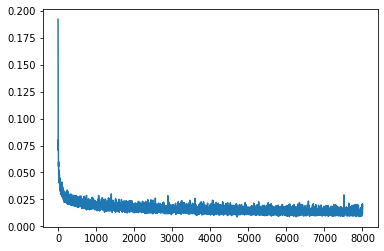

In [8]:
plt.plot(loss_hist[0:8000])

In [9]:
plt.rcParams['image.cmap']='jet'
unet_outlet.eval()
img = S.type(dtype).detach()
output = unet_outlet(img)

torch.Size([32, 3, 32, 32])
U0 is:  [0.        0.        0.        0.        0.3181818 0.3181818 0.3181818
 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818
 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818
 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818 0.3181818
 0.        0.        0.        0.       ]
V0 is:  [0.         0.         0.         0.         0.15151516 0.15151516
 0.15151516 0.15151516 0.15151516 0.15151516 0.15151516 0.15151516
 0.15151516 0.15151516 0.15151516 0.15151516 0.15151516 0.15151516
 0.15151516 0.15151516 0.15151516 0.15151516 0.15151516 0.15151516
 0.15151516 0.15151516 0.15151516 0.15151516 0.         0.
 0.         0.        ]


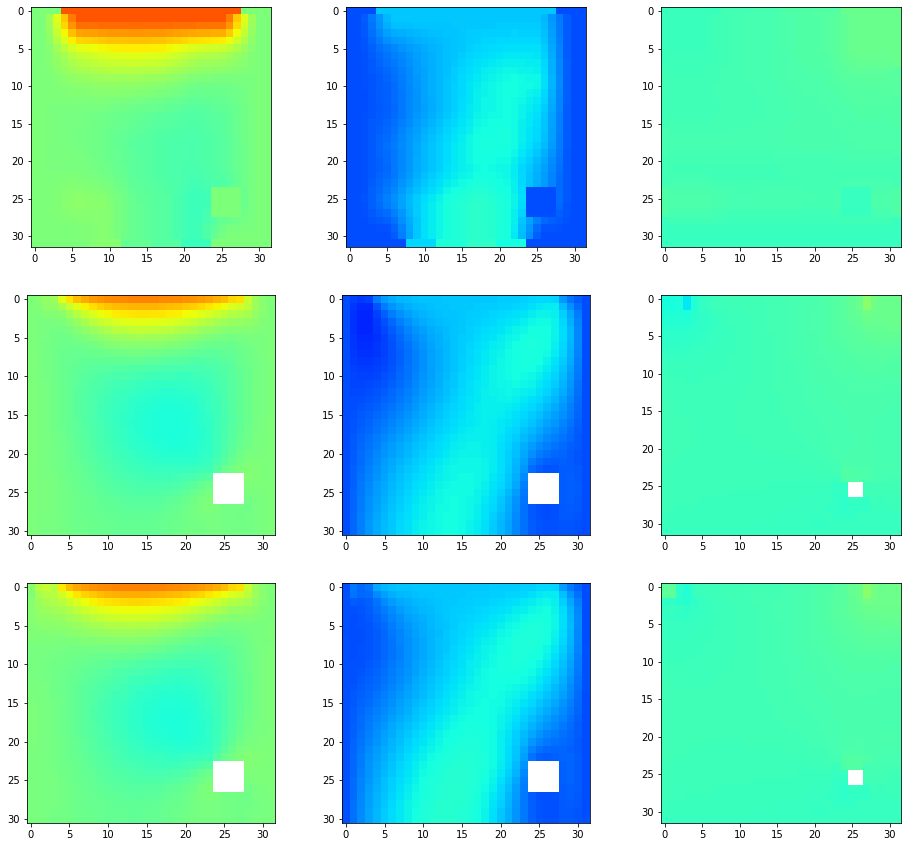

In [15]:
# plt.rcParams['image.cmap']='jet'
# S = torch.load('FlowData_UV_0331_warm_mixed32.pt')
# unet_outlet.eval()
# img = S.type(dtype).detach()
N = 10
# output = unet_outlet(img)
geometry = np.ones((size, size))
geometry[24:28, 24:28] = np.nan

geometry_bd_excluded = np.ones((size, size))
geometry_bd_excluded[25:27, 25:27] = np.nan


print(output.size())
UMAX, UMIN = 0.5, -0.5
VMAX, VMIN = 1.0, -0.25
PMAX, PMIN = 3.5, -2.5
print("U0 is: ", img[N,0,0,:].detach().cpu().numpy())
print("V0 is: ", img[N,1,0,:].detach().cpu().numpy())
u0_vector = img[N,0,0,:].detach().cpu().numpy()
v0_vector = img[N,1,0,:].detach().cpu().numpy()

size = 32
u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
L = 1
H = 1
dx = L / (size - 1)
dy = H / (size - 1)
CFL = 0.04
dt = CFL * min(dx , dy)
RE = 20
sol_u, sol_v, sol_p =solve_flow(5000, 32, 32, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector )


fig1, axes = plt.subplots(3, 3, figsize = (16,15))
axes[0,0].imshow(img[N,0,:,:].detach().cpu().numpy(), vmin=UMIN, vmax=UMAX )
axes[0,1].imshow(img[N,1,:,:].detach().cpu().numpy(), vmin=VMIN, vmax=VMAX)
axes[0,2].imshow(img[N,2,:,:].detach().cpu().numpy(), vmin=PMIN, vmax=PMAX)

axes[1,0].imshow(sol_u[1:,:] * geometry[1:,:], vmin=UMIN, vmax=UMAX)
axes[1,1].imshow(sol_v[1:,:] * geometry[1:,:], vmin=VMIN, vmax=VMAX)
axes[1,2].imshow(sol_p* geometry_bd_excluded, vmin=PMIN, vmax=PMAX)


axes[2,0].imshow(output[N,0,1:,:].detach().cpu().numpy()*geometry[1:,:], vmin=UMIN, vmax=UMAX)
axes[2,1].imshow(output[N,1,1:,:].detach().cpu().numpy()*geometry[1:,:], vmin=VMIN, vmax=VMAX)
axes[2,2].imshow(output[N,2,:,:].detach().cpu().numpy()*geometry_bd_excluded, vmin=PMIN, vmax=PMAX)


# print(get_loss(img,output))
# del img, output
fig1.savefig("outlet_warm0420.png")

In [57]:
unet_outlet()

TypeError: forward() takes 2 positional arguments but 3 were given

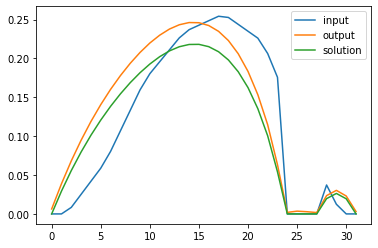

In [19]:

# S = torch.load('FlowData_UV_0324_warm_mixed32.pt')
# unet_outlet.eval()
img = S.type(dtype).detach()
N = 10
output = unet_outlet(img).detach()
plt.plot(img[N, 1, -6, :].cpu().numpy(), label="input" )
plt.plot(output[N, 1,-6, :].cpu().numpy(), label="output")
plt.plot(sol_v[-6, :], label="solution")
plt.legend()
plt.savefig("0420warm-v-profile-obj.png")

In [102]:
sol_u, sol_v, sol_p =solve_flow(5000, 32, 32, u, v, dt, dx, dy, p, u0=0.1, v0=0.5 )
sol_u.max()

0.16546998609001312

In [ ]:
plt.plot(img[N, 2, 0, :].cpu().numpy(), label="input" )
plt.plot(output[N, 2, 0, :].cpu().numpy(), label="output")
plt.plot(sol_p[0, :], label="solution")
plt.legend()
img[N, 1, 0, :].min()

In [65]:
UMAX, UMIN = 0.5, -0.114
VMAX, VMIN = 0.809, -0
PMAX, PMIN = 2.75, -0.187

get_factor = lambda M, m: ((M-m) / 2, -(M+m)/(M-m))
U_scale, U_base = get_factor(UMAX, UMIN)
V_scale, V_base = get_factor(VMAX, VMIN)
P_scale, P_base = get_factor(PMAX, PMIN)

In [71]:
P_scale

5.5

In [5]:
size = 32

size = 32
START_IN = 5
END_IN = 25
U0 = 0.25
V0 = 0.25
u0_vector = np.zeros((1,size))
v0_vector = np.zeros((1,size))

u0_vector[0, START_IN :END_IN ] = U0
v0_vector[0, START_IN :END_IN ] = V0
u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
L = 1 # dimensionless LX / LX
H = 1 # dimensionless LY / LX
dx = L / (size - 1)
dy = H / (size - 1)
CFL = 0.04
dt = CFL * min(dx , dy)
RE = 20
START_OUT = 22
END_OUT = 30


testUsol, testVsol, testPsol = solve_flow(2000, 32, 32, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector)

u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
iniU, iniV, iniP = solve_flow(2, 32, 32, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector)

warmS = torch.zeros(1, 3, 32, 32).type(dtype)
warmS[0,0,:,:] = torch.from_numpy(iniU)
warmS[0,1,:,:] = torch.from_numpy(iniV)
warmS[0,2,:,:] = torch.from_numpy(iniP)

testoutput = unet_outlet(warmS).type(dtype)


fig2, axes = plt.subplots(3, 3, figsize = (16,16))

UMAX, UMIN = 0.5, -0.5
VMAX, VMIN = 1.0, -0.25
PMAX, PMIN = 6.5, -2.5


axes[0,0].imshow(warmS[0,0,:,:].detach().cpu().numpy())
axes[0,0].set_title("X-Velocity") 
axes[0,1].imshow(warmS[0,1,:,:].detach().cpu().numpy())
axes[0,1].set_title("Y-Velocity")
axes[0,2].imshow(warmS[0,2,:,:].detach().cpu().numpy())
axes[0,2].set_title("Pressure") 

axes[1,0].imshow(testUsol, vmin=UMIN, vmax=UMAX)
axes[1,1].imshow(testVsol, vmin=VMIN, vmax=VMAX)
axes[1,2].imshow(testPsol, vmin=PMIN, vmax=PMAX)


axes[2,0].imshow(testoutput[0,0,:,:].detach().cpu().numpy(),  vmin=UMIN, vmax=UMAX)
axes[2,1].imshow(testoutput[0,1,:,:].detach().cpu().numpy(),  vmin=VMIN, vmax=VMAX)
axes[2,2].imshow(testoutput[0,2,:,:].detach().cpu().numpy(), vmin=PMIN, vmax=PMAX)


fig2.text(0.06, 0.25, 'Model Generation', fontsize=14, ha='center', va='center', rotation='vertical')
fig2.text(0.06, 0.5, 'FDM Solution', fontsize=14, ha='center', va='center', rotation='vertical')
fig2.text(0.06, 0.8, 'Initilization', fontsize=14, ha='center', va='center', rotation='vertical')
fig2.suptitle('Generation at u0={} v0={}'.format(u0,v0), fontsize=16)
# fig2.savefig('outlet_ini_test0304.png')

NameError: name 'dt' is not defined

In [24]:
# plt.plot(testoutput[0,2,-2,:].detach().cpu().numpy())
plt.plot(testoutput[0,1,-1,:].detach().cpu().numpy())

# plt.plot(testVsol[-2, :])

plt.plot(testVsol[-1, :])

plt.savefig("outlet0406_-1.png")

NameError: name 'testoutput' is not defined

In [69]:
u0 = 1.0
v0 = 0
u0_vector[0, 1:32] = u0  
v0_vector[0, 1:32] = v0  
testUsol, testVsol, testPsol = solve_flow(20, 32, 32, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector)
print(testUsol.max() )
print(testUsol.min() )

print(testVsol.max())
print(testVsol.min())

print(testPsol.max())
print(testPsol.min())

1.0
-0.07071140884612269
0.1778277347335323
-0.17045858454352653
2.4380334885218633
-2.4376387862148166
